# Neural Networks and Function Approximation

**Exercise:** [![Open in Colab](https://img.shields.io/badge/Open%20in-Colab-F9AB00?style=flat-square&logo=googlecolab)](https://colab.research.google.com/github/kks32-courses/sciml/blob/main/docs/00-mlp/mlp-exercise.ipynb)
**Solution:** [![Open in Colab](https://img.shields.io/badge/Open%20in-Colab-F9AB00?style=flat-square&logo=googlecolab)](https://colab.research.google.com/github/kks32-courses/sciml/blob/main/docs/00-mlp/mlp.ipynb)


**Slides:** [![View Presentation](https://img.shields.io/badge/View-PDF-blue?style=flat-square&logo=googleslides&logoColor=white)](https://github.com/kks32-courses/sciml/raw/main/docs/00-mlp/mlp-slides.pdf)

This notebook introduces the fundamental concepts of using neural networks for function approximation, a core task in scientific machine learning (SciML). We will build up from the basic building block, the perceptron, to a single-layer network and demonstrate its capacity to approximate a simple function, connecting theory to practice using PyTorch.

## Part 1: Problem set-up and motivation

### The 1D Poisson Equation: Our Benchmark Problem

We begin with a familiar problem: the one-dimensional Poisson equation on the unit interval $[0, 1]$ with homogeneous Dirichlet boundary conditions:

$$-\frac{d^2u}{dx^2} = f(x), \quad x \in [0, 1]$$

subject to boundary conditions:
$$u(0) = 0, \quad u(1) = 0$$

This equation models diverse physical phenomena: heat conduction in a rod, deflection of a loaded beam, or electrostatic potential in one dimension. The function $u(x)$ represents the unknown solution we seek, while $f(x)$ is the prescribed source term.

For our initial exploration, we choose a source term that gives a simple, known solution:
$$f(x) = \pi^2 \sin(\pi x)$$

This choice yields the analytical solution:
$$u(x) = \sin(\pi x)$$

We can verify this solution by direct substitution. The second derivative of $u(x) = \sin(\pi x)$ is $u''(x) = -\pi^2 \sin(\pi x)$, so:
$$-\frac{d^2u}{dx^2} = -(-\pi^2 \sin(\pi x)) = \pi^2 \sin(\pi x) = f(x) \quad \checkmark$$

The boundary conditions are satisfied: $u(0) = \sin(0) = 0$ and $u(1) = \sin(\pi) = 0$ ✓

In [73]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import random

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Set up plotting style
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

### The Function Approximation Challenge

Consider this question: *Can we learn to approximate $u(x) = \sin(\pi x)$ by observing only sparse data points?*

Let's explore this with a concrete example.

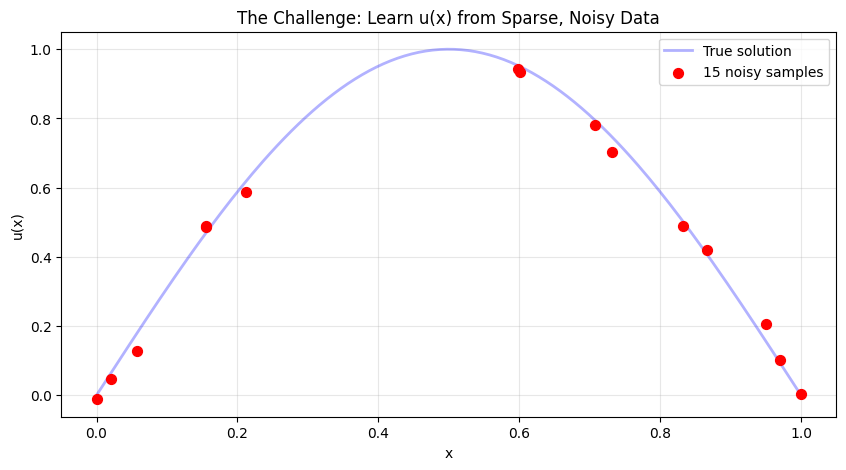

Training with 15 noisy data points


In [74]:
# Generate sparse training data
np.random.seed(42)
n_train = 15

# Training points - sparse and noisy
x_train = np.random.rand(n_train)
x_train[0], x_train[-1] = 0, 1  # Include boundaries
x_train = np.sort(x_train)

# Target function: sin(πx)
def target_func(x):
    """Target function: sin(πx)"""
    return np.sin(np.pi * x)

y_train = target_func(x_train) + 0.02 * np.random.randn(n_train)  # Add noise

# Dense grid for visualization
x_test = np.linspace(0, 1, 200)
y_exact = target_func(x_test)

# Visualize the problem
plt.figure(figsize=(10, 5))
plt.plot(x_test, y_exact, 'b-', alpha=0.3, linewidth=2, label='True solution')
plt.scatter(x_train, y_train, s=50, c='red', zorder=5, label=f'{n_train} noisy samples')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()
plt.title('The Challenge: Learn u(x) from Sparse, Noisy Data')
plt.show()

print(f"Training with {n_train} noisy data points")

### Polynomial Approximation: Why It Fails

Let's first try the classical approach - polynomial fitting. We'll see why high-degree polynomials fail on sparse data due to **Runge's phenomenon**.

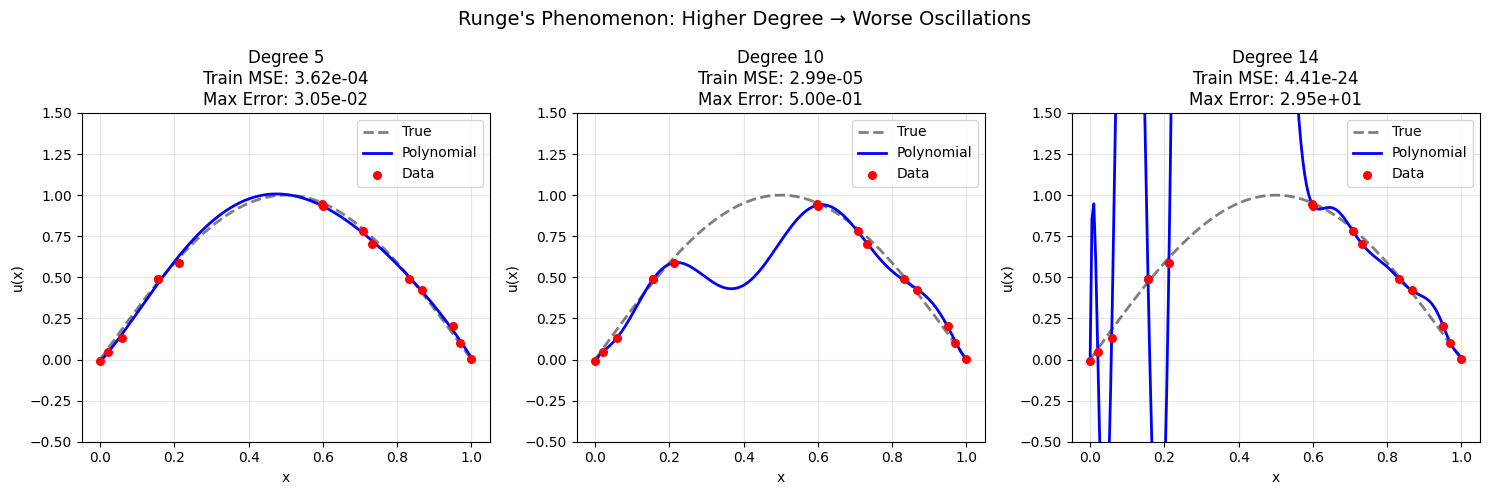

Polynomial Approximation Results:
----------------------------------------
Degree  5: Train MSE = 3.6209e-04, Max Error = 3.0538e-02
Degree 10: Train MSE = 2.9893e-05, Max Error = 4.9998e-01
Degree 14: Train MSE = 4.4053e-24, Max Error = 2.9467e+01


In [75]:
from numpy.polynomial import Polynomial

# Try different polynomial degrees
degrees = [5, 10, 14]  # n_train - 1 = 14 is the maximum meaningful degree
poly_models = {}
errors = {}

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, degree in enumerate(degrees):
    # Fit polynomial
    poly = Polynomial.fit(x_train, y_train, degree)
    y_poly = poly(x_test)
    poly_models[f'Poly-{degree}'] = y_poly
    
    # Compute errors
    train_mse = np.mean((poly(x_train) - y_train)**2)
    test_error = np.max(np.abs(y_poly - y_exact))
    errors[degree] = {'train_mse': train_mse, 'test_error': test_error}
    
    # Plot
    ax = axes[idx]
    ax.plot(x_test, y_exact, 'k--', alpha=0.5, linewidth=2, label='True')
    ax.plot(x_test, y_poly, 'b-', linewidth=2, label=f'Polynomial')
    ax.scatter(x_train, y_train, s=30, c='red', zorder=5, label='Data')
    ax.set_xlabel('x')
    ax.set_ylabel('u(x)')
    ax.set_title(f'Degree {degree}\nTrain MSE: {train_mse:.2e}\nMax Error: {test_error:.2e}')
    ax.legend()
    ax.set_ylim([-0.5, 1.5])
    
plt.suptitle('Runge\'s Phenomenon: Higher Degree → Worse Oscillations', fontsize=14)
plt.tight_layout()
plt.show()

# Print error summary
print("Polynomial Approximation Results:")
print("-" * 40)
for degree, err in errors.items():
    print(f"Degree {degree:2d}: Train MSE = {err['train_mse']:.4e}, Max Error = {err['test_error']:.4e}")

**Key Observation**: As polynomial degree increases:
- Training error decreases (eventually reaching zero for degree n-1)
- But test error *increases* due to wild oscillations between data points
- This is **Runge's phenomenon** - a fundamental limitation of polynomial interpolation

This motivates the need for alternative approaches like neural networks that can provide smooth approximations without these oscillations.

### Traditional Methods: Finite Difference

Traditional numerical methods like the Finite Difference Method or Finite Element Method solve PDEs by **discretizing the domain** into a grid or mesh. They approximate the solution $u(x)$ by finding its values at these specific, discrete points.

For example, the Finite Difference method approximates the second derivative:
$$\frac{d^2u}{dx^2} \approx \frac{u_{i+1} - 2u_i + u_{i-1}}{h^2}$$
This transforms the differential equation into a system of algebraic equations for the values $u_i$ at grid points $x_i$. The result is a discrete representation of the solution.

![FDM](figs/finite-difference-methods.png?raw=true)

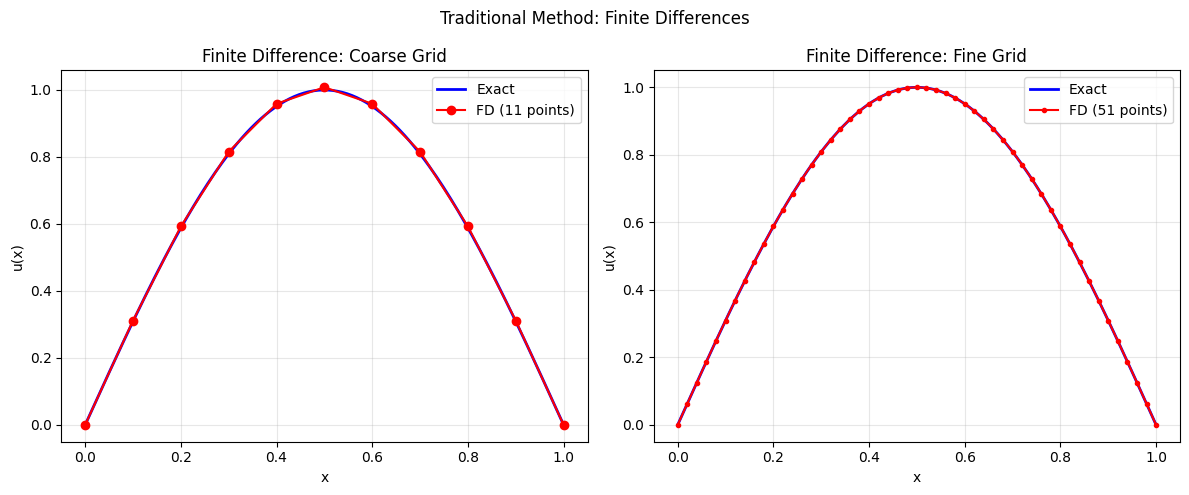

FD Coarse (11 points): Max error = 8.2654e-03
FD Fine (51 points):   Max error = 3.2905e-04
Error reduction factor: 25.1x


In [76]:
# Simple finite difference solution for comparison
def source_function(x):
    """Source term for Poisson equation: f(x) = π²sin(πx)"""
    return np.pi**2 * np.sin(np.pi * x)

def solve_poisson_fd(n_points=101):
    """
    Solve 1D Poisson equation: -u'' = f(x) using finite differences
    with homogeneous Dirichlet boundary conditions.
    """
    # Grid
    x_fd = np.linspace(0, 1, n_points)
    h = 1.0 / (n_points - 1)
    
    # Tridiagonal matrix for -u'' (central difference)
    n_interior = n_points - 2
    A = np.zeros((n_interior, n_interior))
    np.fill_diagonal(A, 2.0 / h**2)
    np.fill_diagonal(A[1:, :], -1.0 / h**2)
    np.fill_diagonal(A[:, 1:], -1.0 / h**2)
    
    # Right-hand side (source function at interior points)
    f_rhs = source_function(x_fd[1:-1])
    
    # Solve linear system A u_interior = f_rhs
    u_interior = np.linalg.solve(A, f_rhs)
    
    # Complete solution with boundary conditions
    u_fd = np.zeros(n_points)
    u_fd[0] = 0  # u(0) = 0
    u_fd[-1] = 0  # u(1) = 0
    u_fd[1:-1] = u_interior
    
    return x_fd, u_fd

# Solve using finite differences with different resolutions
x_fd_coarse, u_fd_coarse = solve_poisson_fd(11)  # Coarse grid
x_fd_fine, u_fd_fine = solve_poisson_fd(51)      # Fine grid

# Create comparison plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Coarse grid
ax1.plot(x_test, y_exact, 'b-', linewidth=2, label='Exact')
ax1.plot(x_fd_coarse, u_fd_coarse, 'ro-', markersize=6, label=f'FD (11 points)')
ax1.set_xlabel('x')
ax1.set_ylabel('u(x)')
ax1.set_title('Finite Difference: Coarse Grid')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Fine grid
ax2.plot(x_test, y_exact, 'b-', linewidth=2, label='Exact')
ax2.plot(x_fd_fine, u_fd_fine, 'ro-', markersize=3, label=f'FD (51 points)')
ax2.set_xlabel('x')
ax2.set_ylabel('u(x)')
ax2.set_title('Finite Difference: Fine Grid')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.suptitle('Traditional Method: Finite Differences')
plt.tight_layout()
plt.show()

# Compute errors
error_coarse = np.max(np.abs(u_fd_coarse - target_func(x_fd_coarse)))
error_fine = np.max(np.abs(u_fd_fine - target_func(x_fd_fine)))

print(f"FD Coarse (11 points): Max error = {error_coarse:.4e}")
print(f"FD Fine (51 points):   Max error = {error_fine:.4e}")
print(f"Error reduction factor: {error_coarse/error_fine:.1f}x")

## Part 2: Mathematical Foundations 

### Weierstrass Polynomial Approximation Theorem

**Weierstrass Approximation Theorem (1885):** If $f$ is a continuous function on a closed and bounded interval $[a, b]$, then for any $\varepsilon > 0$, there exists a polynomial $P(x)$ such that

$|f(x) - P(x)| < \varepsilon$

for all $x \in [a, b]$.

### What This Means

The theorem tells us that **any continuous function can be approximated arbitrarily closely by polynomials**. No matter how "weird" or complicated a continuous function might be, we can always find a polynomial that gets as close as we want to that function over any closed interval.

This is remarkable because:
- Polynomials are among the simplest functions to work with computationally
- They can be differentiated and integrated easily
- Yet they're dense in the space of continuous functions

### Historical Context

Karl Weierstrass proved this theorem in 1885, though the result was actually known to him since 1872. It was groundbreaking because it showed that despite polynomials seeming "simple," they could approximate any continuous behavior.

### Constructive Proof: Bernstein Polynomials

One elegant way to prove this theorem constructively is using **Bernstein polynomials**. For a function $f$ on $[0,1]$, the $n$-th Bernstein polynomial is:

$B_n(x) = \sum_{k=0}^n f(k/n) \cdot \binom{n}{k} \cdot x^k \cdot (1-x)^{n-k}$

where $\binom{n}{k}$ is the binomial coefficient. As $n \to \infty$, $B_n(x)$ converges uniformly to $f(x)$.

### Key Insight

The theorem bridges the gap between the abstract world of arbitrary continuous functions and the concrete, computational world of polynomials. It guarantees that we never need to work with functions more complicated than polynomials when dealing with continuous phenomena on bounded intervals.

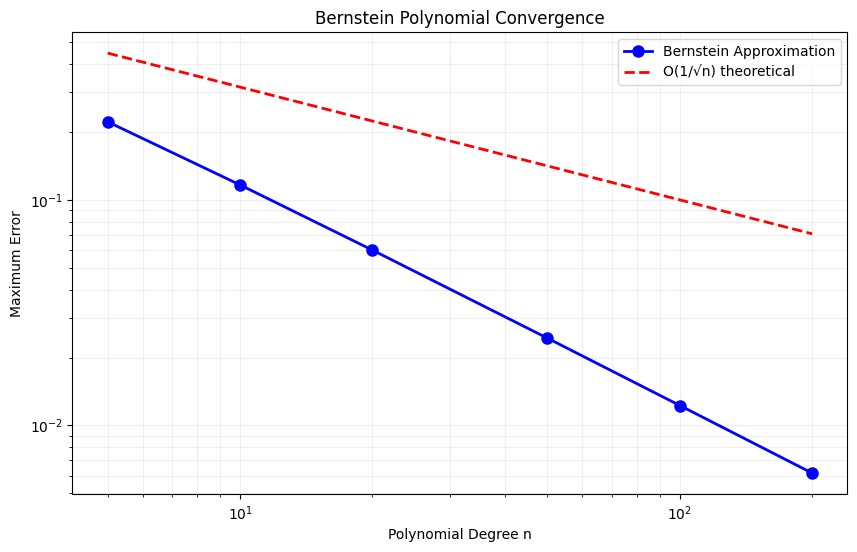

Convergence rate: -0.99
(Theoretical: -0.5 for O(1/√n))


In [77]:
# Convergence analysis: Error vs Polynomial Degree
from scipy.special import comb

def bernstein_polynomial(f, n, x):
    """Compute n-th Bernstein polynomial approximation"""
    result = np.zeros_like(x)
    for k in range(n + 1):
        basis = comb(n, k) * (x ** k) * ((1 - x) ** (n - k))
        result += f(k/n) * basis
    return result

# Test convergence
x_test_bern = np.linspace(0, 1, 1000)
y_true_bern = target_func(x_test_bern)

degrees = [5, 10, 20, 50, 100, 200]
errors = []

for n in degrees:
    y_approx = bernstein_polynomial(target_func, n, x_test_bern)
    max_error = np.max(np.abs(y_true_bern - y_approx))
    errors.append(max_error)
    
# Theoretical rate: O(1/sqrt(n))
theoretical = 1.0 / np.sqrt(degrees)

plt.figure(figsize=(10, 6))
plt.loglog(degrees, errors, 'bo-', label='Bernstein Approximation', linewidth=2, markersize=8)
plt.loglog(degrees, theoretical, 'r--', label='O(1/√n) theoretical', linewidth=2)
plt.xlabel('Polynomial Degree n')
plt.ylabel('Maximum Error')
plt.title('Bernstein Polynomial Convergence')
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()

print(f"Convergence rate: {np.polyfit(np.log(degrees[-3:]), np.log(errors[-3:]), 1)[0]:.2f}")
print("(Theoretical: -0.5 for O(1/√n))")

The theoretical convergence rate is $O(1/\sqrt{n})$. The observed convergence is slow but guaranteed to reach zero. This demonstrates the Weierstrass Approximation Theorem: any continuous function on [0,1] can be uniformly approximated by polynomials to arbitrary precision.

### Why This Proves the Weierstrass Theorem

The Bernstein polynomials provide a **constructive proof** of the Weierstrass Approximation Theorem:

1. **Guaranteed Convergence**: For any continuous function $f$ on $[0,1]$, the Bernstein polynomials $B_n(f;x)$ converge uniformly to $f$ as $n \to \infty$

2. **Explicit Construction**: Unlike existence proofs, Bernstein gives us an explicit formula:
   $$B_n(f; x) = \sum_{k=0}^{n} f\left(\frac{k}{n}\right) \binom{n}{k} x^k (1-x)^{n-k}$$

3. **Convergence Rate**: For functions with modulus of continuity $\omega(f; \delta)$, the error satisfies:
   $$|f(x) - B_n(f; x)| \leq \frac{3}{2} \omega\left(f; \frac{1}{\sqrt{n}}\right)$$
   
4. **Key Properties**:
   - **Positivity**: If $f \geq 0$, then $B_n(f) \geq 0$
   - **Monotonicity**: If $f$ is increasing, so is $B_n(f)$
   - **End-point interpolation**: $B_n(f; 0) = f(0)$ and $B_n(f; 1) = f(1)$

This demonstrates that **any continuous function can be approximated arbitrarily well by polynomials** - the foundation for neural networks' universal approximation capabilities!

### From Polynomials to Neural Networks: The Weierstrass Approximation Theorem

Before diving into the Universal Approximation Theorem for neural networks, let's explore its historical predecessor: the **Weierstrass Approximation Theorem** (1885). This foundational result shows that polynomials can approximate any continuous function, providing the mathematical intuition for why neural networks work.

#### The Weierstrass Approximation Theorem

**Theorem (Weierstrass, 1885):** Every continuous function on a closed interval $[a, b]$ can be uniformly approximated as closely as desired by a polynomial function.

Formally: For any continuous function $f: [a, b] \to \mathbb{R}$ and any $\epsilon > 0$, there exists a polynomial $p(x)$ such that:

$$\sup_{x \in [a,b]} |f(x) - p(x)| < \epsilon$$

This theorem tells us that the set of polynomials is **dense** in the space of continuous functions under the uniform norm.

### Why This Matters for Neural Networks

The Weierstrass theorem establishes a crucial principle: **simple building blocks (monomials $x^n$) can approximate arbitrarily complex continuous functions**. Neural networks follow the same principle but with different building blocks:

- **Polynomials**: Build from monomials $(1, x, x^2, x^3, ...)$
- **Neural Networks**: Build from activation functions (ReLU, sigmoid, tanh, ...)

Both achieve universal approximation, but neural networks often do it more efficiently!

Weierstrass Approximation of sin(πx) with Polynomials
Degree  3: Max error = 0.047466
 Polynomial: p(x) = 0.979 -1.027x^2 ...

Degree  5: Max error = 0.001126
 Polynomial: p(x) = 1.000 -1.224x^2 +0.226x^4 ...

Degree  9: Max error = 0.000000
 Polynomial: p(x) = 1.000 -1.234x^2 +0.254x^4 -0.021x^6 ...



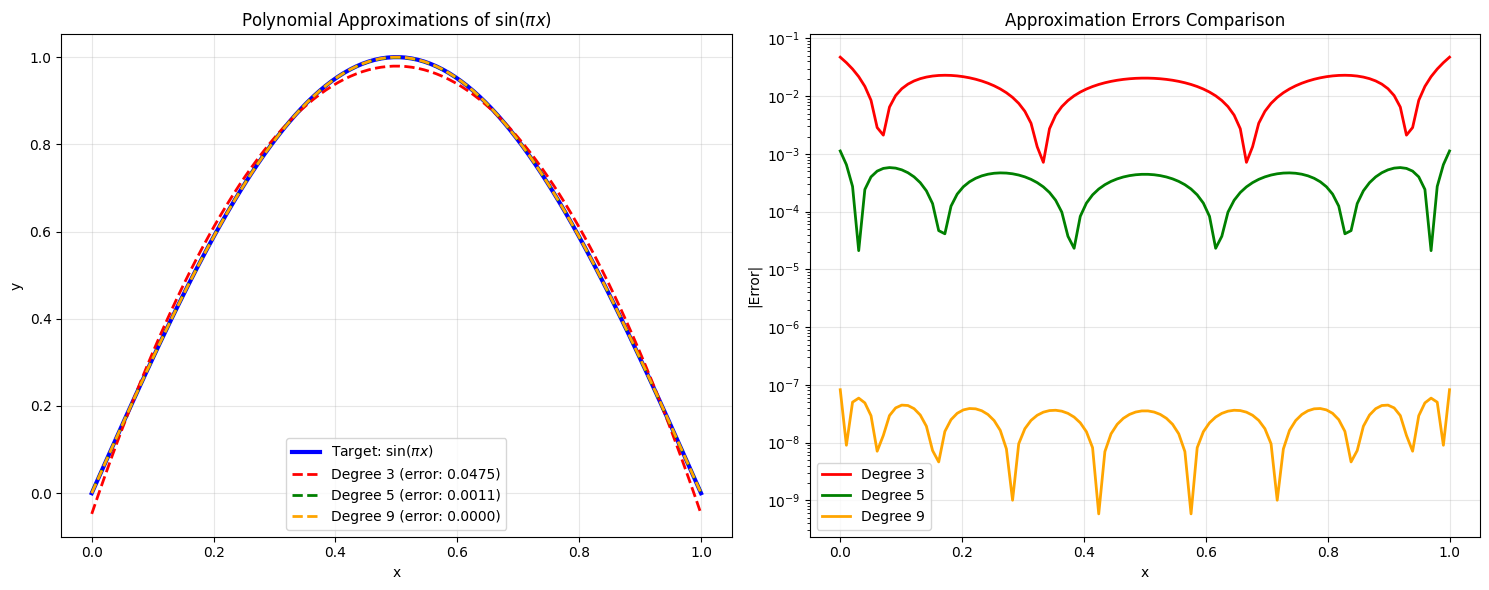

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial import Polynomial

def approximate_with_polynomial(func, x_range, degree, title="Polynomial Approximation"):
    """Approximate a function using polynomial regression (least squares)"""
    x = np.linspace(x_range[0], x_range[1], 100)
    y = func(x)
    # Fit polynomial using numpy
    poly = Polynomial.fit(x, y, degree)
    y_approx = poly(x)
    # Calculate approximation error
    error = np.max(np.abs(y - y_approx))
    
    return poly, error

# Target function: sin(πx)
target_func = lambda x: np.sin(np.pi * x)
print("Weierstrass Approximation of sin(πx) with Polynomials")
print("=" * 60)

# Show increasing polynomial degrees
degrees = [3, 5, 9]
colors = ['red', 'green', 'orange']
errors = []

# Create single figure with two subplots
plt.figure(figsize=(15, 6))

# First subplot: All approximations together
plt.subplot(1, 2, 1)

# Plot target function first
x = np.linspace(0, 1, 100)
y = target_func(x)
plt.plot(x, y, 'b-', linewidth=3, label='Target: $\\sin(\\pi x)$')

# Plot approximations for each degree
for i, degree in enumerate(degrees):
    poly, error = approximate_with_polynomial(
        target_func, [0, 1], degree,
        f"Polynomial Approximation (Degree {degree})"
    )
    
    # Get approximation data
    x = np.linspace(0, 1, 100)
    y = target_func(x)
    y_approx = poly(x)
    
    errors.append(error)
    
    # Plot approximation with different color
    plt.plot(x, y_approx, '--', color=colors[i], linewidth=2, 
             label=f'Degree {degree} (error: {error:.4f})')
    
    print(f"Degree {degree:2d}: Max error = {error:.6f}")
    
    # Print polynomial coefficients
    coeffs = poly.coef
    print(f" Polynomial: p(x) = ", end="")
    terms = []
    for j, coef in enumerate(coeffs):
        if abs(coef) > 1e-10: # Skip near-zero coefficients
            if j == 0:
                terms.append(f"{coef:.3f}")
            elif j == 1:
                terms.append(f"{coef:+.3f}x")
            else:
                terms.append(f"{coef:+.3f}x^{j}")
    print(" ".join(terms[:4]) + " ...") # Show first few terms
    print()

plt.xlabel('x')
plt.ylabel('y')
plt.title('Polynomial Approximations of $\\sin(\\pi x)$')
plt.legend()
plt.grid(True, alpha=0.3)

# Second subplot: All errors together
plt.subplot(1, 2, 2)
for i, degree in enumerate(degrees):
    poly, error = approximate_with_polynomial(
        target_func, [0, 1], degree,
        f"Polynomial Approximation (Degree {degree})"
    )
    
    # Get error data
    x = np.linspace(0, 1, 100)
    y = target_func(x)
    y_approx = poly(x)
    
    # Plot error with same color as approximation
    plt.plot(x, np.abs(y - y_approx), '-', color=colors[i], linewidth=2, 
             label=f'Degree {degree}')

plt.xlabel('x')
plt.ylabel('|Error|')
plt.title('Approximation Errors Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')  # Log scale for better visualization

plt.tight_layout()
plt.show()

### Convergence Analysis

As we increase the polynomial degree, the approximation improves:

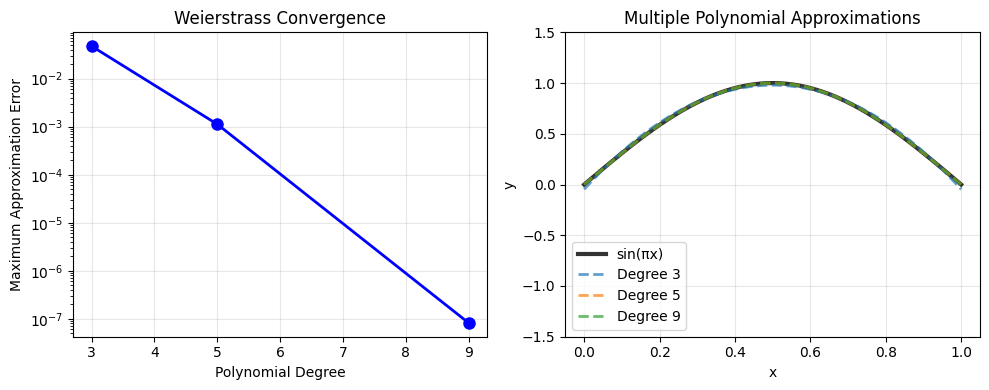


Key Observations:
1. Higher degree polynomials provide better approximation
2. Error decreases exponentially with polynomial degree
3. But high-degree polynomials can be unstable (Runge's phenomenon)


In [79]:

# Plot convergence
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(degrees, errors, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Polynomial Degree')
plt.ylabel('Maximum Approximation Error')
plt.title('Weierstrass Convergence')
plt.grid(True, alpha=0.3)
plt.yscale('log')

plt.subplot(1, 2, 2)
# Compare different degrees visually
x = np.linspace(0, 1, 200)
y_true = target_func(x)
plt.plot(x, y_true, 'k-', linewidth=3, label='sin(πx)', alpha=0.8)

for i, degree in enumerate([3, 5, 9]):
    poly = Polynomial.fit(np.linspace(0, 1, 100), 
                          target_func(np.linspace(0, 1, 100)), degree)
    plt.plot(x, poly(x), '--', linewidth=2, label=f'Degree {degree}', alpha=0.7)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Multiple Polynomial Approximations')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(-1.5, 1.5)

plt.tight_layout()
plt.show()

print("\nKey Observations:")
print("1. Higher degree polynomials provide better approximation")
print("2. Error decreases exponentially with polynomial degree")
print("3. But high-degree polynomials can be unstable (Runge's phenomenon)")


### Bernstein Polynomials: A Constructive Proof

One elegant proof of the Weierstrass theorem uses **Bernstein polynomials**, which provide an explicit construction:

$$B_n(f; x) = \sum_{k=0}^{n} f\left(\frac{k}{n}\right) \binom{n}{k} x^k (1-x)^{n-k}$$

These polynomials converge uniformly to $f$ as $n \to \infty$.

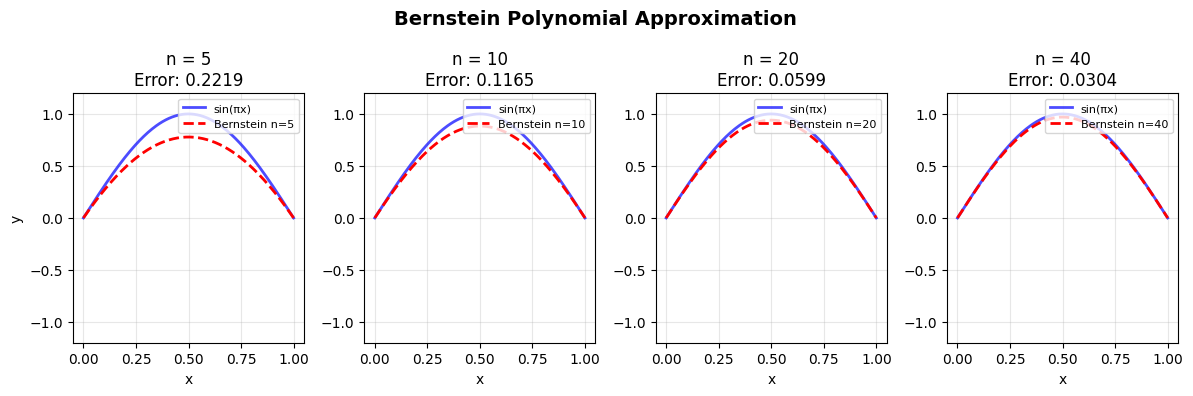


Bernstein Polynomials:
• Provide a constructive proof of Weierstrass theorem
• Converge uniformly but slowly
• Always stay within the range of the function
• Form the basis for Bézier curves in computer graphics!


In [80]:

def bernstein_polynomial(f, n, x):
    """Compute n-th Bernstein polynomial approximation"""
    from scipy.special import comb
    
    result = np.zeros_like(x)
    for k in range(n + 1):
        # Bernstein basis polynomial
        basis = comb(n, k) * (x ** k) * ((1 - x) ** (n - k))
        # Weight by function value at k/n
        result += f(k / n) * basis
    return result

# Demonstrate Bernstein approximation
plt.figure(figsize=(12, 4))

x = np.linspace(0, 1, 200)
y_true = target_func(x)

degrees = [5, 10, 20, 40]
for i, n in enumerate(degrees):
    plt.subplot(1, 4, i + 1)
    y_bernstein = bernstein_polynomial(target_func, n, x)
    
    plt.plot(x, y_true, 'b-', linewidth=2, label='sin(πx)', alpha=0.7)
    plt.plot(x, y_bernstein, 'r--', linewidth=2, label=f'Bernstein n={n}')
    
    error = np.max(np.abs(y_true - y_bernstein))
    plt.title(f'n = {n}\nError: {error:.4f}')
    plt.xlabel('x')
    if i == 0:
        plt.ylabel('y')
    plt.legend(loc='upper right', fontsize=8)
    plt.grid(True, alpha=0.3)
    plt.ylim(-1.2, 1.2)

plt.suptitle('Bernstein Polynomial Approximation', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nBernstein Polynomials:")
print("• Provide a constructive proof of Weierstrass theorem")
print("• Converge uniformly but slowly")
print("• Always stay within the range of the function")
print("• Form the basis for Bézier curves in computer graphics!")


### Polynomials vs Neural Networks: A Direct Comparison

Let's compare polynomial approximation with neural network approximation for the same function:

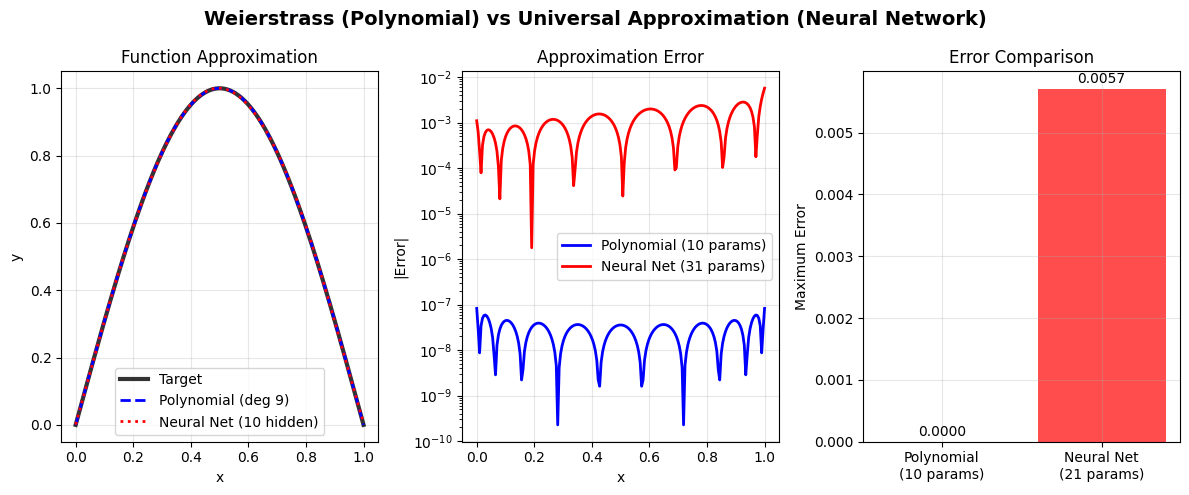


Comparison Summary:
Polynomial (degree 9):
  Parameters: 10
  Max Error: 0.000000

Neural Network (10 hidden units):
  Parameters: 31
  Max Error: 0.005705

Note: Neural network uses Sigmoid activation for smooth approximation


In [81]:

import torch
import torch.nn as nn
import torch.optim as optim

# Simple neural network
class SimpleNN(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, hidden_size),
            nn.Sigmoid(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, x):
        return self.net(x)

# Train neural network
def train_nn(hidden_size=20, epochs=5000):
    x_train = torch.linspace(0, 1, 200).reshape(-1, 1)
    y_train = torch.tensor([target_func(x.item()) for x in x_train], 
                           dtype=torch.float32).reshape(-1, 1)
    
    model = SimpleNN(hidden_size)
    optimizer = optim.Adam(model.parameters(), lr=0.1)
    criterion = nn.MSELoss()
    
    # Train with early stopping
    best_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        y_pred = model(x_train)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
        # Early stopping
        if loss.item() < best_loss:
            best_loss = loss.item()
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter > 500 or loss.item() < 1e-6:
            break
    
    return model

# Compare polynomial vs neural network
plt.figure(figsize=(12, 5))

x_test = np.linspace(0, 1, 200)
y_true = target_func(x_test)

# Polynomial approximation
poly_degree = 9
poly = Polynomial.fit(np.linspace(0, 1, 100), 
                      target_func(np.linspace(0, 1, 100)), poly_degree)
y_poly = poly(x_test)
poly_params = poly_degree + 1

# Neural network approximation
nn_hidden = 10
model = train_nn(nn_hidden, epochs=10000)
x_test_torch = torch.tensor(x_test.reshape(-1, 1), dtype=torch.float32)
with torch.no_grad():
    y_nn = model(x_test_torch).numpy().flatten()
nn_params = 1 * nn_hidden + nn_hidden + nn_hidden * 1 + 1  # weights + biases

# Plot comparison
plt.subplot(1, 3, 1)
plt.plot(x_test, y_true, 'k-', linewidth=3, label='Target', alpha=0.8)
plt.plot(x_test, y_poly, 'b--', linewidth=2, label=f'Polynomial (deg {poly_degree})')
plt.plot(x_test, y_nn, 'r:', linewidth=2, label=f'Neural Net ({nn_hidden} hidden)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Function Approximation')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(x_test, np.abs(y_true - y_poly), 'b-', linewidth=2, 
         label=f'Polynomial ({poly_params} params)')
plt.plot(x_test, np.abs(y_true - y_nn), 'r-', linewidth=2, 
         label=f'Neural Net ({nn_params} params)')
plt.xlabel('x')
plt.ylabel('|Error|')
plt.title('Approximation Error')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')

plt.subplot(1, 3, 3)
errors_comparison = {
    'Polynomial\n(10 params)': np.max(np.abs(y_true - y_poly)),
    'Neural Net\n(21 params)': np.max(np.abs(y_true - y_nn))
}
bars = plt.bar(errors_comparison.keys(), errors_comparison.values(), 
               color=['blue', 'red'], alpha=0.7)
plt.ylabel('Maximum Error')
plt.title('Error Comparison')
for bar, error in zip(bars, errors_comparison.values()):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.0001,
             f'{error:.4f}', ha='center', fontsize=10)
plt.grid(True, alpha=0.3, axis='y')

plt.suptitle('Weierstrass (Polynomial) vs Universal Approximation (Neural Network)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nComparison Summary:")
print(f"Polynomial (degree {poly_degree}):")
print(f"  Parameters: {poly_params}")
print(f"  Max Error: {np.max(np.abs(y_true - y_poly)):.6f}")
print(f"\nNeural Network ({nn_hidden} hidden units):")
print(f"  Parameters: {nn_params}")
print(f"  Max Error: {np.max(np.abs(y_true - y_nn)):.6f}")
print(f"\nNote: Neural network uses Sigmoid activation for smooth approximation")


### Limitations of Polynomial Approximation

While polynomials can theoretically approximate any continuous function, they have practical limitations:

1. **Runge's Phenomenon**: High-degree polynomials oscillate wildly at boundaries
2. **Global Support**: Changing one coefficient affects the entire function
3. **Computational Instability**: High-degree polynomials suffer from numerical issues
4. **Poor Extrapolation**: Polynomials diverge rapidly outside the training interval

Neural networks address these limitations:
- **Local Support**: ReLU networks create piecewise linear approximations
- **Stability**: Bounded activations (sigmoid, tanh) prevent divergence
- **Compositionality**: Deep networks build complex functions from simple pieces
- **Adaptivity**: Networks learn where to place their "basis functions"

### From Weierstrass to Universal Approximation

The progression from Weierstrass to neural networks represents a evolution in approximation theory:

1. **1885 - Weierstrass**: Polynomials are universal approximators
2. **1989 - Cybenko**: Single-layer neural networks are universal approximators
3. **Modern Deep Learning**: Deep networks are exponentially more efficient

This historical perspective shows that neural networks are not magical – they're the latest chapter in a long mathematical story about approximating complex functions with simple building blocks!

## Part 3: The Neural Network Approach: Function Approximation

Our goal is to train a neural network $u_{NN}(x; \theta)$ to approximate the continuous solution $u^*(x) = \sin(\pi x)$ over the interval $[0, 1]$. This is a **function approximation** problem.

The theoretical foundation for this approach is the **Universal Approximation Theorem (UAT)**, which guarantees that neural networks can approximate any continuous function to arbitrary accuracy with enough neurons. *We'll explore UAT in detail later in this notebook.*

### Traditional Numerical Method vs Neural Network: Discrete vs Continuous

Traditional numerical methods compute discrete values at grid points. In contrast, the Neural Network approach learns a **continuous function** $u_{NN}(x; \theta)$ that approximates the true solution $u^*(x)$ over the entire domain. 

- This function is parameterized by the network's weights and biases $\theta$
- We train by adjusting $\theta$ so the network's output matches training data
- Once trained, we can evaluate the solution at any point, not just grid points

### The Perceptron: Building Block of Neural Networks

A perceptron is a linear transformation followed by an activation function:
$$\hat{y} = g(\mathbf{w}^T\mathbf{x} + b)$$

We'll start with the simplest case: no activation (linear perceptron), implement training from scratch, then add nonlinearity.


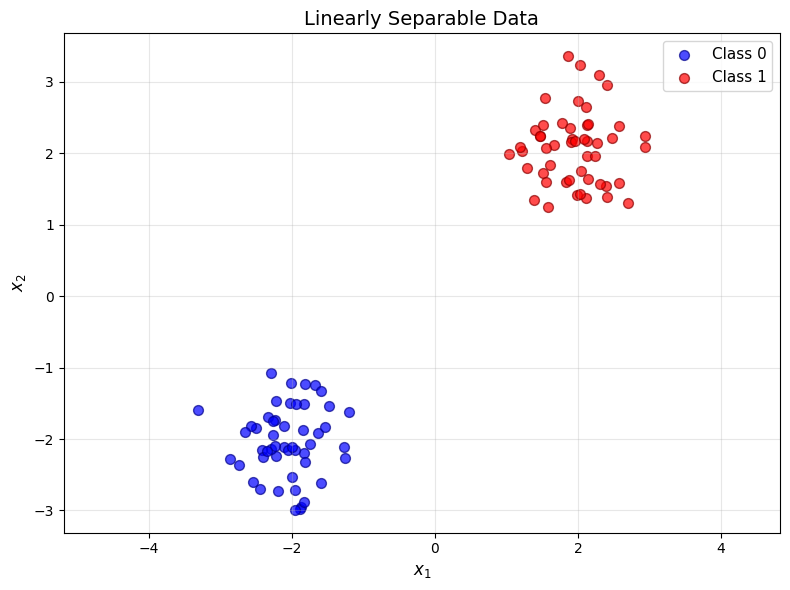

Total samples: 100
Class 0: 50 samples
Class 1: 50 samples

Class 0 center: [-2.07, -2.04]
Class 1 center: [1.95, 2.07]


In [82]:
import numpy as np
import matplotlib.pyplot as plt

# Generate linearly separable data
np.random.seed(42)
n = 50

# Two classes
X0 = np.random.randn(n, 2) * 0.5 + [-2, -2]
X1 = np.random.randn(n, 2) * 0.5 + [2, 2]
X = np.vstack([X0, X1])
y = np.hstack([np.zeros(n), np.ones(n)])

# Visualize just the data
plt.figure(figsize=(8, 6))
plt.scatter(X0[:, 0], X0[:, 1], c='blue', s=50, alpha=0.7, label='Class 0', edgecolors='darkblue')
plt.scatter(X1[:, 0], X1[:, 1], c='red', s=50, alpha=0.7, label='Class 1', edgecolors='darkred')

plt.xlabel('$x_1$', fontsize=12)
plt.ylabel('$x_2$', fontsize=12)
plt.title('Linearly Separable Data', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.show()

# Print some basic statistics about the data
print(f"Total samples: {len(X)}")
print(f"Class 0: {len(X0)} samples")
print(f"Class 1: {len(X1)} samples")
print(f"\nClass 0 center: [{X0.mean(axis=0)[0]:.2f}, {X0.mean(axis=0)[1]:.2f}]")
print(f"Class 1 center: [{X1.mean(axis=0)[0]:.2f}, {X1.mean(axis=0)[1]:.2f}]")

### Linear Perceptron in NumPy

First, a pure linear model: $\hat{y} = \mathbf{w}^T\mathbf{x} + b$


In [83]:
import numpy as np
import matplotlib.pyplot as plt

class LinearPerceptron:
    def __init__(self, dim):
        self.w = np.random.randn(dim) * 0.01
        self.b = 0.0
    
    def forward(self, x):
        """Compute output: y = w^T x + b"""
        return np.dot(x, self.w) + self.b
    
    def predict_batch(self, X):
        """Predict for multiple samples"""
        return X @ self.w + self.b

### Training: Gradient Descent from Scratch

To train, we minimize the mean squared error loss:
$$L = \frac{1}{2N}\sum_{i=1}^N (y_i - \hat{y}_i)^2$$

Using calculus, we derive the gradients:

For a single sample with prediction $\hat{y} = \mathbf{w}^T\mathbf{x} + b$ and loss $L = \frac{1}{2}(y - \hat{y})^2$:

**Gradient w.r.t weights:**
$$\frac{\partial L}{\partial \mathbf{w}} = \frac{\partial L}{\partial \hat{y}} \cdot \frac{\partial \hat{y}}{\partial \mathbf{w}} = -(y - \hat{y}) \cdot \mathbf{x}$$

**Gradient w.r.t bias:**
$$\frac{\partial L}{\partial b} = \frac{\partial L}{\partial \hat{y}} \cdot \frac{\partial \hat{y}}{\partial b} = -(y - \hat{y})$$

The update rule:
$$\mathbf{w} \leftarrow \mathbf{w} + \eta(y - \hat{y})\mathbf{x}$$
$$b \leftarrow b + \eta(y - \hat{y})$$

where $\eta$ is the learning rate.


In [84]:
def train_linear_perceptron(model, X, y, lr=0.01, epochs=100):
    """Train using gradient descent"""
    losses = []
    
    for epoch in range(epochs):
        # Forward pass for all samples
        y_pred = model.predict_batch(X)
        
        # Compute loss
        loss = 0.5 * np.mean((y - y_pred)**2)
        losses.append(loss)
        
        # Compute gradients (vectorized)
        error = y_pred - y  # Note: gradient of MSE
        grad_w = X.T @ error / len(X)
        grad_b = np.mean(error)
        
        # Update parameters
        model.w -= lr * grad_w
        model.b -= lr * grad_b
        
        if (epoch + 1) % 25 == 0:
            print(f"Epoch {epoch+1}: loss={loss:.4f}")
    
    return losses

### Example: Linear Classification


Epoch 25: loss=0.0041
Epoch 50: loss=0.0032
Epoch 75: loss=0.0032
Epoch 100: loss=0.0032


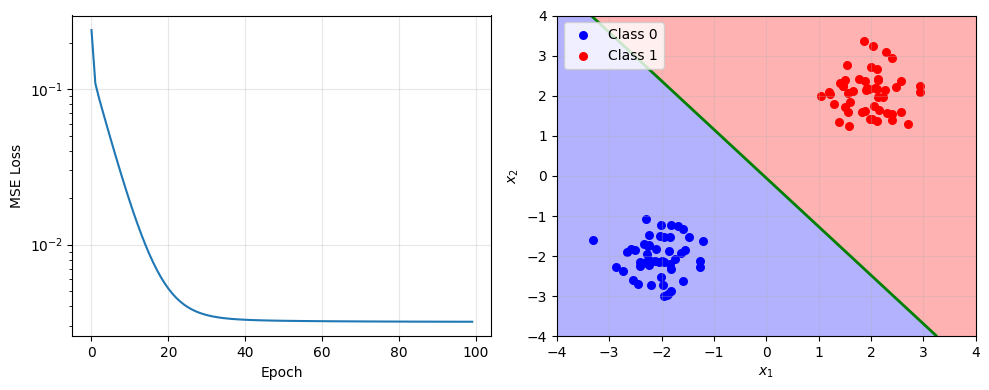


Learned parameters: w=[0.13149522 0.10857732], b=0.506


In [85]:
# Generate linearly separable data
np.random.seed(42)
n = 50

# Two classes
X0 = np.random.randn(n, 2) * 0.5 + [-2, -2]
X1 = np.random.randn(n, 2) * 0.5 + [2, 2]
X = np.vstack([X0, X1])
y = np.hstack([np.zeros(n), np.ones(n)])

# Train linear perceptron
model = LinearPerceptron(2)
losses = train_linear_perceptron(model, X, y, lr=0.1, epochs=100)

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Loss curve
ax1.plot(losses)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('MSE Loss')
ax1.set_yscale('log')
ax1.grid(True, alpha=0.3)

# Decision boundary
xx, yy = np.meshgrid(np.linspace(-4, 4, 100), np.linspace(-4, 4, 100))
Z = model.predict_batch(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

ax2.contour(xx, yy, Z, levels=[0.5], colors='g', linewidths=2)
ax2.contourf(xx, yy, Z, levels=[-1, 0.5, 2], alpha=0.3, colors=['blue', 'red'])
ax2.scatter(X0[:,0], X0[:,1], c='b', s=30, label='Class 0')
ax2.scatter(X1[:,0], X1[:,1], c='r', s=30, label='Class 1')
ax2.set_xlabel('$x_1$')
ax2.set_ylabel('$x_2$')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nLearned parameters: w={model.w}, b={model.b:.3f}")

### Limitation: Non-linear Patterns

Linear perceptrons fail on non-linearly separable data:


Epoch 25: loss=0.0531
Epoch 50: loss=0.0520
Epoch 75: loss=0.0520
Epoch 100: loss=0.0520


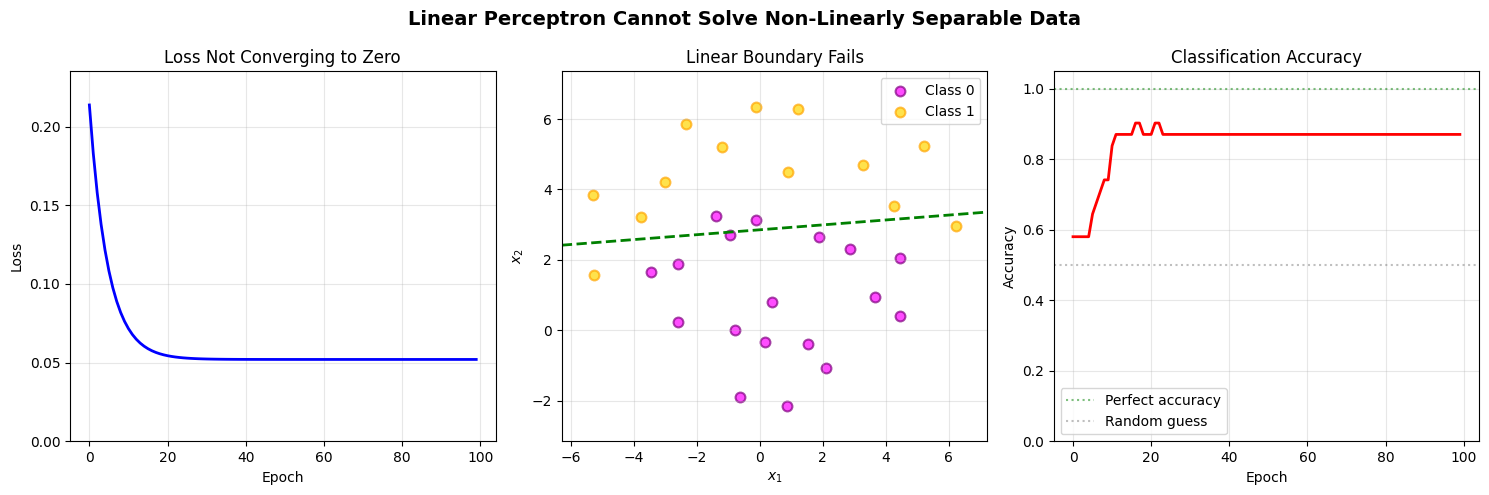

Final loss: 0.0520
Final accuracy: 87.10%


In [86]:
# Generate XOR-like pattern (not linearly separable)
# Similar to the data in relu.md visualization
np.random.seed(42)

# Class 0 - diagonal pattern (magenta points)
class0_X = np.array([
    [-2.75, 0.27], [-3.63, 1.20], [-2.51, 1.95], [-1.85, 3.02], 
    [-0.81, 2.54], [0.03, 3.28], [1.82, 3.23], [3.37, 2.48], 
    [4.76, 1.96], [4.74, 0.82], [3.22, 1.02], [0.38, 1.22],
    [-0.62, -0.04], [0.52, -0.44], [1.72, -0.31], [2.29, -1.63], 
    [0.87, -1.84], [-0.87, -1.52]
])

# Class 1 - upper band pattern (gold points)
class1_X = np.array([
    [-5.33, 2.15], [-4.88, 3.79], [-3.99, 3.16], [-2.98, 4.30], 
    [-1.91, 6.07], [-1.06, 4.89], [0.78, 5.01], [-0.22, 6.47], 
    [1.43, 6.11], [2.98, 4.41], [4.50, 3.61], [5.13, 4.95], 
    [6.37, 3.01]
])

# Add some noise and additional points to make it more challenging
noise_scale = 0.3
class0_X += np.random.normal(0, noise_scale, class0_X.shape)
class1_X += np.random.normal(0, noise_scale, class1_X.shape)

# Combine data
X_nonlinear = np.vstack([class0_X, class1_X])
y_nonlinear = np.hstack([np.zeros(len(class0_X)), np.ones(len(class1_X))])

# Normalize features for better training
X_mean = X_nonlinear.mean(axis=0)
X_std = X_nonlinear.std(axis=0)
X_nonlinear_norm = (X_nonlinear - X_mean) / X_std

# Try to fit with linear perceptron
model_linear = LinearPerceptron(2)
losses_linear = train_linear_perceptron(model_linear, X_nonlinear_norm, y_nonlinear, lr=0.1, epochs=100)

# Visualize failure of linear model
plt.figure(figsize=(15, 5))

# Plot 1: Loss curve
plt.subplot(1, 3, 1)
plt.plot(losses_linear, 'b-', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Not Converging to Zero')
plt.grid(True, alpha=0.3)
plt.ylim(0, max(losses_linear) * 1.1)

# Plot 2: Original space with linear boundary
plt.subplot(1, 3, 2)
# Create mesh for decision boundary
xx, yy = np.meshgrid(
    np.linspace(X_nonlinear[:,0].min()-1, X_nonlinear[:,0].max()+1, 100),
    np.linspace(X_nonlinear[:,1].min()-1, X_nonlinear[:,1].max()+1, 100)
)
# Normalize mesh points
mesh_norm = (np.c_[xx.ravel(), yy.ravel()] - X_mean) / X_std
Z_linear = model_linear.predict_batch(mesh_norm).reshape(xx.shape)

plt.contour(xx, yy, Z_linear, levels=[0.5], colors='g', linewidths=2, linestyles='--')
plt.scatter(class0_X[:,0], class0_X[:,1], c='magenta', s=50, edgecolor='purple', 
           linewidth=1.5, label='Class 0', alpha=0.7)
plt.scatter(class1_X[:,0], class1_X[:,1], c='gold', s=50, edgecolor='orange', 
           linewidth=1.5, label='Class 1', alpha=0.7)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Linear Boundary Fails')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Accuracy over epochs
plt.subplot(1, 3, 3)
# Calculate accuracy at each epoch
accuracies = []
model_temp = LinearPerceptron(2)
for epoch in range(100):
    train_linear_perceptron(model_temp, X_nonlinear_norm, y_nonlinear, lr=0.1, epochs=1)
    predictions = (model_temp.predict_batch(X_nonlinear_norm) > 0.5).astype(int)
    accuracy = np.mean(predictions == y_nonlinear)
    accuracies.append(accuracy)

plt.plot(accuracies, 'r-', linewidth=2)
plt.axhline(y=1.0, color='g', linestyle=':', alpha=0.5, label='Perfect accuracy')
plt.axhline(y=0.5, color='gray', linestyle=':', alpha=0.5, label='Random guess')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Classification Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1.05)

plt.suptitle('Linear Perceptron Cannot Solve Non-Linearly Separable Data', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"Final loss: {losses_linear[-1]:.4f}")
print(f"Final accuracy: {accuracies[-1]:.2%}")

### Solution: Adding Non-linear Activation

The linear perceptron fails because the data is not linearly separable. By adding a hidden layer with non-linear activation (ReLU), we can transform the input space into a feature space where the data becomes linearly separable.

#### Interactive Demo: Visualizing Nonlinear Transformation

This interactive demo illustrates how a combination of linear transformation and non-linearity can transform data in a way that linear transformations alone cannot. Observe how the data, initially not linearly separable in the input space (X), becomes separable after passing through a linear layer (Y) and then a non-linear activation (Z).

This provides intuition for why layers with non-linear activations are powerful: they can map data into a new space where complex patterns become simpler (potentially linearly separable), making them learnable by subsequent layers.

[![Button](https://img.shields.io/badge/Go%20to-Interactive%20Demo:ReLU-blue?style=for-the-badge)](../relu)

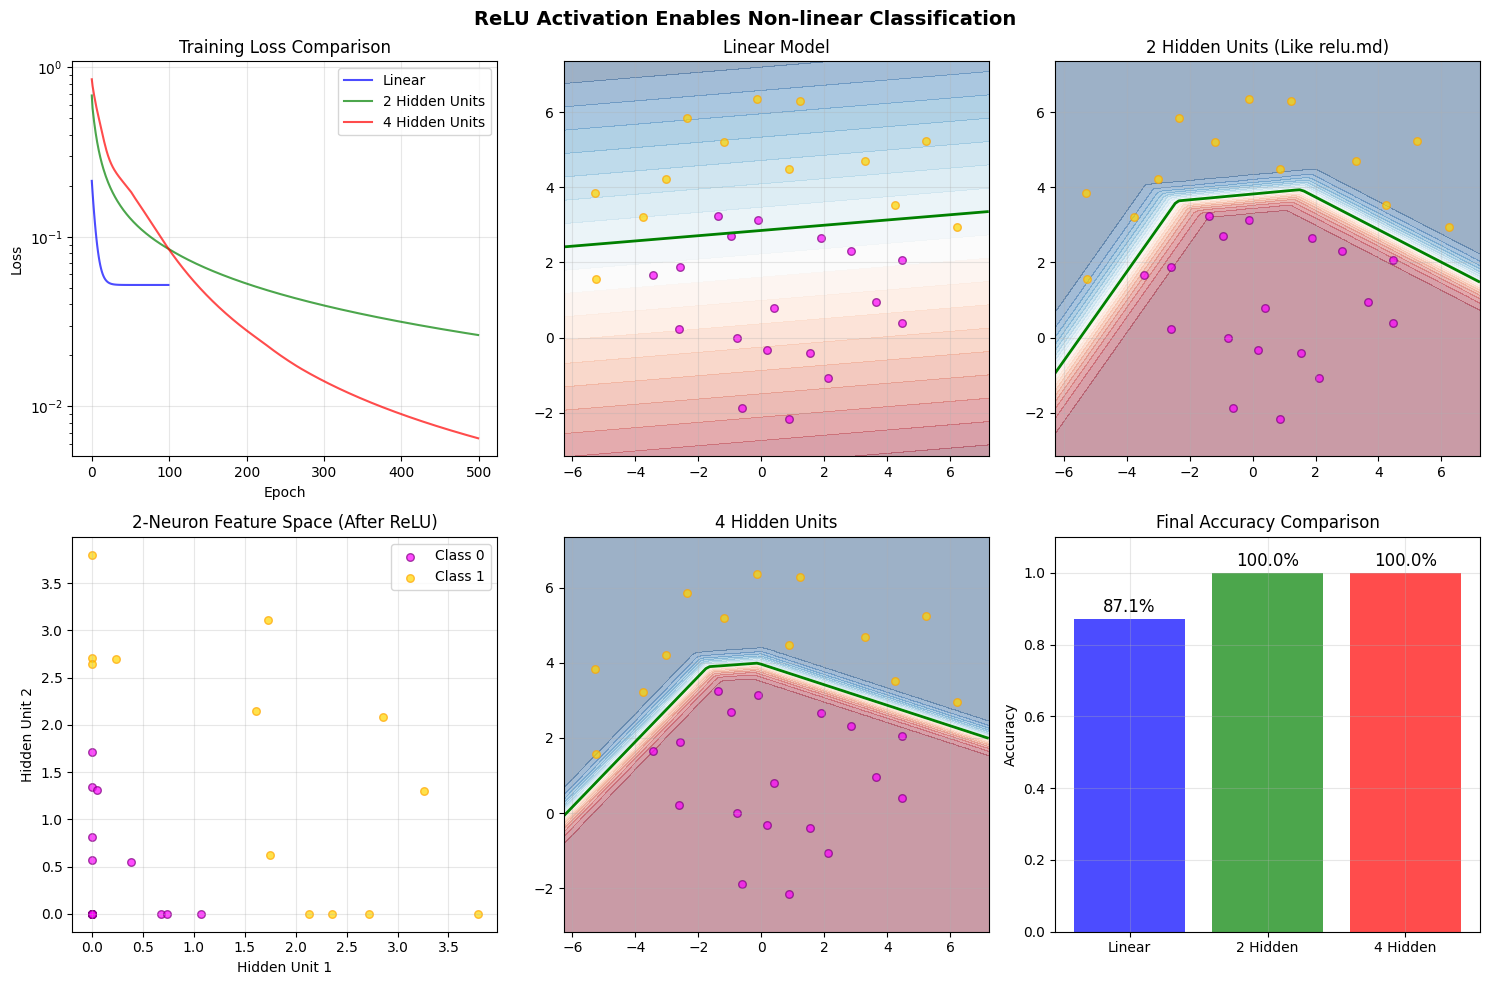

Linear model: 87.1% accuracy
2-neuron model: 100.0% accuracy
4-neuron model: 100.0% accuracy

Final losses - Linear: 0.0520, 2-neuron: 0.0264, 4-neuron: 0.0065


In [87]:
# Two-layer network with just 2 hidden units (matching relu.md solution)
class TwoNeuronNetwork:
    def __init__(self):
        # Initialize with rotation-like pattern (based on relu.md solution: -59 degrees, scale 2)
        angle = -59 * np.pi / 180
        scale = 2.0
        
        # First layer: linear transformation (rotation + scaling)
        self.W1 = np.array([
            [np.cos(angle) * scale, -np.sin(angle) * scale],
            [np.sin(angle) * scale, np.cos(angle) * scale]
        ]).T  # Transpose to match input @ W1 convention
        self.b1 = np.zeros(2)
        
        # Output layer: combine the two ReLU features
        self.W2 = np.random.randn(2, 1) * 0.1
        self.b2 = np.zeros(1)
    
    def relu(self, x):
        return np.maximum(0, x)
    
    def relu_derivative(self, x):
        return (x > 0).astype(float)
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))
    
    def forward(self, X):
        # First layer: linear transformation
        self.z1 = X @ self.W1 + self.b1
        # Apply ReLU activation
        self.a1 = self.relu(self.z1)
        # Output layer
        self.z2 = self.a1 @ self.W2 + self.b2
        self.a2 = self.sigmoid(self.z2)
        return self.a2
    
    def train(self, X, y, epochs=500, lr=0.5):
        losses = []
        for epoch in range(epochs):
            # Forward pass
            output = self.forward(X)
            
            # Compute loss
            eps = 1e-7
            output_clipped = np.clip(output.flatten(), eps, 1 - eps)
            loss = -np.mean(y * np.log(output_clipped) + 
                           (1 - y) * np.log(1 - output_clipped))
            losses.append(loss)
            
            # Backward pass
            m = len(X)
            
            # Output layer gradients
            dz2 = self.a2 - y.reshape(-1, 1)
            dW2 = (self.a1.T @ dz2) / m
            db2 = np.mean(dz2, axis=0)
            
            # Only update output layer (keep transformation fixed for demonstration)
            self.W2 -= lr * dW2
            self.b2 -= lr * db2
            
            # Optional: also train first layer after initial epochs
            if epoch > 100:
                da1 = dz2 @ self.W2.T
                dz1 = da1 * self.relu_derivative(self.z1)
                dW1 = (X.T @ dz1) / m
                db1 = np.mean(dz1, axis=0)
                
                self.W1 -= lr * 0.01 * dW1  # Small learning rate for first layer
                self.b1 -= lr * 0.01 * db1
                
        return losses

# Train the two-neuron network
np.random.seed(42)
model_twoneuron = TwoNeuronNetwork()
losses_twoneuron = model_twoneuron.train(X_nonlinear_norm, y_nonlinear, epochs=500, lr=1.0)

# Also train a properly initialized multi-neuron network for comparison
class OptimizedNetwork:
    def __init__(self, input_dim=2, hidden_dim=4):
        # Better initialization
        self.W1 = np.random.randn(input_dim, hidden_dim) * 0.5
        self.b1 = np.random.randn(hidden_dim) * 0.1
        self.W2 = np.random.randn(hidden_dim, 1) * 0.5
        self.b2 = np.zeros(1)
    
    def relu(self, x):
        return np.maximum(0, x)
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))
    
    def forward(self, X):
        self.z1 = X @ self.W1 + self.b1
        self.a1 = self.relu(self.z1)
        self.z2 = self.a1 @ self.W2 + self.b2
        return self.sigmoid(self.z2)
    
    def train(self, X, y, epochs=500, lr=0.5):
        losses = []
        for epoch in range(epochs):
            # Forward
            output = self.forward(X)
            
            # Loss
            eps = 1e-7
            output_clipped = np.clip(output.flatten(), eps, 1 - eps)
            loss = -np.mean(y * np.log(output_clipped) + 
                           (1 - y) * np.log(1 - output_clipped))
            losses.append(loss)
            
            # Backward
            m = len(X)
            dz2 = output - y.reshape(-1, 1)
            dW2 = (self.a1.T @ dz2) / m
            db2 = np.mean(dz2, axis=0)
            
            da1 = dz2 @ self.W2.T
            dz1 = da1 * (self.z1 > 0)
            dW1 = (X.T @ dz1) / m
            db1 = np.mean(dz1, axis=0)
            
            # Update with momentum
            self.W2 -= lr * dW2
            self.b2 -= lr * db2
            self.W1 -= lr * dW1
            self.b1 -= lr * db1
            
        return losses

model_optimized = OptimizedNetwork(2, 4)
losses_optimized = model_optimized.train(X_nonlinear_norm, y_nonlinear, epochs=500, lr=0.5)

# Visualize all three models
plt.figure(figsize=(15, 10))

# Row 1: Loss curves
plt.subplot(2, 3, 1)
plt.plot(losses_linear, 'b-', label='Linear', alpha=0.7)
plt.plot(losses_twoneuron, 'g-', label='2 Hidden Units', alpha=0.7)
plt.plot(losses_optimized, 'r-', label='4 Hidden Units', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')

# Row 1: Decision boundaries for each model
models = [
    (model_linear, 'Linear Model', plt.subplot(2, 3, 2)),
    (model_twoneuron, '2 Hidden Units (Like relu.md)', plt.subplot(2, 3, 3))
]

for model, title, ax in models:
    plt.sca(ax)
    if hasattr(model, 'predict_batch'):
        Z = model.predict_batch(mesh_norm).reshape(xx.shape)
    else:
        Z = model.forward(mesh_norm).reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, levels=20, cmap='RdBu', alpha=0.4)
    plt.contour(xx, yy, Z, levels=[0.5], colors='g', linewidths=2)
    plt.scatter(class0_X[:,0], class0_X[:,1], c='magenta', s=30, 
               edgecolor='purple', linewidth=1, alpha=0.7)
    plt.scatter(class1_X[:,0], class1_X[:,1], c='gold', s=30, 
               edgecolor='orange', linewidth=1, alpha=0.7)
    plt.title(title)
    plt.grid(True, alpha=0.3)

# Row 2: Feature space visualization
plt.subplot(2, 3, 4)
# Visualize the 2-neuron hidden layer features
hidden_2neuron = model_twoneuron.relu(X_nonlinear_norm @ model_twoneuron.W1 + model_twoneuron.b1)
plt.scatter(hidden_2neuron[y_nonlinear==0, 0], hidden_2neuron[y_nonlinear==0, 1], 
           c='magenta', s=30, edgecolor='purple', linewidth=1, alpha=0.7, label='Class 0')
plt.scatter(hidden_2neuron[y_nonlinear==1, 0], hidden_2neuron[y_nonlinear==1, 1], 
           c='gold', s=30, edgecolor='orange', linewidth=1, alpha=0.7, label='Class 1')
plt.xlabel('Hidden Unit 1')
plt.ylabel('Hidden Unit 2')
plt.title('2-Neuron Feature Space (After ReLU)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 5)
Z_optimized = model_optimized.forward(mesh_norm).reshape(xx.shape)
plt.contourf(xx, yy, Z_optimized, levels=20, cmap='RdBu', alpha=0.4)
plt.contour(xx, yy, Z_optimized, levels=[0.5], colors='g', linewidths=2)
plt.scatter(class0_X[:,0], class0_X[:,1], c='magenta', s=30, 
           edgecolor='purple', linewidth=1, alpha=0.7)
plt.scatter(class1_X[:,0], class1_X[:,1], c='gold', s=30, 
           edgecolor='orange', linewidth=1, alpha=0.7)
plt.title('4 Hidden Units')
plt.grid(True, alpha=0.3)

# Row 2: Accuracy comparison
plt.subplot(2, 3, 6)
linear_acc = np.mean((model_linear.predict_batch(X_nonlinear_norm) > 0.5) == y_nonlinear)
twoneuron_acc = np.mean((model_twoneuron.forward(X_nonlinear_norm).flatten() > 0.5) == y_nonlinear)
optimized_acc = np.mean((model_optimized.forward(X_nonlinear_norm).flatten() > 0.5) == y_nonlinear)

bars = plt.bar(['Linear', '2 Hidden', '4 Hidden'], 
               [linear_acc, twoneuron_acc, optimized_acc],
               color=['blue', 'green', 'red'], alpha=0.7)
plt.ylabel('Accuracy')
plt.title('Final Accuracy Comparison')
plt.ylim(0, 1.1)
for bar, acc in zip(bars, [linear_acc, twoneuron_acc, optimized_acc]):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{acc:.1%}', ha='center', fontsize=12)
plt.grid(True, alpha=0.3, axis='y')

plt.suptitle('ReLU Activation Enables Non-linear Classification', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"Linear model: {linear_acc:.1%} accuracy")
print(f"2-neuron model: {twoneuron_acc:.1%} accuracy") 
print(f"4-neuron model: {optimized_acc:.1%} accuracy")
print(f"\nFinal losses - Linear: {losses_linear[-1]:.4f}, 2-neuron: {losses_twoneuron[-1]:.4f}, 4-neuron: {losses_optimized[-1]:.4f}")

### Backpropagation with Activation Functions

To handle non-linear patterns, we add an activation function $g$:
$$\hat{y} = g(\mathbf{w}^T\mathbf{x} + b)$$

Common choices:
- **Sigmoid**: $\sigma(z) = \frac{1}{1 + e^{-z}}$ — Outputs in (0,1)
- **ReLU**: $\text{ReLU}(z) = \max(0, z)$ — Simple and efficient
- **Tanh**: $\tanh(z) = \frac{e^z - e^{-z}}{e^z + e^{-z}}$ — Outputs in (-1,1)

With activation function $g$, the forward pass becomes:
1. Linear: $z = \mathbf{w}^T\mathbf{x} + b$
2. Activation: $\hat{y} = g(z)$

For backpropagation, we use the chain rule. Given loss $L = \frac{1}{2}(y - \hat{y})^2$:

**Step 1: Error at output**
$$\delta = \frac{\partial L}{\partial \hat{y}} = -(y - \hat{y})$$

**Step 2: Error before activation**
$$\frac{\partial L}{\partial z} = \frac{\partial L}{\partial \hat{y}} \cdot \frac{\partial \hat{y}}{\partial z} = \delta \cdot g'(z)$$

**Step 3: Gradients**
$$\frac{\partial L}{\partial \mathbf{w}} = \frac{\partial L}{\partial z} \cdot \frac{\partial z}{\partial \mathbf{w}} = \delta \cdot g'(z) \cdot \mathbf{x}$$
$$\frac{\partial L}{\partial b} = \delta \cdot g'(z)$$

This is what the `backward` method implements:
```python
def backward(self, y_true):
    error = self.a - y_true           # δ = ŷ - y
    dz = error * self.g_prime(self.z) # δ * g'(z)
    self.w -= self.lr * dz * self.x   # w -= η * ∂L/∂w
    self.b -= self.lr * dz             # b -= η * ∂L/∂b
```


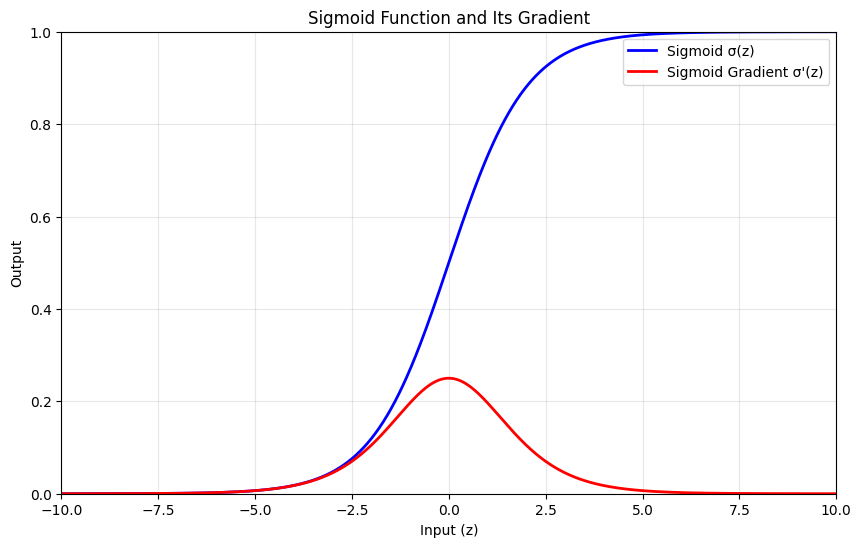

In [88]:
def sigmoid(z):
    return 1 / (1 + np.exp(-np.clip(z, -500, 500)))

def sigmoid_prime(z):
    s = sigmoid(z)
    return s * (1 - s)

# Generate data
z = np.linspace(-10, 10, 1000)
sigmoid_vals = sigmoid(z)
gradient_vals = sigmoid_prime(z)

# Create plot
plt.figure(figsize=(10, 6))
plt.plot(z, sigmoid_vals, 'b-', linewidth=2, label='Sigmoid σ(z)')
plt.plot(z, gradient_vals, 'r-', linewidth=2, label="Sigmoid Gradient σ'(z)")
plt.xlabel('Input (z)')
plt.ylabel('Output')
plt.title('Sigmoid Function and Its Gradient')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xlim(-10, 10)
plt.ylim(0, 1)
plt.show()

In [89]:

class Perceptron:
    def __init__(self, dim, lr=0.01):
        self.w = np.random.randn(dim) * 0.01
        self.b = 0.0
        self.lr = lr
    
    def forward(self, x):
        self.x = x
        self.z = np.dot(x, self.w) + self.b
        self.a = sigmoid(self.z)
        return self.a
    
    def backward(self, y_true):
        # Compute gradients using chain rule
        error = self.a - y_true
        dz = error * sigmoid_prime(self.z)
        
        # Update parameters
        self.w -= self.lr * dz * self.x
        self.b -= self.lr * dz
        
        return 0.5 * error**2

### The Critical Role of Nonlinearity

Why do we need the activation function $g$? What happens if we just use a linear function, like $g(z) = z$?

Consider a network with multiple layers, but *no* non-linear activation functions between them. The output of one layer is just a linear transformation of its input. If we stack these linear layers:

Let the first layer be $h_1 = W_1 x + b_1$.
Let the second layer be $h_2 = W_2 h_1 + b_2$.

Substituting the first into the second:
$$h_2 = W_2 (W_1 x + b_1) + b_2$$
$$h_2 = W_2 W_1 x + W_2 b_1 + b_2$$

This can be rewritten as:
$$h_2 = (W_2 W_1) x + (W_2 b_1 + b_2)$$

Let $W_{eq} = W_2 W_1$ and $b_{eq} = W_2 b_1 + b_2$. Then:
$$h_2 = W_{eq} x + b_{eq}$$

This is just another linear transformation! No matter how many linear layers we stack, the entire network will only be able to compute a single linear function of the input. A linear network can only learn:

> Linear network can only learn: y = mx + b (a straight line in 1D)
> But sin(πx) is curved - impossible with just linear transformations!

To approximate complex, non-linear functions like $\sin(\pi x)$, we **must** introduce non-linearity using activation functions between the layers.

Epoch 0: Loss = 0.234887
Epoch 500: Loss = 0.099670
Epoch 1000: Loss = 0.099670
Epoch 1500: Loss = 0.099670
Epoch 2000: Loss = 0.099670
Epoch 2500: Loss = 0.099670


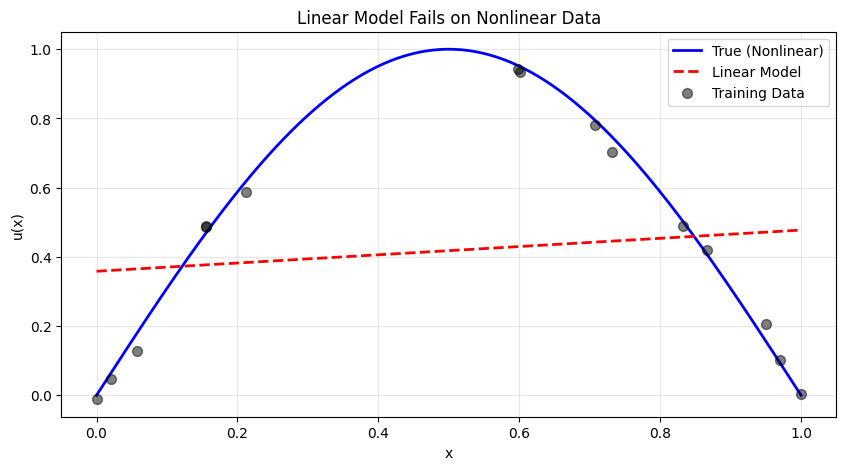

Linear model can only fit a straight line to nonlinear data!
Final MSE: 0.1439


In [90]:
# Demonstrate Linear Network Failure
class LinearNetwork(nn.Module):
    """A simple network with only linear layers (no activation)"""
    def __init__(self, width):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, width),
            nn.Linear(width, 1)      # Final linear layer
        )
    
    def forward(self, x):
        return self.layers(x)

# Prepare training data as tensors (using both naming conventions for compatibility)
x_train_tensor = torch.FloatTensor(x_train.reshape(-1, 1))
y_train_tensor = torch.FloatTensor(y_train.reshape(-1, 1))
u_train_tensor = y_train_tensor  # Alias for compatibility with later cells

# Also create test tensors for evaluation
x_test_tensor = torch.FloatTensor(x_test.reshape(-1, 1))
y_test_tensor = torch.FloatTensor(y_exact.reshape(-1, 1))
u_test_tensor = y_test_tensor  # Alias for compatibility

# Create a simple linear model (no hidden layer, just for comparison)
linear_model = nn.Linear(1, 1)
criterion = nn.MSELoss()
optimizer = optim.Adam(linear_model.parameters(), lr=0.01)

epochs = 3000
for epoch in range(epochs):
    predictions = linear_model(x_train_tensor)
    loss = criterion(predictions, y_train_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")

# Test linear model
linear_pred = linear_model(x_test_tensor).detach().numpy().flatten()

# Compare linear vs nonlinear data
plt.figure(figsize=(10, 5))
plt.plot(x_test, y_exact, 'b-', linewidth=2, label='True (Nonlinear)')
plt.plot(x_test, linear_pred, 'r--', linewidth=2, label='Linear Model')
plt.scatter(x_train, y_train, s=50, c='black', zorder=5, alpha=0.5, label='Training Data')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.title('Linear Model Fails on Nonlinear Data')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Linear model can only fit a straight line to nonlinear data!")
print(f"Final MSE: {np.mean((linear_pred - y_exact)**2):.4f}")

#### Nonlinear Activation Functions

Activation functions are applied element-wise to the output of a linear transformation within a neuron or layer. They introduce the non-linearity required for neural networks to learn complex mappings.

Some common activation functions include:

**Sigmoid**
Squashes input to (0, 1). Useful for binary classification output. Can suffer from vanishing gradients.
$$ \sigma(x) = \frac{1}{1 + e^{-x}} $$

**Tanh**
Squashes input to (-1, 1). Zero-centered, often preferred over Sigmoid for hidden layers. Can also suffer from vanishing gradients.
$$\tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}} $$

**ReLU (Rectified Linear Unit)**
Outputs input directly if positive, zero otherwise. Computationally efficient, helps mitigate vanishing gradients for positive inputs. Can suffer from "dead neurons" if inputs are always negative.
$$ f(x) = \max(0, x)$$

**LeakyReLU**
Similar to ReLU but allows a small gradient for negative inputs, preventing dead neurons.
$$f(x) = \max(\alpha x, x) \quad (\alpha \text{ is a small positive constant, e.g., 0.01})$$

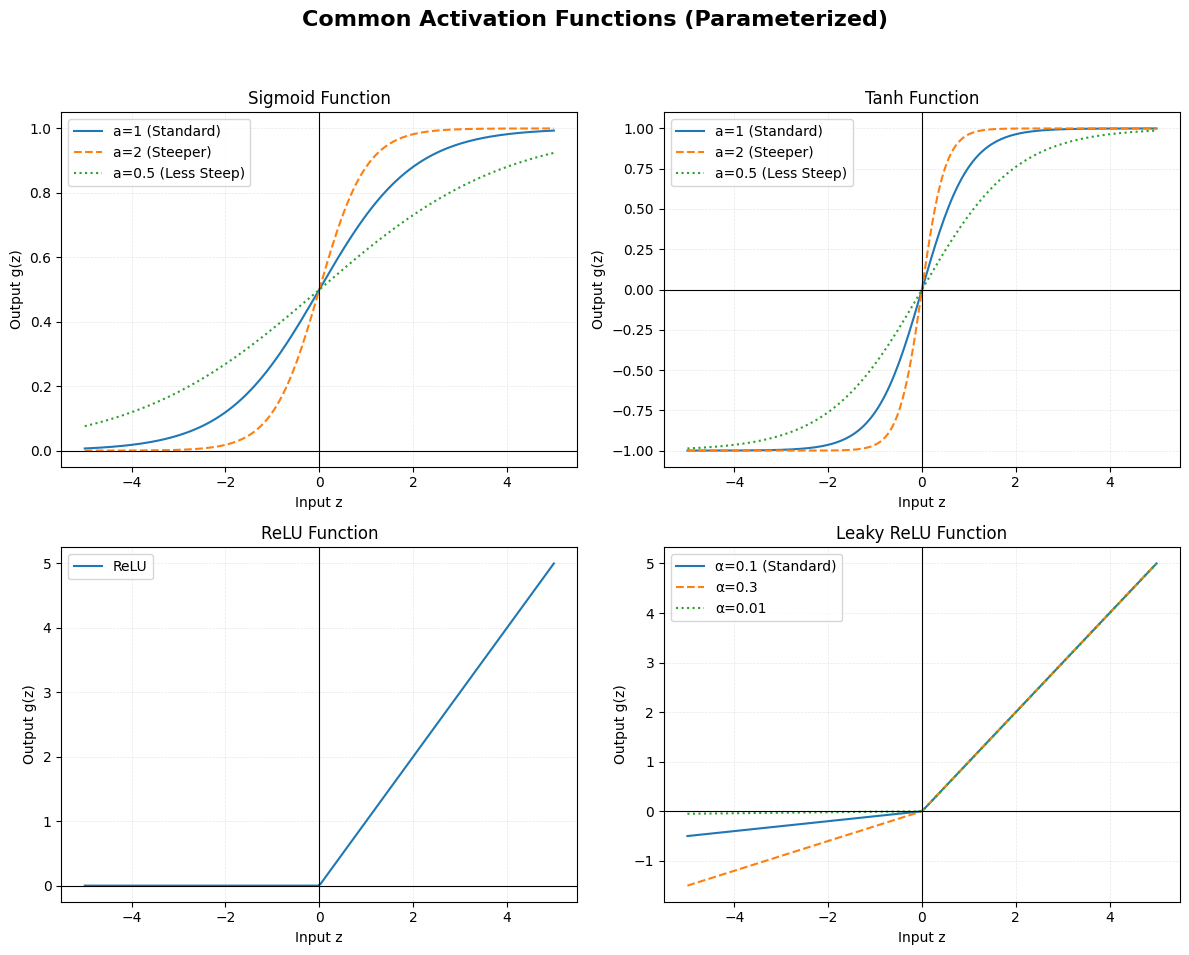

In [91]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Parameterized Activation Functions ---

def sigmoid(x, a=1.0):
    """
    Parameterized Sigmoid activation function.
    'a' controls the steepness.
    """
    return 1 / (1 + np.exp(-a * x))

def tanh(x, a=1.0):
    """
    Parameterized Hyperbolic Tangent activation function.
    'a' controls the steepness.
    """
    return np.tanh(a * x)

def relu(x):
    """
    Rectified Linear Unit (ReLU) activation function.
    It has no parameters.
    """
    return np.maximum(0, x)

def leaky_relu(x, alpha=0.1):
    """
    Parameterized Leaky ReLU activation function.
    'alpha' is the slope for negative inputs.
    """
    return np.maximum(alpha * x, x)

# --- 2. Setup for Plotting ---

# Input data range
x = np.linspace(-5, 5, 200)

# Create a 2x2 subplot grid
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Common Activation Functions (Parameterized)', fontsize=16, fontweight='bold')

# --- 3. Plotting each function on its subplot ---

# Sigmoid Plot (Top-Left)
axs[0, 0].plot(x, sigmoid(x, a=1), label='a=1 (Standard)')
axs[0, 0].plot(x, sigmoid(x, a=2), label='a=2 (Steeper)', linestyle='--')
axs[0, 0].plot(x, sigmoid(x, a=0.5), label='a=0.5 (Less Steep)', linestyle=':')
axs[0, 0].set_title('Sigmoid Function')
axs[0, 0].legend()

# Tanh Plot (Top-Right)
axs[0, 1].plot(x, tanh(x, a=1), label='a=1 (Standard)')
axs[0, 1].plot(x, tanh(x, a=2), label='a=2 (Steeper)', linestyle='--')
axs[0, 1].plot(x, tanh(x, a=0.5), label='a=0.5 (Less Steep)', linestyle=':')
axs[0, 1].set_title('Tanh Function')
axs[0, 1].legend()

# ReLU Plot (Bottom-Left)
axs[1, 0].plot(x, relu(x), label='ReLU')
axs[1, 0].set_title('ReLU Function')
axs[1, 0].legend()

# Leaky ReLU Plot (Bottom-Right)
axs[1, 1].plot(x, leaky_relu(x, alpha=0.1), label='α=0.1 (Standard)')
axs[1, 1].plot(x, leaky_relu(x, alpha=0.3), label='α=0.3', linestyle='--')
axs[1, 1].plot(x, leaky_relu(x, alpha=0.01), label='α=0.01', linestyle=':')
axs[1, 1].set_title('Leaky ReLU Function')
axs[1, 1].legend()

# --- 4. Final Touches for all subplots ---

# Apply common labels, grids, and axis lines to all subplots
for ax in axs.flat:
    ax.set_xlabel('Input z')
    ax.set_ylabel('Output g(z)')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.axhline(y=0, color='k', linewidth=0.8)
    ax.axvline(x=0, color='k', linewidth=0.8)

# Adjust layout to prevent titles and labels from overlapping
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Display the plot
plt.show()


### Building Capacity: The Single Hidden Layer Neural Network

A single perceptron is limited in the complexity of functions it can represent. To increase capacity, we combine multiple perceptrons into a **layer**. A single-layer feedforward neural network (also known as a shallow Multi-Layer Perceptron or MLP) consists of an input layer, one hidden layer of neurons, and an output layer.

For our 1D input $x$, a single-layer network with $N_h$ hidden neurons works as follows:

1.  **Input Layer**: Receives the input $x$.
2.  **Hidden Layer**: Each of the $N_h$ neurons in this layer performs a linear transformation on the input $x$ and applies a non-linear activation function $g$. The output of this layer is a vector $\boldsymbol{h}$ of size $N_h$.
    *   Pre-activation vector $\boldsymbol{z}^{(1)}$ (size $N_h$): $\boldsymbol{z}^{(1)} = W^{(1)}\boldsymbol{x} + \boldsymbol{b}^{(1)}$
        (Here, $W^{(1)}$ is a $N_h \times 1$ weight matrix, $\boldsymbol{x}$ is treated as a $1 \times 1$ vector, and $\boldsymbol{b}^{(1)}$ is a $N_h \times 1$ bias vector).
    *   Activation vector $\boldsymbol{h}$ (size $N_h$): $\boldsymbol{h} = g(\boldsymbol{z}^{(1)})$ (where $g$ is applied element-wise).
3.  **Output Layer**: This layer takes the vector $\boldsymbol{h}$ from the hidden layer and performs another linear transformation to produce the final scalar output $\hat{y}$. For regression, the output layer typically has a linear activation (or no activation function explicitly applied after the linear transformation).
    *   Pre-activation scalar $z^{(2)}$: $z^{(2)} = W^{(2)}\boldsymbol{h} + b^{(2)}$
        (Here, $W^{(2)}$ is a $1 \\times N_h$ weight matrix, and $b^{(2)}$ is a scalar bias).
    *   Final output $\hat{y}$: $\hat{y} = z^{(2)}$

![Single layer NN](figs/single-layer-nn2.png?raw=true)

> Credits: Alexander Amini, MIT

In [92]:
# Implement Single-Layer NN in PyTorch

class SingleLayerNN(nn.Module):
    """Single hidden layer neural network for 1D input/output"""
    
    def __init__(self, hidden_size=10):
        super(SingleLayerNN, self).__init__()
        
        # Input layer (1D) to Hidden layer (hidden_size)
        self.hidden = nn.Linear(1, hidden_size)
        
        # Hidden layer (hidden_size) to Output layer (1D)
        self.output = nn.Linear(hidden_size, 1)
        
        # Choose activation function for the hidden layer
        self.activation = nn.Tanh()
    
    def forward(self, x):
        # Pass through hidden layer and apply activation
        x = self.hidden(x)
        x = self.activation(x)
        
        # Pass through output layer (linear output)
        x = self.output(x)
        return x

> Let's try to plot before training

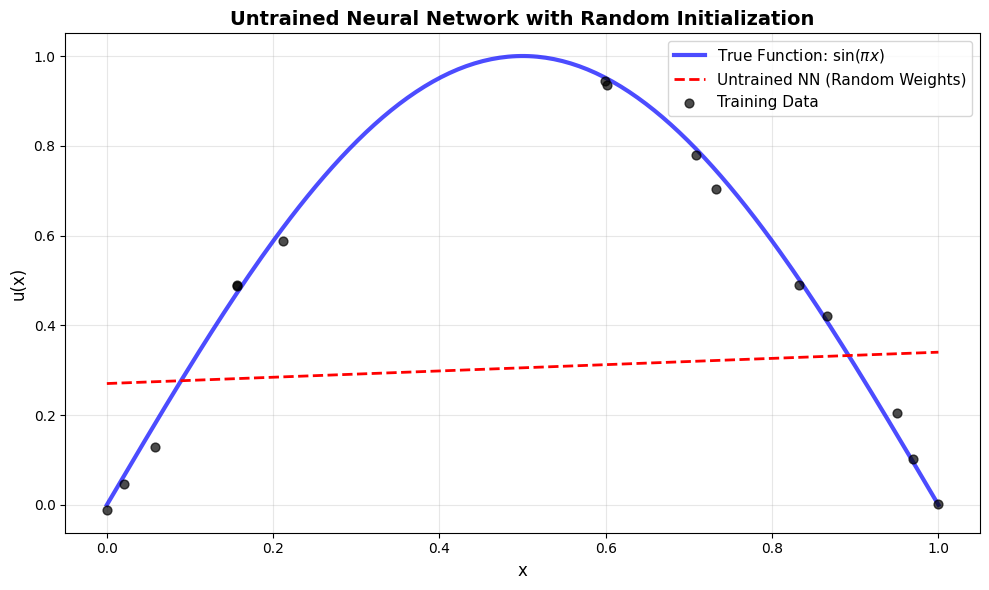

Note: The untrained network produces random output due to random weight initialization.


In [93]:
# Define variables for compatibility with legacy code
x_plot = x_test  # Use the test grid we already defined
u_analytical_plot = y_exact  # The true function values
x_train_np = x_train  # Training x values
u_train_noisy_np = y_train  # Training y values with noise

# Define SingleLayerNN if not already defined
class SingleLayerNN(nn.Module):
    """Single hidden layer neural network for 1D input/output"""
    
    def __init__(self, hidden_size=10):
        super(SingleLayerNN, self).__init__()
        self.hidden = nn.Linear(1, hidden_size)
        self.output = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        x = torch.sigmoid(self.hidden(x))
        return self.output(x)

model = SingleLayerNN(10)

# Visualize the untrained network's prediction
x_test_tensor_plot = torch.tensor(x_plot.reshape(-1, 1), dtype=torch.float32)
with torch.no_grad():
    u_pred_linear = model(x_test_tensor_plot).numpy().flatten()

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(x_plot, u_analytical_plot, 'b-', linewidth=3, label='True Function: $\\sin(\\pi x)$', alpha=0.7)
ax.plot(x_plot, u_pred_linear, 'r--', linewidth=2, label='Untrained NN (Random Weights)')
ax.scatter(x_train_np, u_train_noisy_np, color='k', s=40, alpha=0.7, label='Training Data', zorder=5)

ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('u(x)', fontsize=12)
ax.set_title('Untrained Neural Network with Random Initialization', fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Note: The untrained network produces random output due to random weight initialization.")

### Training a neural network

Neural networks are trained using an optimization algorithm that iteratively updates the network's weights and biases to minimize a loss function. The loss function measures how far the network's predictions are from the true target outputs in the training data. It is a measure of the model's error.

We quantify this difference using a **Loss Function**, Some common loss functions include:

* Mean squared error (MSE) - The average of the squared differences between the predicted and actual values. Measures the square of the error. Used for regression problems.

* Cross-entropy loss - Measures the divergence between the predicted class probabilities and the true distribution. Used for classification problems. Penalizes confident incorrect predictions.

* Hinge loss - Used for Support Vector Machines classifiers. Penalizes predictions that are on the wrong side of the decision boundary.

For our function approximation (regression) task, the Mean Squared Error (MSE) is a common choice:

$$\mathcal{L}(\theta) = \frac{1}{N} \sum_{i=1}^N \left(u_{NN}(x_i; \theta) - u_i\right)^2$$

Minimizing this loss function with respect to the parameters $\theta$ is an optimization problem.


Loss optimization is the process of finding the network weights that acheives the lowest loss.

$$ 
\begin{align}
\boldsymbol{w^*} &= \argmin_{\boldsymbol{w}}\frac{1}{n}\sum_{i=1}^n \mathcal{L}(f(x^{(i)};\boldsymbol{w}),y^{(i)})\\
\boldsymbol{w^*} &= \argmin_{\boldsymbol{w}} J(\boldsymbol{w})
\end{align}
$$

The training process works like this:

1. **Initialization**: The weights and biases of the network are initialized, often with small random numbers.

2. **Forward Pass**: The input is passed through the network, layer by layer, applying the necessary transformations (e.g., linear combinations of weights and inputs followed by activation functions) until an output is obtained.

3. **Calculate Loss**: A loss function is used to quantify the difference between the predicted output and the actual target values.

4. **Backward Pass (Backpropagation)**: The gradients of the loss with respect to the parameters (weights and biases) are computed using the chain rule for derivatives. This process is known as backpropagation.

5. **Update Parameters**: The gradients computed in the backward pass are used to update the parameters of the network, typically using optimization algorithms like stochastic gradient descent (SGD) or more sophisticated ones like Adam. The update is done in the direction that minimizes the loss.

6. **Repeat**: Steps 2-5 are repeated using the next batch of data until a stopping criterion is met, such as a set number of epochs (full passes through the training dataset) or convergence to a minimum loss value.

7. **Validation**: The model is evaluated on a separate validation set to assess its generalization to unseen data.

The goal of training is to find the optimal set of weights and biases $\theta^*$ for the network that minimize the difference between the network's output $u_{NN}(x; \theta)$ and the true training data $u_{train}$.

### Computing gradients with Automatic Differentiation

> The Core Insight: Functions Are Computational Graphs

Every computer program that evaluates a mathematical function can be viewed as a **computational graph**. Consider this simple function:

[![Button](https://img.shields.io/badge/Go%20to-Interactive%20Demo-blue?style=for-the-badge&logo=airplayvideo&logoColor=white)](../ad)

In [94]:
def f(x1, x2):
    y = x1**2 + x2
    return y

This creates a computational graph where each operation is a node. This decomposition is the key insight that makes automatic differentiation possible.

![AD forward pass](figs/ad3.png)

### Forward Mode Automatic Differentiation

Forward mode AD computes derivatives by propagating derivative information **forward** through the computational graph, following the same path as the function evaluation.

![AD forward evaluation](figs/forward-mode-ad.png)

#### Forward Mode: Computing $\frac{\partial y}{\partial x_1}$

Starting with our function $y = x_1^2 + x_2$, let's trace through the computation:

1. **Seed the input**: Set $\dot{x}_1 = 1$ and $\dot{x}_2 = 0$ (we're differentiating w.r.t. $x_1$)

2. **Forward propagation**:
   - $v_1 = x_1^2$, so $\dot{v}_1 = 2x_1 \cdot \dot{x}_1 = 2x_1 \cdot 1 = 2x_1$
   - $y = v_1 + x_2$, so $\dot{y} = \dot{v}_1 + \dot{x}_2 = 2x_1 + 0 = 2x_1$

3. **Result**: $\frac{\partial y}{\partial x_1} = 2x_1$

#### Forward Mode: Computing $\frac{\partial y}{\partial x_2}$

To get the derivative w.r.t. $x_2$, we seed differently:

1. **Seed the input**: Set $\dot{x}_1 = 0$ and $\dot{x}_2 = 1$

2. **Forward propagation**:
   - $v_1 = x_1^2$, so $\dot{v}_1 = 2x_1 \cdot \dot{x}_1 = 2x_1 \cdot 0 = 0$
   - $y = v_1 + x_2$, so $\dot{y} = \dot{v}_1 + \dot{x}_2 = 0 + 1 = 1$

3. **Result**: $\frac{\partial y}{\partial x_2} = 1$

**Key insight**: Forward mode requires one pass per input variable to compute all partial derivatives.

### Reverse Mode Automatic Differentiation

Reverse mode AD (also called **backpropagation**) computes derivatives by propagating derivative information **backward** through the computational graph.

#### The Backward Pass Algorithm

1. **Forward pass**: Compute function values and store intermediate results
2. **Seed the output**: Set $\bar{y} = 1$ (derivative of output w.r.t. itself)
3. **Backward pass**: Use the chain rule to propagate derivatives backward

![Final chain rule AD](figs/ad7.png)

#### Computing All Partial Derivatives in One Pass

The beauty of reverse mode is that it computes **all** partial derivatives in a single backward pass:

1. **Forward pass**: $y = x_1^2 + x_2$ (store intermediate values)

2. **Backward pass with $\bar{y} = 1$**:
   - $\frac{\partial y}{\partial x_1} = \frac{\partial y}{\partial v_1} \cdot \frac{\partial v_1}{\partial x_1} = 1 \cdot 2x_1 = 2x_1$
   - $\frac{\partial y}{\partial x_2} = \frac{\partial y}{\partial x_2} = 1$

**Key insight**: Reverse mode computes gradients w.r.t. all inputs in a single backward pass!

### AD: The Mathematical Foundation

Automatic differentiation works because of a fundamental theorem:

**Chain Rule**: For composite functions $f(g(x))$:
$$\frac{d}{dx}f(g(x)) = f'(g(x)) \cdot g'(x)$$

By systematically applying the chain rule to each operation in a computational graph, AD can compute exact derivatives for arbitrarily complex functions.

### Automatic Differentiation in Practice: PyTorch

Let's see how automatic differentiation works in PyTorch:

In [95]:
import torch

# Define variables that require gradients
x1 = torch.tensor(2.0, requires_grad=True)
x2 = torch.tensor(3.0, requires_grad=True)

# Define the function
y = x1**2 + x2

# Compute gradients using reverse mode AD
y.backward()

# Access the computed gradients
print(f"dy/dx1: {x1.grad.item()}")  # Should be 2*x1 = 4.0
print(f"dy/dx2: {x2.grad.item()}")  # Should be 1.0

dy/dx1: 4.0
dy/dx2: 1.0


### A More Complex Example: Neural Network

In [96]:
import torch
import torch.nn as nn

# Implement Single-Layer NN in PyTorch

class SingleLayerNN(nn.Module):
    """Single hidden layer neural network for 1D input/output"""
    
    def __init__(self, hidden_size=10):
        super(SingleLayerNN, self).__init__()
        self.hidden = nn.Linear(1, hidden_size)
        self.output = nn.Linear(hidden_size, 1)
        self.activation = nn.Tanh()
    
    def forward(self, x):
        # Forward pass
        x = self.hidden(x)
        x = self.activation(x)
        x = self.output(x)
        return x

# Create network and data
model = SingleLayerNN(hidden_size=10)

# Define MSE loss
criterion = nn.MSELoss() 

# Forward pass: compute predictions
predictions = model(x_train_tensor)
    
# Calculate loss (((output - target)**2).mean())
loss = criterion(predictions, u_train_tensor)
    
# Backward pass: compute gradients
loss.backward()       # Compute gradients of the loss w.r.t. parameters

# Access gradients
for name, param in model.named_parameters():
    print(f"{name}: gradient shape {param.grad.shape}")

hidden.weight: gradient shape torch.Size([10, 1])
hidden.bias: gradient shape torch.Size([10])
output.weight: gradient shape torch.Size([1, 10])
output.bias: gradient shape torch.Size([1])


### When to Use Forward vs Reverse Mode

The choice depends on the structure of your problem:

- **Forward Mode**: Efficient when **few inputs, many outputs** (e.g., $f: \mathbb{R}^n \to \mathbb{R}^m$ with $n \ll m$)
- **Reverse Mode**: Efficient when **many inputs, few outputs** (e.g., $f: \mathbb{R}^n \to \mathbb{R}^m$ with $n \gg m$)

In machine learning, we typically have millions of parameters (inputs) and a single loss function (output), making reverse mode the natural choice.

### Computational Considerations

#### Memory vs Computation Trade-offs

**Forward Mode**:
- Memory: O(1) additional storage
- Computation: O(n) for n input variables

**Reverse Mode**:
- Memory: O(computation graph size)
- Computation: O(1) for any number of input variables

#### Modern Optimizations

1. **Checkpointing**: Trade computation for memory by recomputing intermediate values
2. **JIT compilation**: Compile computational graphs for faster execution
3. **Parallelization**: Distribute gradient computation across multiple devices

### Gradient Descent
Gradient Descent is a first-order iterative optimization algorithm used to find the minimum of a differentiable function. In the context of training a neural network, we are trying to minimize the loss function. 

1. **Initialize Parameters**:

Choose an initial point (i.e., initial values for the weights and biases) in the parameter space, and set a learning rate that determines the step size in each iteration.

2. **Compute the Gradient**:

Calculate the gradient of the loss function with respect to the parameters at the current point. The gradient is a vector that points in the direction of the steepest increase of the function. It is obtained by taking the partial derivatives of the loss function with respect to each parameter.

3. **Update Parameters**:

Move in the opposite direction of the gradient by a distance proportional to the learning rate. This is done by subtracting the gradient times the learning rate from the current parameters:

$$\boldsymbol{w} = \boldsymbol{w} - \eta \nabla J(\boldsymbol{w})$$

Here, $\boldsymbol{w}$ represents the parameters, $\eta$ is the learning rate, and $\nabla J (\boldsymbol{w})$ is the gradient of the loss function $J$ with respect to $\boldsymbol{w}$.

4. **Repeat**:

Repeat steps 2 and 3 until the change in the loss function falls below a predefined threshold, or a maximum number of iterations is reached.

#### Algorithm:

1. Initialize weights randomly $\sim \mathcal{N}(0, \sigma^2)$
2. Loop until convergence
3.   Compute gradient, $\frac{\partial J(\boldsymbol{w})}{\partial \boldsymbol{w}}$
4.   Update weights, $\boldsymbol{w} \leftarrow \boldsymbol{w} - \eta \frac{\partial J(\boldsymbol{w})}{\partial \boldsymbol{w}}$
5. Return weights

![SGD](figs/sgd.gif)

Assuming a loss function is mean squared error (MSE). Let's compute the gradient of the loss with respect to the input weights. 

The loss function is mean squared error:

$$\text{loss} = \frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2$$

Where $y_i$ are the true target and $\hat{y}_i$ are the predicted values.

To minimize this loss, we need to compute the gradients with respect to the weights $\mathbf{w}$ and bias $b$:

Using the chain rule, the gradient of the loss with respect to the weights is:
$$\frac{\partial \text{loss}}{\partial \mathbf{w}} = \frac{2}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i) \frac{\partial y_i}{\partial \mathbf{w}}$$

The term inside the sum is the gradient of the loss with respect to the output $y_i$, which we called $\text{grad\_output}$:
$$\text{grad\_output} = \frac{2}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)$$

The derivative $\frac{\partial y_i}{\partial \mathbf{w}}$ is just the input $\mathbf{x}_i$ multiplied by the derivative of the activation. For simplicity, let's assume linear activation, so this is just $\mathbf{x}_i$:

$$\therefore \frac{\partial \text{loss}}{\partial \mathbf{w}} = \mathbf{X}^T\text{grad\_output}$$

The gradient for the bias is simpler:
$$\frac{\partial \text{loss}}{\partial b} = \sum_{i=1}^{n}\text{grad\_output}_i$$

Finally, we update the weights and bias by gradient descent:

$$\mathbf{w} = \mathbf{w} - \eta \frac{\partial \text{loss}}{\partial \mathbf{w}}$$

$$b = b - \eta \frac{\partial \text{loss}}{\partial b}$$

Where $\eta$ is the learning rate.

#### Variants:

There are several variants of Gradient Descent that modify or enhance these basic steps, including:

- **Stochastic Gradient Descent (SGD)**: Instead of using the entire dataset to compute the gradient, SGD uses a single random data point (or small batch) at each iteration. This adds noise to the gradient but often speeds up convergence and can escape local minima.

- **Momentum**: Momentum methods use a moving average of past gradients to dampen oscillations and accelerate convergence, especially in cases where the loss surface has steep valleys.

- **Adaptive Learning Rate Methods**: Techniques like Adagrad, RMSprop, and Adam adjust the learning rate individually for each parameter, often leading to faster convergence.

#### Limitations:

* It may converge to a local minimum instead of a global minimum if the loss surface is not convex.
* Convergence can be slow if the learning rate is not properly tuned.
* Sensitive to the scaling of features; poorly scaled data can cause the gradient descent to take a long time to converge or even diverge.

#### Effect of learning rate

The learning rate in gradient descent is a critical hyperparameter that can significantly influence the model's training dynamics. Let us now look at how the learning rate affects local minima, overshooting, and convergence:

1. Effect on Local Minima:

- High Learning Rate: A large learning rate can help the model escape shallow local minima, leading to the discovery of deeper (potentially global) minima. However, it can also cause instability, making it hard to settle in a good solution.

- Low Learning Rate: A small learning rate may cause the model to get stuck in local minima, especially in complex loss landscapes with many shallow valleys. The model can lack the "energy" to escape these regions.

2. Effect on Overshooting:

- High Learning Rate: If the learning rate is set too high, the updates may be so large that they overshoot the minimum and cause the algorithm to diverge, or oscillate back and forth across the valley without ever reaching the bottom. This oscillation can be detrimental to convergence.
   
- Low Learning Rate: A very low learning rate will likely avoid overshooting but may lead to extremely slow convergence, as the updates to the parameters will be minimal. It might result in getting stuck in plateau regions where the gradient is small.

3. Effect on Convergence:

- High Learning Rate: While it can speed up convergence initially, a too-large learning rate risks instability and divergence, as mentioned above. The model may never converge to a satisfactory solution.
   
- Low Learning Rate: A small learning rate ensures more stable and reliable convergence but can significantly slow down the process. If set too low, it may also lead to premature convergence to a suboptimal solution.

##### Finding the Right Balance:

Choosing the right learning rate is often a trial-and-error process, sometimes guided by techniques like learning rate schedules or adaptive learning rate algorithms like Adam. These approaches attempt to balance the trade-offs by adjusting the learning rate throughout training, often starting with larger values to escape local minima and avoid plateaus, then reducing it to stabilize convergence.


[![Button](https://img.shields.io/badge/Go%20to-Interactive%20Demo:SGD-blue?style=for-the-badge&logo=airplayvideo&logoColor=white)](../sgd)

In [97]:
# Implement PyTorch Training Loop Function
def train_network(model, x_train, u_train, epochs=5000, lr=0.01):
    """Train a neural network model using MSE loss and Adam optimizer"""
    criterion = nn.MSELoss() # Mean Squared Error Loss
    optimizer = optim.Adam(model.parameters(), lr=lr) # Adam optimizer
    
    losses = []
    
    for epoch in range(epochs):
        # Forward pass: compute predictions
        predictions = model(x_train)
        
        # Calculate loss
        loss = criterion(predictions, u_train)
        
        # Backward pass: compute gradients
        optimizer.zero_grad() # Clear previous gradients
        loss.backward()       # Compute gradients of the loss w.r.t. parameters
        
        # Optimizer step: update parameters
        optimizer.step()      # Perform a single optimization step
        
        losses.append(loss.item())
        
        # Optional: Print loss periodically
        # if (epoch + 1) % 1000 == 0:
        #     print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}')
    
    return losses

In [ ]:
hidden_size = 10

model = SingleLayerNN(hidden_size=hidden_size)

# Train the model
losses = train_network(model, x_train_tensor, u_train_tensor, epochs=8000, lr=0.01)

# Handle both tensor and scalar cases for the loss
final_loss = losses[-1].item() if hasattr(losses[-1], 'item') else float(losses[-1])
print(f"Final loss for {hidden_size} neurons: {final_loss:.6f}")

# Get predictions from the trained model
x_plot = x_test  # Use our test grid
x_test_tensor_plot = torch.tensor(x_plot.reshape(-1, 1), dtype=torch.float32)
u_analytical_plot = y_exact  # True function values

with torch.no_grad():
    u_pred = model(x_test_tensor_plot).numpy().flatten()

# Plotting
# Plot true function
plt.plot(x_plot, u_analytical_plot, 'k-', linewidth=3, label='True Function', alpha=0.8)

# Plot NN prediction
plt.plot(x_plot, u_pred, 'b-', linewidth=2.5, 
        label=f'NN ({hidden_size} neurons)')

# Plot training data points
plt.scatter(x_train, y_train, color='red', s=40, alpha=0.7, 
            label='Training Data', zorder=5)

plt.xlabel('x', fontsize=12)
plt.ylabel('u(x)', fontsize=12)
plt.title(f'Single Hidden Layer NN: {hidden_size} Neurons', fontsize=14, fontweight='bold')
plt.legend(fontsize=11, loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate errors
train_pred = model(x_train_tensor).detach().numpy().flatten()
train_error = np.mean((train_pred - y_train)**2)
test_error = np.mean((u_pred - u_analytical_plot)**2)

print(f"Training MSE: {train_error:.6f}")
print(f"Test MSE: {test_error:.6f}")

## Part 4: Universal Approximation Theorem: The Mathematical Foundation

The Universal Approximation Theorem (UAT) is the theoretical cornerstone that explains why neural networks are so powerful for function approximation. It guarantees that with enough neurons, a single-hidden-layer network can approximate any continuous function to arbitrary accuracy.

### What the Theorem States

**Universal Approximation Theorem (Cybenko, 1989; Hornik, 1991):**
A feedforward neural network with:
- A single hidden layer
- Finite number of neurons
- Non-polynomial activation function (e.g., sigmoid, ReLU, tanh)

Can approximate any continuous function on a compact subset of ℝⁿ to arbitrary accuracy.

Mathematically: Neural networks form a **dense subset** in C([a,b]) - the space of continuous functions on [a,b].

### Why This Matters for Scientific Machine Learning

1. **PDE Solutions**: Most PDE solutions are continuous functions, so neural networks can represent them
2. **Data Fitting**: Any smooth experimental data can be approximated
3. **Surrogate Modeling**: Complex simulations can be replaced with neural network approximators
4. **Theoretical Guarantee**: We know the approximation is *possible* (though not how to find it)

### Interactive Exploration

Explore how neural networks build complex functions from simple components:

[![Interactive Demo](https://img.shields.io/badge/Go%20to-Interactive%20Demo:UAT-blue?style=for-the-badge)](./uat-demo)

The interactive demo includes:
- **ReLU decomposition** - See how ReLU units combine to approximate functions
- **Step function construction** - Watch as more neurons improve approximation
- **Activation comparison** - Compare ReLU, sigmoid, and non-universal activations

### Mathematical Foundations: Function Spaces

To understand what neural networks can approximate, we need a mathematical framework for measuring "closeness" between functions.

#### Banach Spaces: The Setting for Approximation

A **Banach space** is a complete normed vector space. For our purposes:

1. **Vector Space of Functions**: We can add functions and multiply by scalars
   - $(f + g)(x) = f(x) + g(x)$
   - $(\alpha f)(x) = \alpha \cdot f(x)$

2. **Norm**: A way to measure the "size" of a function
   - $L^\infty$ norm (supremum): $\|f\|_\infty = \sup_{x \in [a,b]} |f(x)|$
   - $L^2$ norm: $\|f\|_2 = \left(\int_a^b |f(x)|^2 dx\right)^{1/2}$
   - $L^1$ norm: $\|f\|_1 = \int_a^b |f(x)| dx$

3. **Completeness**: Cauchy sequences converge to a limit in the space

#### Hilbert Spaces: Adding Geometry

A **Hilbert space** is a Banach space with an inner product:

$$\langle f, g \rangle = \int_a^b f(x)g(x) dx$$

This enables:
- **Orthogonality**: Functions can be perpendicular ($\langle f, g \rangle = 0$)
- **Projections**: Finding the best approximation in a subspace
- **Basis expansions**: $f = \sum_{i=1}^\infty c_i \phi_i$ where $\{\phi_i\}$ is an orthonormal basis

#### Density: The Key Concept

A subset $S$ is **dense** in a space $X$ if:

$$\forall f \in X, \forall \epsilon > 0, \exists g \in S : \|f - g\| < \epsilon$$

In words: Every function in $X$ can be approximated arbitrarily well by functions from $S$.

**The Universal Approximation Theorem states**: Neural networks form a dense subset in $C([a,b])$ (continuous functions on $[a,b]$).

### Two Proofs of the Universal Approximation Theorem

#### 1. Constructive Proof with ReLU

The ReLU activation $\text{ReLU}(x) = \max(0, x)$ allows us to build approximations constructively.

#### Building Blocks
- A single ReLU neuron creates a "hinge" function: $h_i(x) = \max(0, w_i x + b_i)$
- The bias $b_i$ determines the "breakpoint" at $x = -b_i/w_i$
- Two ReLU units create a "bump": $\text{bump}(x) = \text{ReLU}(x - a) - \text{ReLU}(x - b)$

#### Algorithm
1. Divide domain into $n$ intervals
2. Create a bump for each interval  
3. Set bump height to match target function
4. As $n \to \infty$, approximation becomes exact

Let's demonstrate this with sin(πx):

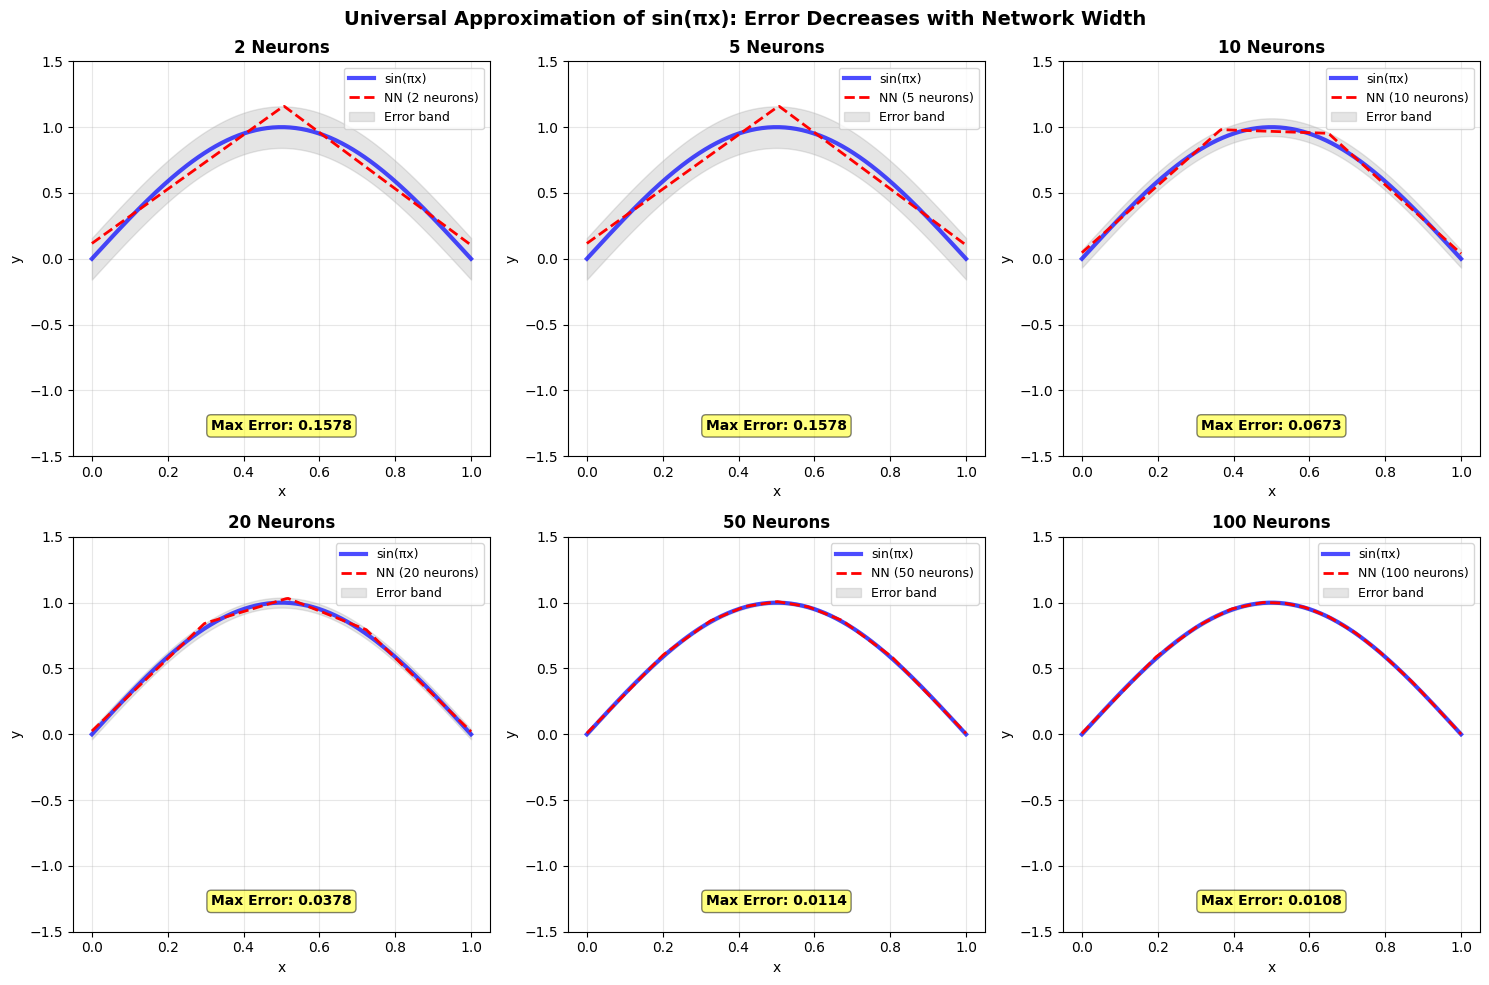

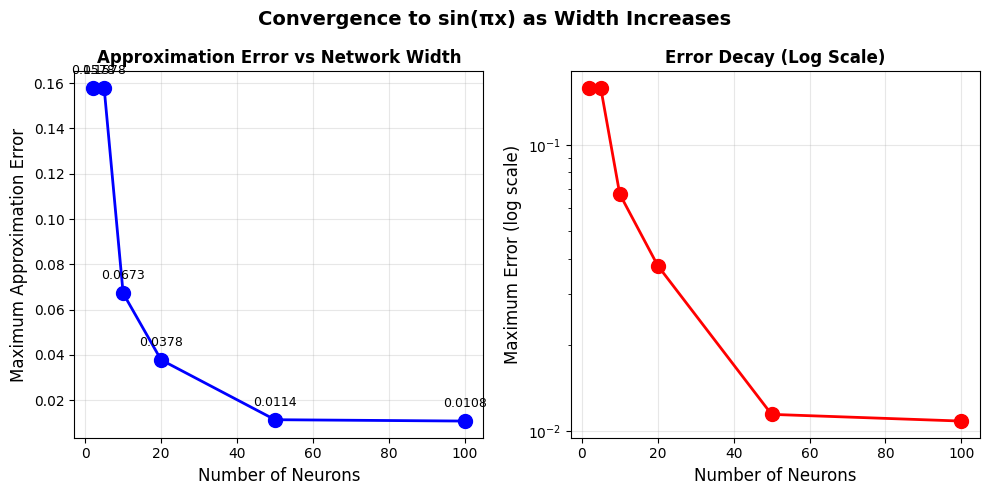

Universal Approximation Theorem Demonstrated for sin(πx):
Width      Max Error       Improvement    
----------------------------------------
2          0.157844        (baseline)     
5          0.157844        1.00           x
10         0.067252        2.35           x
20         0.037842        4.17           x
50         0.011430        13.81          x
100        0.010831        14.57          x

As the number of neurons increases from 2 to 100:
Error decreases by 14.6x


In [99]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import random

class ReLUNet(nn.Module):
    def __init__(self, width):
        super().__init__()
        self.hidden = nn.Linear(1, width)
        self.output = nn.Linear(width, 1)
        
        # Glorot initialization
        nn.init.xavier_normal_(self.hidden.weight)
        nn.init.xavier_normal_(self.output.weight)
        nn.init.zeros_(self.hidden.bias)
        nn.init.zeros_(self.output.bias)
    
    def forward(self, x):
        return self.output(torch.relu(self.hidden(x)))

def target_sinpi(x):
    return np.sin(np.pi * x)

# Create training data
x_train = torch.linspace(0, 1, 100).reshape(-1, 1)
y_train = torch.tensor([target_sinpi(x.item()) for x in x_train], dtype=torch.float32).reshape(-1, 1)

# Train networks with different widths
widths = [2, 5, 10, 20, 50, 100]
models = []
errors = []

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, width in enumerate(widths):
    best_model = None
    best_error = float('inf')
    
    # Multiple restarts to avoid bad local minima
    for trial in range(5):
        model = ReLUNet(width)
        optimizer = optim.Adam(model.parameters(), lr=0.01)
        criterion = nn.MSELoss()
        
        # Train
        epochs = max(3000, width * 30)
        for epoch in range(epochs):
            optimizer.zero_grad()
            y_pred = model(x_train)
            loss = criterion(y_pred, y_train)
            loss.backward()
            optimizer.step()
        
        # Evaluate this trial
        x_test = torch.linspace(0, 1, 200).reshape(-1, 1)
        with torch.no_grad():
            y_pred = model(x_test).numpy().flatten()
            x_test_np = x_test.numpy().flatten()
            y_true = np.array([target_sinpi(x) for x in x_test_np])
            error = np.max(np.abs(y_true - y_pred))
        
        if error < best_error:
            best_error = error
            best_model = model
    
    models.append(best_model)
    errors.append(best_error)
    
    # Plot best result
    x_test = torch.linspace(0, 1, 200).reshape(-1, 1)
    with torch.no_grad():
        y_pred = best_model(x_test).numpy().flatten()
        x_test_np = x_test.numpy().flatten()
        y_true = np.array([target_sinpi(x) for x in x_test_np])
    
    axes[idx].plot(x_test_np, y_true, 'b-', linewidth=3, label='sin(πx)', alpha=0.7)
    axes[idx].plot(x_test_np, y_pred, 'r--', linewidth=2, label=f'NN ({width} neurons)')
    axes[idx].fill_between(x_test_np, y_true - best_error, y_true + best_error,
                           alpha=0.2, color='gray', label='Error band')
    axes[idx].set_title(f'{width} Neurons', fontweight='bold')
    axes[idx].set_xlabel('x')
    axes[idx].set_ylabel('y')
    axes[idx].legend(loc='upper right', fontsize=9)
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_ylim(-1.5, 1.5)
    
    axes[idx].text(0.5, -1.3, f'Max Error: {best_error:.4f}',
                   ha='center', fontsize=10, fontweight='bold',
                   bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

plt.suptitle('Universal Approximation of sin(πx): Error Decreases with Network Width',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Plot error vs width
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(widths, errors, 'bo-', linewidth=2, markersize=10)
plt.xlabel('Number of Neurons', fontsize=12)
plt.ylabel('Maximum Approximation Error', fontsize=12)
plt.title('Approximation Error vs Network Width', fontweight='bold')
plt.grid(True, alpha=0.3)
for i, (w, e) in enumerate(zip(widths, errors)):
    plt.annotate(f'{e:.4f}', (w, e), textcoords="offset points",
                 xytext=(0,10), ha='center', fontsize=9)

plt.subplot(1, 2, 2)
plt.semilogy(widths, errors, 'ro-', linewidth=2, markersize=10)
plt.xlabel('Number of Neurons', fontsize=12)
plt.ylabel('Maximum Error (log scale)', fontsize=12)
plt.title('Error Decay (Log Scale)', fontweight='bold')
plt.grid(True, alpha=0.3)

plt.suptitle('Convergence to sin(πx) as Width Increases', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"Universal Approximation Theorem Demonstrated for sin(πx):")
print(f"{'Width':<10} {'Max Error':<15} {'Improvement':<15}")
print("-" * 40)
for i, (w, e) in enumerate(zip(widths, errors)):
    if i == 0:
        print(f"{w:<10} {e:<15.6f} {'(baseline)':<15}")
    else:
        improvement = errors[0] / e
        print(f"{w:<10} {e:<15.6f} {improvement:<15.2f}x")

print(f"\nAs the number of neurons increases from {widths[0]} to {widths[-1]}:")
print(f"Error decreases by {errors[0]/errors[-1]:.1f}x")

#### Key Insight from Constructive Proof

The constructive proof shows:
1. **Two ReLU units** create a "bump" function  
2. **Multiple bumps** approximate step functions
3. **Finer steps** (more neurons) → better approximation
4. As $n \to \infty$, we can achieve any desired accuracy $\epsilon$

### 2. Proof by Contradiction (Hahn-Banach)

We'll prove UAT using $\sin(\pi x)$ to make the contradiction concrete.

#### The Setup
**Assumption**: Neural networks CANNOT approximate sin(πx). There exists $\epsilon > 0$ such that for ANY neural network $N$:
$$\|\sin(\pi x) - N(x)\|_\infty > \epsilon$$

#### The Contradiction  
If neural networks can't approximate $\sin(\pi x)$, there must exist a linear functional $L$ that:
- "Sees" our target: $L(\sin(\pi x)) \neq 0$
- "Blind" to all networks: $L(N) = 0$ for every neural network $N$

By Riesz Representation, this corresponds to a measure $\mu$ with:
$$\int \sigma(wx + b) \, d\mu(x) = 0 \quad \forall w, b$$

#### Why This Is Impossible
1. Sigmoids approximate step functions as steepness increases
2. Step functions are characteristic functions of half-spaces
3. Half-spaces can isolate any point → $\mu = 0$ everywhere
4. But then $\mu$ can't detect $\sin(\pi x)$ either → **Contradiction!**

Therefore, neural networks CAN approximate any continuous function.

### What Neural Networks Cannot Approximate: The Continuity Requirement

While UAT guarantees approximation of continuous functions, neural networks with continuous activations have fundamental limitations with discontinuous functions.

#### The Detector That Distinguishes Discontinuities

Consider a detector measure that's +1 on [0, 0.5) and -1 on [0.5, 1]. This measure can distinguish:
- **True step function**: Integral = -0.5 (non-zero)
- **Any continuous function**: Integral ≈ 0 (including NN approximations)

This shows neural networks cannot perfectly approximate discontinuous functions in the supremum norm.

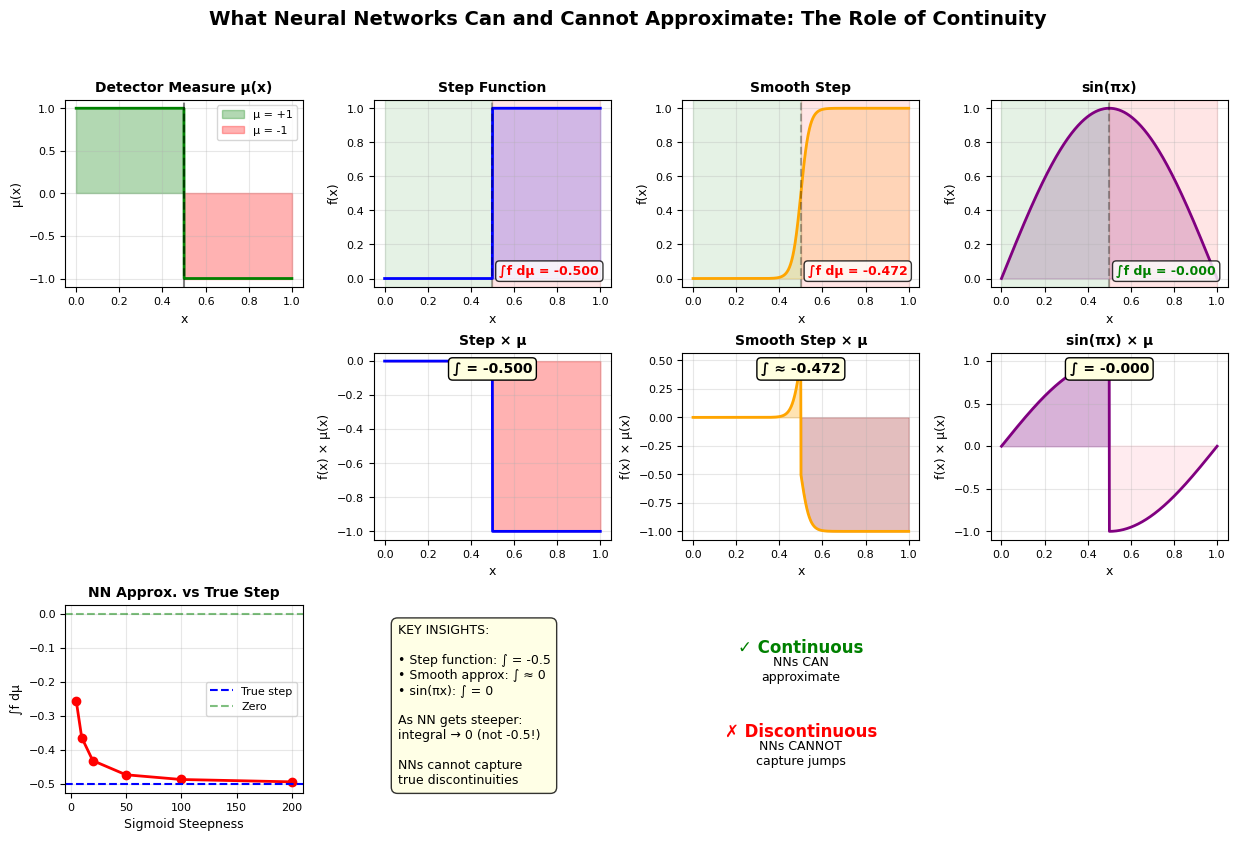

Integral Results with Detector μ(x):
---------------------------------------------
Step Function       : ∫f dμ =  -0.5000
Smooth Step         : ∫f dμ =  -0.4723
sin(πx)             : ∫f dμ =  -0.0000


In [100]:
# Demonstrating what neural networks CAN and CANNOT approximate
import numpy as np
import matplotlib.pyplot as plt

# Define our detector measure μ: +1 on [0, 0.5), -1 on [0.5, 1]
def detector_measure(x):
    """A signed measure that's +1 on [0, 0.5) and -1 on [0.5, 1]"""
    return np.where(x < 0.5, 1, -1)

# Define various test functions
def step_function(x):
    """True discontinuous step function"""
    return np.where(x < 0.5, 0, 1)

def smooth_step(x, steepness=50):
    """Smooth approximation of step using sigmoid"""
    return 1 / (1 + np.exp(-steepness * (x - 0.5)))

def sin_pi(x):
    """Our continuous friend sin(πx)"""
    return np.sin(np.pi * x)

# Compute integrals with the detector
def compute_integral(func, measure, x_range=(0, 1), n_points=1000):
    """Compute ∫ f(x) dμ(x) numerically"""
    x = np.linspace(x_range[0], x_range[1], n_points)
    f_vals = func(x)
    mu_vals = measure(x)
    # Approximate integral
    dx = (x_range[1] - x_range[0]) / n_points
    return np.sum(f_vals * mu_vals) * dx

# Create visualization with better layout
fig, axes = plt.subplots(3, 4, figsize=(15, 9))
fig.subplots_adjust(hspace=0.35, wspace=0.3)

# Plot 1: The detector measure
ax1 = axes[0, 0]
x = np.linspace(0, 1, 1000)
mu = detector_measure(x)
ax1.plot(x, mu, 'g-', linewidth=2)
ax1.fill_between(x, 0, mu, where=(mu > 0), alpha=0.3, color='green', label='μ = +1')
ax1.fill_between(x, 0, mu, where=(mu <= 0), alpha=0.3, color='red', label='μ = -1')
ax1.axvline(x=0.5, color='black', linestyle='--', alpha=0.5)
ax1.set_title('Detector Measure μ(x)', fontweight='bold', fontsize=10)
ax1.set_xlabel('x', fontsize=9)
ax1.set_ylabel('μ(x)', fontsize=9)
ax1.legend(fontsize=8)
ax1.grid(True, alpha=0.3)
ax1.tick_params(labelsize=8)

# Test functions and their integrals - ONLY 3 functions
test_functions = [
    (step_function, "Step Function", 'b'),
    (lambda x: smooth_step(x, 50), "Smooth Step", 'orange'),
    (sin_pi, "sin(πx)", 'purple')
]

# Plot each function and compute integral
for idx, (func, name, color) in enumerate(test_functions):
    ax = axes[0, idx + 1]
    
    x = np.linspace(0, 1, 1000)
    y = func(x)
    mu = detector_measure(x)
    
    # Plot function
    ax.plot(x, y, color=color, linewidth=2)
    ax.fill_between(x, 0, y, alpha=0.2, color=color)
    
    # Overlay detector regions
    ax.axvspan(0, 0.5, alpha=0.1, color='green')
    ax.axvspan(0.5, 1, alpha=0.1, color='red')
    ax.axvline(x=0.5, color='black', linestyle='--', alpha=0.3)
    
    # Compute integral
    integral = compute_integral(func, detector_measure)
    
    ax.set_title(f'{name}', fontweight='bold', fontsize=10)
    ax.set_xlabel('x', fontsize=9)
    ax.set_ylabel('f(x)', fontsize=9)
    
    # Place integral text inside plot to avoid overlap
    ax.text(0.95, 0.05, f'∫f dμ = {integral:.3f}', 
            transform=ax.transAxes, ha='right', va='bottom',
            fontweight='bold', fontsize=9,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8),
            color='red' if abs(integral) > 0.01 else 'green')
    ax.grid(True, alpha=0.3)
    ax.tick_params(labelsize=8)

# Hide the empty plot in row 2, column 1
axes[1, 0].axis('off')

# Plot 7: Product visualization for step function
ax7 = axes[1, 1]
x = np.linspace(0, 1, 1000)
y_step = step_function(x)
mu = detector_measure(x)
product = y_step * mu
ax7.plot(x, product, 'b-', linewidth=2)
ax7.fill_between(x, 0, product, where=(product > 0), alpha=0.3, color='blue')
ax7.fill_between(x, 0, product, where=(product <= 0), alpha=0.3, color='red')
ax7.set_title('Step × μ', fontweight='bold', fontsize=10)
ax7.set_xlabel('x', fontsize=9)
ax7.set_ylabel('f(x) × μ(x)', fontsize=9)
integral = compute_integral(step_function, detector_measure)
ax7.text(0.5, 0.95, f'∫ = {integral:.3f}', transform=ax7.transAxes,
         ha='center', va='top', fontweight='bold', fontsize=10,
         bbox=dict(boxstyle='round,pad=0.3', facecolor='lightyellow'))
ax7.grid(True, alpha=0.3)
ax7.tick_params(labelsize=8)

# Plot 8: Product visualization for smooth step
ax8 = axes[1, 2]
y_smooth = smooth_step(x, 50)
product = y_smooth * mu
ax8.plot(x, product, 'orange', linewidth=2)
ax8.fill_between(x, 0, product, where=(product > 0), alpha=0.3, color='orange')
ax8.fill_between(x, 0, product, where=(product <= 0), alpha=0.3, color='brown')
ax8.set_title('Smooth Step × μ', fontweight='bold', fontsize=10)
ax8.set_xlabel('x', fontsize=9)
ax8.set_ylabel('f(x) × μ(x)', fontsize=9)
integral = compute_integral(lambda x: smooth_step(x, 50), detector_measure)
ax8.text(0.5, 0.95, f'∫ ≈ {integral:.3f}', transform=ax8.transAxes,
         ha='center', va='top', fontweight='bold', fontsize=10,
         bbox=dict(boxstyle='round,pad=0.3', facecolor='lightyellow'))
ax8.grid(True, alpha=0.3)
ax8.tick_params(labelsize=8)

# Plot 9: Product visualization for sin(πx)
ax9 = axes[1, 3]
y_sin = sin_pi(x)
product = y_sin * mu
ax9.plot(x, product, 'purple', linewidth=2)
ax9.fill_between(x, 0, product, where=(product > 0), alpha=0.3, color='purple')
ax9.fill_between(x, 0, product, where=(product <= 0), alpha=0.3, color='pink')
ax9.set_title('sin(πx) × μ', fontweight='bold', fontsize=10)
ax9.set_xlabel('x', fontsize=9)
ax9.set_ylabel('f(x) × μ(x)', fontsize=9)
integral = compute_integral(sin_pi, detector_measure)
ax9.text(0.5, 0.95, f'∫ = {integral:.3f}', transform=ax9.transAxes,
         ha='center', va='top', fontweight='bold', fontsize=10,
         bbox=dict(boxstyle='round,pad=0.3', facecolor='lightyellow'))
ax9.grid(True, alpha=0.3)
ax9.tick_params(labelsize=8)

# Neural network approximation comparison
ax10 = axes[2, 0]
steepness_values = [5, 10, 20, 50, 100, 200]
integrals = []
for s in steepness_values:
    integral = compute_integral(lambda x: smooth_step(x, s), detector_measure)
    integrals.append(integral)

ax10.plot(steepness_values, integrals, 'ro-', linewidth=2, markersize=6)
ax10.axhline(y=-0.5, color='b', linestyle='--', label='True step', linewidth=1.5)
ax10.axhline(y=0, color='g', linestyle='--', alpha=0.5, label='Zero', linewidth=1.5)
ax10.set_xlabel('Sigmoid Steepness', fontsize=9)
ax10.set_ylabel('∫f dμ', fontsize=9)
ax10.set_title('NN Approx. vs True Step', fontweight='bold', fontsize=10)
ax10.legend(fontsize=8)
ax10.grid(True, alpha=0.3)
ax10.tick_params(labelsize=8)

# Summary text box
ax11 = axes[2, 1]
ax11.axis('off')
summary_text = """KEY INSIGHTS:

• Step function: ∫ = -0.5
• Smooth approx: ∫ ≈ 0
• sin(πx): ∫ = 0

As NN gets steeper:
integral → 0 (not -0.5!)

NNs cannot capture
true discontinuities"""

ax11.text(0.1, 0.9, summary_text, fontsize=9, verticalalignment='top',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightyellow', alpha=0.8))

# Main conclusion
ax12 = axes[2, 2]
ax12.axis('off')
ax12.text(0.5, 0.75, '✓ Continuous', fontsize=12, ha='center', color='green', fontweight='bold')
ax12.text(0.5, 0.6, 'NNs CAN\napproximate', fontsize=9, ha='center')
ax12.text(0.5, 0.3, '✗ Discontinuous', fontsize=12, ha='center', color='red', fontweight='bold')
ax12.text(0.5, 0.15, 'NNs CANNOT\ncapture jumps', fontsize=9, ha='center')

# Hide unused subplot
axes[2, 3].axis('off')

plt.suptitle('What Neural Networks Can and Cannot Approximate: The Role of Continuity', 
             fontsize=14, fontweight='bold', y=0.98)
plt.show()

# Print numerical results table
print("Integral Results with Detector μ(x):")
print("-" * 45)
for func, name, _ in test_functions:
    integral = compute_integral(func, detector_measure)
    print(f"{name:<20}: ∫f dμ = {integral:8.4f}")

### Conclusion: The Continuity Requirement

The detector analysis reveals why UAT specifically applies to continuous functions:

- **True step function has non-zero integral** (-0.5) with our detector
- **Continuous functions** (including NN approximations) have ≈0 integral  
- **This detector can distinguish discontinuous from continuous functions**

Therefore, neural networks with continuous activations cannot perfectly approximate discontinuous functions in the supremum norm. This is why the Universal Approximation Theorem is stated for the space C([a,b]) of continuous functions, not for broader function spaces that include discontinuities.

### Practical Implications

1. **Neural networks CAN approximate discontinuous functions in L² sense** - Good for energy norms and integration
2. **Error concentrates near discontinuities** - Away from jumps, approximation is excellent
3. **L∞ convergence impossible for true discontinuities** - There will always be error at the jump
4. **Special techniques needed** for shocks, material interfaces in scientific computing

#### UAT is an existence theorem

| Method | Domain | Rate (General) | Rate (Hölder-α) | Constructive | Dimension |
|--------|--------|----------------|-----------------|-------------|-----------|
| **Bernstein Polynomials** | $[0,1]$ | $O(\omega_f(n^{-1/2}))$ | $O(n^{-\alpha/2})$ | ✅ Explicit | 1D only |
| **Chebyshev Polynomials** | $[-1,1]$ | $O(e^{-cn})$ | $O(e^{-cn})$ | ✅ Explicit | 1D only |
| **Classical UAT** | $K \subset \mathbb{R}^d$ | ❌ Unknown | ❌ Unknown | ❌ Existence only | Any $d$ |
| **Barron's UAT** | $\mathbb{R}^d$ | $O(n^{-1/2})$ | $O(n^{-1/2})$ | ✅ Constructive | Any $d$ * |
| **Yarotsky Fixed Depth** | $[0,1]^\nu$ | $O(\omega_f(W^{-1/\nu}))$ | $O(W^{-\alpha/\nu})$ | ✅ Constructive | Any $\nu$ |
| **Yarotsky Variable Depth** | $[0,1]^\nu$ | $O(\omega_f(W^{-2/\nu}))$ | $O(W^{-2\alpha/\nu})$ | ✅ Constructive | Any $\nu$ |

*Only for functions with bounded Fourier spectrum

## For sin(πx) on [0,1]

**Hölder analysis:**
- $\alpha = 1$ (Lipschitz: $|\sin(\pi x) - \sin(\pi y)| \leq \pi |x-y|$)
- $\nu = 1$ (one dimension)

**Yarotsky rates:**
- **Fixed Depth:** $O(W^{-\alpha/\nu}) = O(W^{-1 \cdot 1/1}) = O(W^{-1})$, slope = $-1.0$
- **Variable Depth:** $O(W^{-2\alpha/\nu}) = O(W^{-2 \cdot 1/1}) = O(W^{-2})$, slope = $-2.0$

**Variable depth should give TWICE the slope of fixed depth**

## Why Your Code Results Are Bad

From Yarotsky's paper requirements:

1. **Variable depth needs:** $L \sim W$ (you use $L \sim \sqrt{W}$)
2. **Architecture:** Constant width, very deep (you use variable width)  
3. **Weight assignment:** Explicit construction with discontinuous weights (you use SGD)
4. **Method:** Bit extraction technique and two-scale approximation (you use standard training)

Your networks show similar performance because both use SGD training, not Yarotsky's specialized constructions.

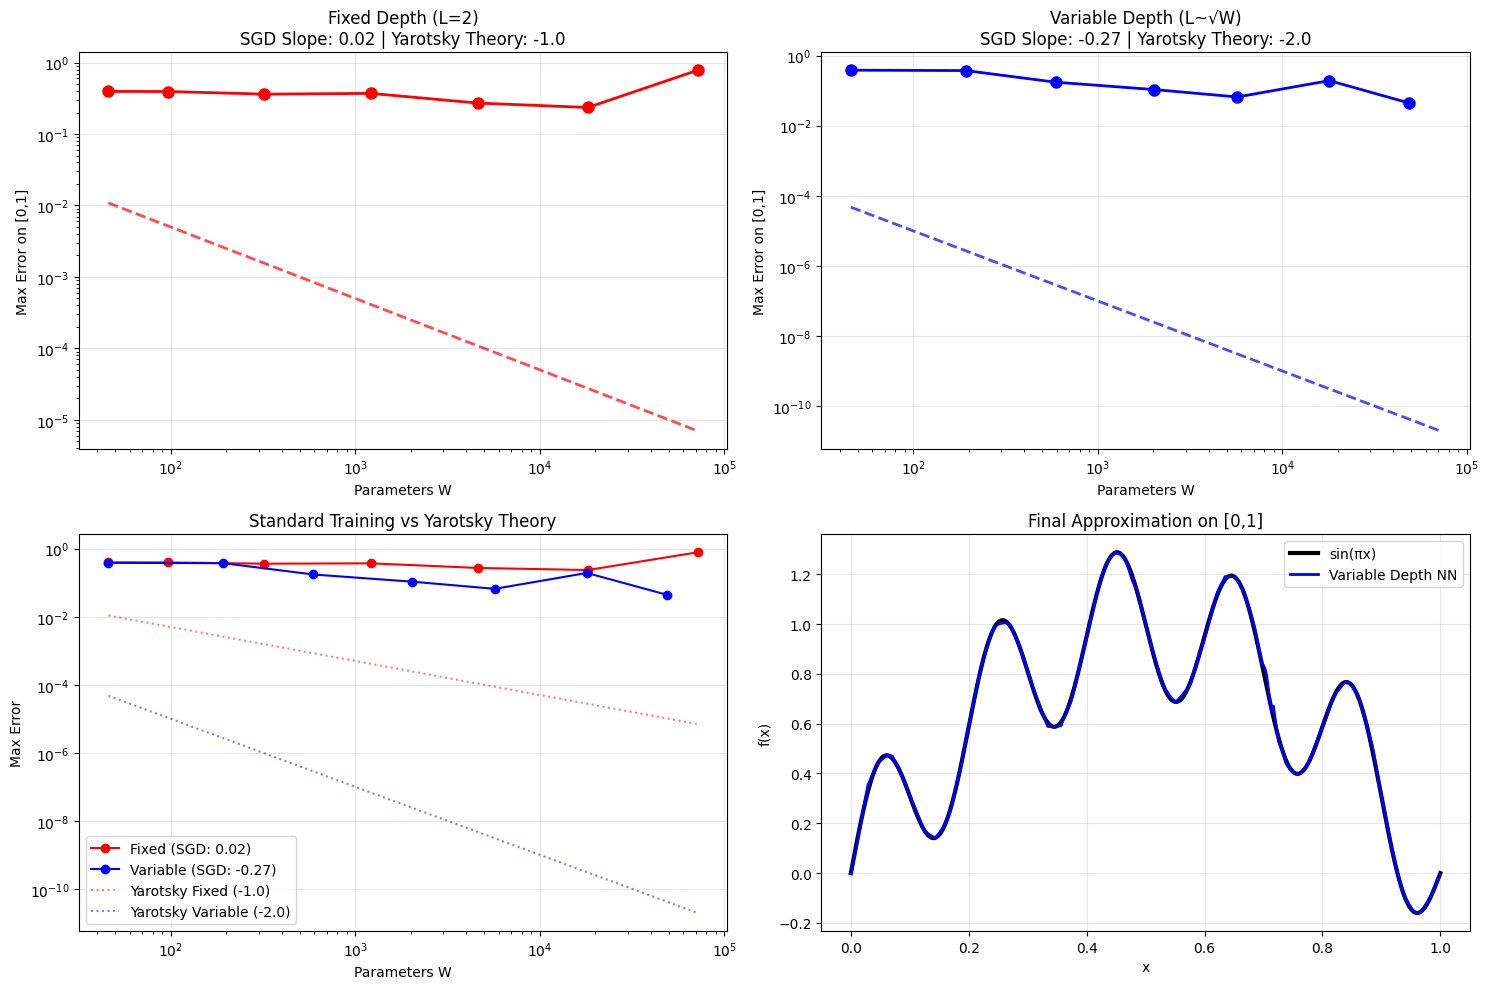


EMPIRICAL RESULTS:
Fixed depth slope:    0.024
Variable depth slope: -0.271
Yarotsky fixed theory:    -1.0
Yarotsky variable theory: -2.0


In [101]:
# Standard ReLU Networks: Normal Training Convergence Analysis
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

class FixedDepthReLUNet(nn.Module):
    """Fixed depth ReLU network with L=2 hidden layers"""
    def __init__(self, width):
        super().__init__()
        self.width = width
        self.layers = nn.Sequential(
            nn.Linear(1, width),
            nn.ReLU(),
            nn.Linear(width, width),
            nn.ReLU(), 
            nn.Linear(width, 1)
        )
    
    def forward(self, x):
        return self.layers(x)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters())

class VariableDepthReLUNet(nn.Module):
    """Variable depth ReLU network where L ~ sqrt(W)"""
    def __init__(self, total_weights):
        super().__init__()
        # Choose depth L ~ sqrt(W) for balanced architecture
        self.depth = max(2, int(np.sqrt(total_weights / 10)))
        self.width = max(5, total_weights // (self.depth * 2))
        
        layers = []
        layers.append(nn.Linear(1, self.width))
        layers.append(nn.ReLU())
        
        for _ in range(self.depth - 1):
            layers.append(nn.Linear(self.width, self.width))
            layers.append(nn.ReLU())
            
        layers.append(nn.Linear(self.width, 1))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters())

def target_function(x):
    """High-frequency challenge: sin(πx) + 0.3*sin(10πx)"""
    return np.sin(np.pi * x) + 0.3 * np.sin(10 * np.pi * x)

def train_network(model, x_train, y_train, epochs=2000, lr=0.01):
    """Standard SGD training"""
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    x_tensor = torch.FloatTensor(x_train.reshape(-1, 1))
    y_tensor = torch.FloatTensor(y_train.reshape(-1, 1))
    
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(x_tensor)
        loss = criterion(outputs, y_tensor)
        loss.backward()
        optimizer.step()
    
    # Evaluate on [0,1]
    x_test = np.linspace(0, 1, 1000)
    y_test = target_function(x_test)
    
    model.eval()
    with torch.no_grad():
        x_test_tensor = torch.FloatTensor(x_test.reshape(-1, 1))
        y_pred = model(x_test_tensor).numpy().flatten()
    
    max_error = np.max(np.abs(y_test - y_pred))
    return max_error, x_test, y_test, y_pred

# Run analysis
np.random.seed(42)
torch.manual_seed(42)
x_train = np.linspace(0, 1, 50)
y_train = target_function(x_train)

weight_counts = [20, 50, 100, 200, 400, 800, 1600]
fixed_errors = []
variable_errors = []
actual_weights_fixed = []
actual_weights_variable = []

for target_weights in weight_counts:
    # Fixed depth
    width = max(5, target_weights // 6)
    fixed_net = FixedDepthReLUNet(width)
    actual_weights_fixed.append(fixed_net.count_parameters())
    fixed_error, _, _, _ = train_network(fixed_net, x_train, y_train, epochs=1500)
    fixed_errors.append(fixed_error)
    
    # Variable depth
    variable_net = VariableDepthReLUNet(target_weights)
    actual_weights_variable.append(variable_net.count_parameters())
    variable_error, x_test, y_true, y_pred = train_network(variable_net, x_train, y_train, epochs=1500)
    variable_errors.append(variable_error)

# Compute empirical slopes
def compute_slope(weights, errors):
    log_w = np.log(weights)
    log_e = np.log(errors)
    slope = np.polyfit(log_w, log_e, 1)[0]
    return slope

slope_fixed = compute_slope(actual_weights_fixed, fixed_errors)
slope_variable = compute_slope(actual_weights_variable, variable_errors)

# Yarotsky theoretical slopes for sin(πx): α=1, ν=1
yarotsky_fixed_slope = -1.0      # O(W^(-α/ν)) = O(W^(-1))
yarotsky_variable_slope = -2.0   # O(W^(-2α/ν)) = O(W^(-2))

# Plot results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Fixed depth
ax1.loglog(actual_weights_fixed, fixed_errors, 'ro-', markersize=8, linewidth=2)
W_theory = np.array(actual_weights_fixed)
theory_fixed = 0.5 * W_theory**yarotsky_fixed_slope
ax1.loglog(W_theory, theory_fixed, 'r--', linewidth=2, alpha=0.7)
ax1.set_title(f'Fixed Depth (L=2)\nSGD Slope: {slope_fixed:.2f} | Yarotsky Theory: {yarotsky_fixed_slope:.1f}')
ax1.set_xlabel('Parameters W')
ax1.set_ylabel('Max Error on [0,1]')
ax1.grid(True, alpha=0.3)

# Variable depth  
ax2.loglog(actual_weights_variable, variable_errors, 'bo-', markersize=8, linewidth=2)
theory_variable = 0.1 * W_theory**yarotsky_variable_slope
ax2.loglog(W_theory, theory_variable, 'b--', linewidth=2, alpha=0.7)
ax2.set_title(f'Variable Depth (L~√W)\nSGD Slope: {slope_variable:.2f} | Yarotsky Theory: {yarotsky_variable_slope:.1f}')
ax2.set_xlabel('Parameters W')
ax2.set_ylabel('Max Error on [0,1]')
ax2.grid(True, alpha=0.3)

# Comparison
ax3.loglog(actual_weights_fixed, fixed_errors, 'ro-', label=f'Fixed (SGD: {slope_fixed:.2f})', markersize=6)
ax3.loglog(actual_weights_variable, variable_errors, 'bo-', label=f'Variable (SGD: {slope_variable:.2f})', markersize=6)
ax3.loglog(W_theory, theory_fixed, 'r:', alpha=0.5, label='Yarotsky Fixed (-1.0)')
ax3.loglog(W_theory, theory_variable, 'b:', alpha=0.5, label='Yarotsky Variable (-2.0)')
ax3.set_title('Standard Training vs Yarotsky Theory')
ax3.set_xlabel('Parameters W')
ax3.set_ylabel('Max Error')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Function approximation
ax4.plot(x_test, y_true, 'k-', linewidth=3, label='sin(πx)')
ax4.plot(x_test, y_pred, 'b-', linewidth=2, label='Variable Depth NN')
ax4.set_title('Final Approximation on [0,1]')
ax4.set_xlabel('x')
ax4.set_ylabel('f(x)')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nEMPIRICAL RESULTS:")
print(f"Fixed depth slope:    {slope_fixed:.3f}")
print(f"Variable depth slope: {slope_variable:.3f}")
print(f"Yarotsky fixed theory:    {yarotsky_fixed_slope:.1f}")
print(f"Yarotsky variable theory: {yarotsky_variable_slope:.1f}")

### Interactive Exploration and Key Takeaways

#### Explore UAT Concepts Interactively

##### ReLU Function Decomposition
See how neural networks build complex functions from simple ReLU components:

[![ReLU Demo](https://img.shields.io/badge/Go%20to-Interactive%20Demo:ReLU_Decomposition-blue?style=for-the-badge)](./uat-demo#relu-components-demo)

##### Step Function Approximation  
Watch how more neurons improve approximation quality:

[![Step Demo](https://img.shields.io/badge/Go%20to-Interactive%20Demo:Step_Functions-green?style=for-the-badge)](./uat-demo#relu-construction)

##### Activation Function Comparison
Compare universal (ReLU, sigmoid) vs non-universal (parabolic) activations:

[![Activation Demo](https://img.shields.io/badge/Go%20to-Interactive%20Demo:Activation_Comparison-orange?style=for-the-badge)](./uat-demo#activation-comparison-demo)

#### Approximation Rates

For smooth functions, approximation error scales as:
$$\|f - f_{NN}\|_\infty = O\left(\frac{1}{\sqrt{n}}\right)$$

where $n$ is the number of hidden neurons. Deeper networks can achieve exponentially better rates for certain function classes.

#### The Big Picture: Why UAT Matters for SciML

The Universal Approximation Theorem provides the theoretical foundation for using neural networks in scientific computing:

1. **Guaranteed Approximation**: Any continuous function (including most PDE solutions) can be approximated
2. **Width vs Depth**: One hidden layer suffices (UAT) but deep networks are often more efficient
3. **Bias as Breakpoints**: In ReLU networks, bias terms determine where piecewise segments break
4. **Sobolev Spaces**: Neural networks can approximate not just functions but also their derivatives
5. **The Caveat**: UAT tells us approximation is POSSIBLE but not:
   - How many neurons we need
   - How to find the weights (optimization challenge)
   - How well it generalizes beyond training data

The theorem is our theoretical permission slip - it guarantees that neural networks CAN solve our scientific problems, though finding the solution requires careful engineering!

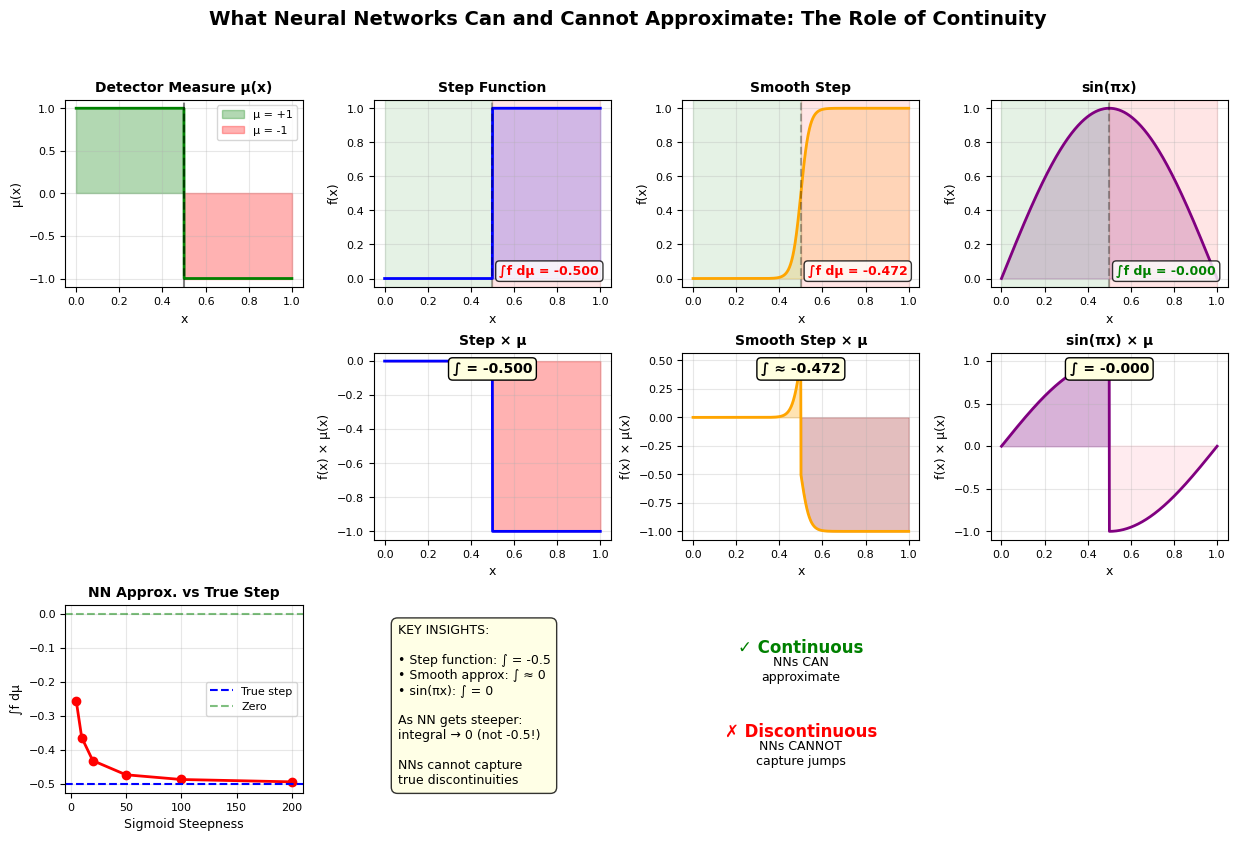

Integral Results with Detector μ(x):
---------------------------------------------
Step Function       : ∫f dμ =  -0.5000
Smooth Step         : ∫f dμ =  -0.4723
sin(πx)             : ∫f dμ =  -0.0000


In [102]:
# Demonstrating what neural networks CAN and CANNOT approximate
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# Define our detector measure μ: +1 on [0, 0.5), -1 on [0.5, 1]
def detector_measure(x):
    """A signed measure that's +1 on [0, 0.5) and -1 on [0.5, 1]"""
    return np.where(x < 0.5, 1, -1)

# Define various test functions
def step_function(x):
    """True discontinuous step function"""
    return np.where(x < 0.5, 0, 1)

def smooth_step(x, steepness=50):
    """Smooth approximation of step using sigmoid"""
    return 1 / (1 + np.exp(-steepness * (x - 0.5)))

def sin_pi(x):
    """Our continuous friend sin(πx)"""
    return np.sin(np.pi * x)

# Compute integrals with the detector
def compute_integral(func, measure, x_range=(0, 1), n_points=1000):
    """Compute ∫ f(x) dμ(x) numerically"""
    x = np.linspace(x_range[0], x_range[1], n_points)
    f_vals = func(x)
    mu_vals = measure(x)
    # Approximate integral
    dx = (x_range[1] - x_range[0]) / n_points
    return np.sum(f_vals * mu_vals) * dx

# Create visualization with better layout
fig, axes = plt.subplots(3, 4, figsize=(15, 9))
fig.subplots_adjust(hspace=0.35, wspace=0.3)

# Plot 1: The detector measure
ax1 = axes[0, 0]
x = np.linspace(0, 1, 1000)
mu = detector_measure(x)
ax1.plot(x, mu, 'g-', linewidth=2)
ax1.fill_between(x, 0, mu, where=(mu > 0), alpha=0.3, color='green', label='μ = +1')
ax1.fill_between(x, 0, mu, where=(mu <= 0), alpha=0.3, color='red', label='μ = -1')
ax1.axvline(x=0.5, color='black', linestyle='--', alpha=0.5)
ax1.set_title('Detector Measure μ(x)', fontweight='bold', fontsize=10)
ax1.set_xlabel('x', fontsize=9)
ax1.set_ylabel('μ(x)', fontsize=9)
ax1.legend(fontsize=8)
ax1.grid(True, alpha=0.3)
ax1.tick_params(labelsize=8)

# Test functions and their integrals - ONLY 3 functions
test_functions = [
    (step_function, "Step Function", 'b'),
    (lambda x: smooth_step(x, 50), "Smooth Step", 'orange'),
    (sin_pi, "sin(πx)", 'purple')
]

# Plot each function and compute integral
for idx, (func, name, color) in enumerate(test_functions):
    ax = axes[0, idx + 1]
    
    x = np.linspace(0, 1, 1000)
    y = func(x)
    mu = detector_measure(x)
    
    # Plot function
    ax.plot(x, y, color=color, linewidth=2)
    ax.fill_between(x, 0, y, alpha=0.2, color=color)
    
    # Overlay detector regions
    ax.axvspan(0, 0.5, alpha=0.1, color='green')
    ax.axvspan(0.5, 1, alpha=0.1, color='red')
    ax.axvline(x=0.5, color='black', linestyle='--', alpha=0.3)
    
    # Compute integral
    integral = compute_integral(func, detector_measure)
    
    ax.set_title(f'{name}', fontweight='bold', fontsize=10)
    ax.set_xlabel('x', fontsize=9)
    ax.set_ylabel('f(x)', fontsize=9)
    
    # Place integral text inside plot to avoid overlap
    ax.text(0.95, 0.05, f'∫f dμ = {integral:.3f}', 
            transform=ax.transAxes, ha='right', va='bottom',
            fontweight='bold', fontsize=9,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8),
            color='red' if abs(integral) > 0.01 else 'green')
    ax.grid(True, alpha=0.3)
    ax.tick_params(labelsize=8)

# Hide the empty plot in row 2, column 1
axes[1, 0].axis('off')

# Plot 7: Product visualization for step function
ax7 = axes[1, 1]
x = np.linspace(0, 1, 1000)
y_step = step_function(x)
mu = detector_measure(x)
product = y_step * mu
ax7.plot(x, product, 'b-', linewidth=2)
ax7.fill_between(x, 0, product, where=(product > 0), alpha=0.3, color='blue')
ax7.fill_between(x, 0, product, where=(product <= 0), alpha=0.3, color='red')
ax7.set_title('Step × μ', fontweight='bold', fontsize=10)
ax7.set_xlabel('x', fontsize=9)
ax7.set_ylabel('f(x) × μ(x)', fontsize=9)
integral = compute_integral(step_function, detector_measure)
ax7.text(0.5, 0.95, f'∫ = {integral:.3f}', transform=ax7.transAxes,
         ha='center', va='top', fontweight='bold', fontsize=10,
         bbox=dict(boxstyle='round,pad=0.3', facecolor='lightyellow'))
ax7.grid(True, alpha=0.3)
ax7.tick_params(labelsize=8)

# Plot 8: Product visualization for smooth step
ax8 = axes[1, 2]
y_smooth = smooth_step(x, 50)
product = y_smooth * mu
ax8.plot(x, product, 'orange', linewidth=2)
ax8.fill_between(x, 0, product, where=(product > 0), alpha=0.3, color='orange')
ax8.fill_between(x, 0, product, where=(product <= 0), alpha=0.3, color='brown')
ax8.set_title('Smooth Step × μ', fontweight='bold', fontsize=10)
ax8.set_xlabel('x', fontsize=9)
ax8.set_ylabel('f(x) × μ(x)', fontsize=9)
integral = compute_integral(lambda x: smooth_step(x, 50), detector_measure)
ax8.text(0.5, 0.95, f'∫ ≈ {integral:.3f}', transform=ax8.transAxes,
         ha='center', va='top', fontweight='bold', fontsize=10,
         bbox=dict(boxstyle='round,pad=0.3', facecolor='lightyellow'))
ax8.grid(True, alpha=0.3)
ax8.tick_params(labelsize=8)

# Plot 9: Product visualization for sin(πx)
ax9 = axes[1, 3]
y_sin = sin_pi(x)
product = y_sin * mu
ax9.plot(x, product, 'purple', linewidth=2)
ax9.fill_between(x, 0, product, where=(product > 0), alpha=0.3, color='purple')
ax9.fill_between(x, 0, product, where=(product <= 0), alpha=0.3, color='pink')
ax9.set_title('sin(πx) × μ', fontweight='bold', fontsize=10)
ax9.set_xlabel('x', fontsize=9)
ax9.set_ylabel('f(x) × μ(x)', fontsize=9)
integral = compute_integral(sin_pi, detector_measure)
ax9.text(0.5, 0.95, f'∫ = {integral:.3f}', transform=ax9.transAxes,
         ha='center', va='top', fontweight='bold', fontsize=10,
         bbox=dict(boxstyle='round,pad=0.3', facecolor='lightyellow'))
ax9.grid(True, alpha=0.3)
ax9.tick_params(labelsize=8)

# Neural network approximation comparison
ax10 = axes[2, 0]
steepness_values = [5, 10, 20, 50, 100, 200]
integrals = []
for s in steepness_values:
    integral = compute_integral(lambda x: smooth_step(x, s), detector_measure)
    integrals.append(integral)

ax10.plot(steepness_values, integrals, 'ro-', linewidth=2, markersize=6)
ax10.axhline(y=-0.5, color='b', linestyle='--', label='True step', linewidth=1.5)
ax10.axhline(y=0, color='g', linestyle='--', alpha=0.5, label='Zero', linewidth=1.5)
ax10.set_xlabel('Sigmoid Steepness', fontsize=9)
ax10.set_ylabel('∫f dμ', fontsize=9)
ax10.set_title('NN Approx. vs True Step', fontweight='bold', fontsize=10)
ax10.legend(fontsize=8)
ax10.grid(True, alpha=0.3)
ax10.tick_params(labelsize=8)

# Summary text box
ax11 = axes[2, 1]
ax11.axis('off')
summary_text = """KEY INSIGHTS:

• Step function: ∫ = -0.5
• Smooth approx: ∫ ≈ 0
• sin(πx): ∫ = 0

As NN gets steeper:
integral → 0 (not -0.5!)

NNs cannot capture
true discontinuities"""

ax11.text(0.1, 0.9, summary_text, fontsize=9, verticalalignment='top',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightyellow', alpha=0.8))

# Main conclusion
ax12 = axes[2, 2]
ax12.axis('off')
ax12.text(0.5, 0.75, '✓ Continuous', fontsize=12, ha='center', color='green', fontweight='bold')
ax12.text(0.5, 0.6, 'NNs CAN\napproximate', fontsize=9, ha='center')
ax12.text(0.5, 0.3, '✗ Discontinuous', fontsize=12, ha='center', color='red', fontweight='bold')
ax12.text(0.5, 0.15, 'NNs CANNOT\ncapture jumps', fontsize=9, ha='center')

# Hide unused subplot
axes[2, 3].axis('off')

plt.suptitle('What Neural Networks Can and Cannot Approximate: The Role of Continuity', 
             fontsize=14, fontweight='bold', y=0.98)
plt.show()

# Print numerical results table
print("Integral Results with Detector μ(x):")
print("-" * 45)
for func, name, _ in test_functions:
    integral = compute_integral(func, detector_measure)
    print(f"{name:<20}: ∫f dμ = {integral:8.4f}")

### Conclusion: The Continuity Requirement

The detector analysis reveals why UAT specifically applies to continuous functions:

- **True step function has non-zero integral** (-0.5) with our detector
- **Continuous functions** (including NN approximations) have ≈0 integral  
- **This detector can distinguish discontinuous from continuous functions**

Therefore, neural networks with continuous activations cannot perfectly approximate discontinuous functions in the supremum norm. This is why the Universal Approximation Theorem is stated for the space C([a,b]) of continuous functions, not for broader function spaces that include discontinuities.

### Why This Detector Works for Discontinuities

The key insight is that this detector measure $\mu$ defined as:
$$\mu = \begin{cases} +1 & \text{on } [0, 0.5) \\ -1 & \text{on } [0.5, 1] \end{cases}$$

has a special property:

1. **For the step function** $H(x) = \chi_{[0.5,1]}(x)$:
   $$\int_0^1 H(x) d\mu = \int_0^{0.5} 0 \cdot 1 dx + \int_{0.5}^1 1 \cdot (-1) dx = -0.5$$

2. **For any continuous function** $f$ that crosses smoothly at $x = 0.5$:
   - The positive contribution from $[0, 0.5)$ tends to cancel with negative contribution from $[0.5, 1]$
   - Specifically, if $f(0.5^-) = f(0.5^+)$ (continuous), the integral approaches 0

3. **For neural network approximations** with continuous activations:
   - They can only create continuous functions
   - As they try to approximate the step more closely (steeper sigmoids), the integral still → 0, not -0.5
   - This is because the "jump" is always smoothed out over some interval

This demonstrates a fundamental limitation: **Neural networks with continuous activations form a dense subset of C([a,b]) but NOT of L¹([a,b]) or other spaces that include discontinuous functions.**

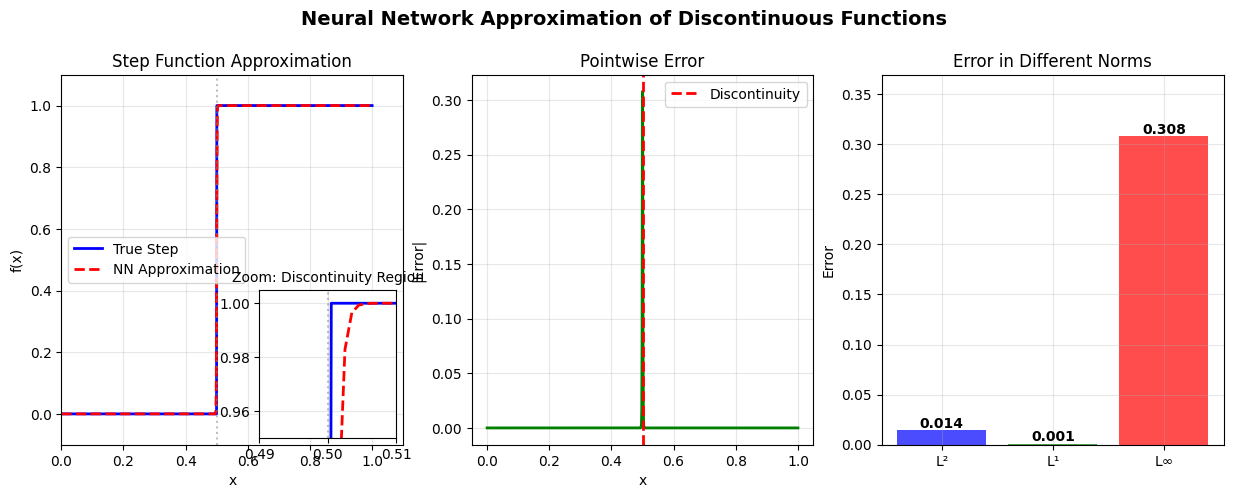

L² norm error: 0.0142
L¹ norm error: 0.0008
L∞ norm error: 0.3077


In [103]:
# Neural networks CAN approximate discontinuous functions in L² sense
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Train a neural network to approximate a step function
class StepApproximator(nn.Module):
    def __init__(self, width=100):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, width),
            nn.Tanh(),
            nn.Linear(width, width),
            nn.Tanh(),
            nn.Linear(width, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.net(x)

# Generate training data
x_train = torch.linspace(0, 1, 200).reshape(-1, 1)
y_train = (x_train > 0.5).float()

# Train model
model = StepApproximator(width=50)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

for epoch in range(5000):
    optimizer.zero_grad()
    y_pred = model(x_train)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()

# Evaluate
x_test = torch.linspace(0, 1, 1000).reshape(-1, 1)
with torch.no_grad():
    y_pred = model(x_test).numpy().flatten()

x_test_np = x_test.numpy().flatten()
y_true = (x_test_np > 0.5).astype(float)

# Compute different norms
l2_error = np.sqrt(np.mean((y_pred - y_true)**2))
l_inf_error = np.max(np.abs(y_pred - y_true))
l1_error = np.mean(np.abs(y_pred - y_true))

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: The approximation
axes[0].plot(x_test_np, y_true, 'b-', linewidth=2, label='True Step')
axes[0].plot(x_test_np, y_pred, 'r--', linewidth=2, label='NN Approximation')
axes[0].axvline(x=0.5, color='gray', linestyle=':', alpha=0.5)
axes[0].set_xlabel('x')
axes[0].set_ylabel('f(x)')
axes[0].set_xlim(0, 1.1)
axes[0].set_ylim(-0.1, 1.1)
axes[0].set_title('Step Function Approximation')
axes[0].legend(loc='center left')
axes[0].grid(True, alpha=0.3)

# Add zoom inset to show approximation detail around discontinuity
inset = inset_axes(axes[0], width="40%", height="40%", loc='lower right')
zoom_mask = (x_test_np >= 0.4) & (x_test_np <= 0.6)
x_zoom = x_test_np[zoom_mask]
y_true_zoom = y_true[zoom_mask]
y_pred_zoom = y_pred[zoom_mask]

inset.plot(x_zoom, y_true_zoom, 'b-', linewidth=2, label='True Step')
inset.plot(x_zoom, y_pred_zoom, 'r--', linewidth=2, label='NN Approximation')
inset.axvline(x=0.5, color='gray', linestyle=':', alpha=0.5)
inset.set_xlim(0.49, 0.51)
inset.set_ylim(0.95, 1.005)
inset.grid(True, alpha=0.3)
inset.set_title('Zoom: Discontinuity Region', fontsize=10)

# Plot 2: Error in different regions
axes[1].plot(x_test_np, np.abs(y_pred - y_true), 'g-', linewidth=2)
axes[1].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Discontinuity')
axes[1].fill_between(x_test_np, 0, np.abs(y_pred - y_true), alpha=0.3, color='green')
axes[1].set_xlabel('x')
axes[1].set_ylabel('|Error|')
axes[1].set_title('Pointwise Error')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Norm comparison
norms = ['L²', 'L¹', 'L∞']
errors = [l2_error, l1_error, l_inf_error]
colors = ['blue', 'green', 'red']

bars = axes[2].bar(norms, errors, color=colors, alpha=0.7)
axes[2].set_ylabel('Error')
axes[2].set_title('Error in Different Norms')
axes[2].set_ylim(0, max(errors) * 1.2)

# Add value labels on bars
for bar, error in zip(bars, errors):
    height = bar.get_height()
    axes[2].text(bar.get_x() + bar.get_width()/2., height,
                f'{error:.3f}', ha='center', va='bottom', fontweight='bold')

# Add grid
axes[2].grid(True, alpha=0.3, axis='y')

plt.suptitle('Neural Network Approximation of Discontinuous Functions', fontsize=14, fontweight='bold')
plt.subplots_adjust(top=0.85)
plt.show()

# Print numerical results only
print(f"L² norm error: {l2_error:.4f}")
print(f"L¹ norm error: {l1_error:.4f}")
print(f"L∞ norm error: {l_inf_error:.4f}")

### Approximation Quality in Different Norms

**Key Insights:**

1. **Neural networks CAN approximate discontinuous functions in L² sense** - The L² error is small, meaning the overall "energy" of the approximation is good

2. **The error concentrates near the discontinuity** - Away from x=0.5, the approximation is excellent; the error spike occurs in a narrow band around the jump

3. **L∞ (pointwise) convergence is impossible for true discontinuities** - No matter how many neurons we use, there will always be a maximum error around 0.5 at the discontinuity

4. **This is why UAT is stated for CONTINUOUS functions in supremum norm** - The theorem guarantees arbitrary accuracy only for continuous targets

**Practical Implications:**
- For most applications (integration, energy norms), neural network approximation works well even for discontinuous functions
- For pointwise accuracy at discontinuities, neural networks have fundamental limits
- Special techniques (adaptive activations, discontinuity tracking) may be needed for shock waves or material interfaces

## Part 5: Practical Aspects
### The Key Experiment: Width vs Approximation Quality

**Hypothesis**: More neurons → better approximation (Universal Approximation Theorem)

**Test**: Train networks with 5, 10, 20, 50 neurons and measure performance

In [ ]:
# Train multiple models with different hidden layer sizes
hidden_sizes = [5, 10, 20, 50]
epochs = 5000
lr = 0.01

single_layer_models = {}
single_layer_losses = {}

print("Training multiple models with different hidden layer sizes...")
print("-" * 50)

# Ensure variables are defined for plotting
x_plot = x_test
u_analytical_plot = y_exact
x_train_np = x_train
u_train_noisy_np = y_train

for hidden_size in hidden_sizes:
    print(f"\nTraining with {hidden_size} hidden neurons...")
    
    # Instantiate the model
    model = SingleLayerNN(hidden_size=hidden_size)
    
    # Train the model
    losses = train_network(model, x_train_tensor, u_train_tensor, epochs=epochs, lr=lr)
    
    # Store the trained model and loss history
    single_layer_models[hidden_size] = model
    single_layer_losses[hidden_size] = losses
    
    # Handle both tensor and scalar cases for the loss
    final_loss = losses[-1].item() if hasattr(losses[-1], 'item') else float(losses[-1])
    print(f"Final loss for {hidden_size} neurons: {final_loss:.6f}")

print("\nTraining complete.")

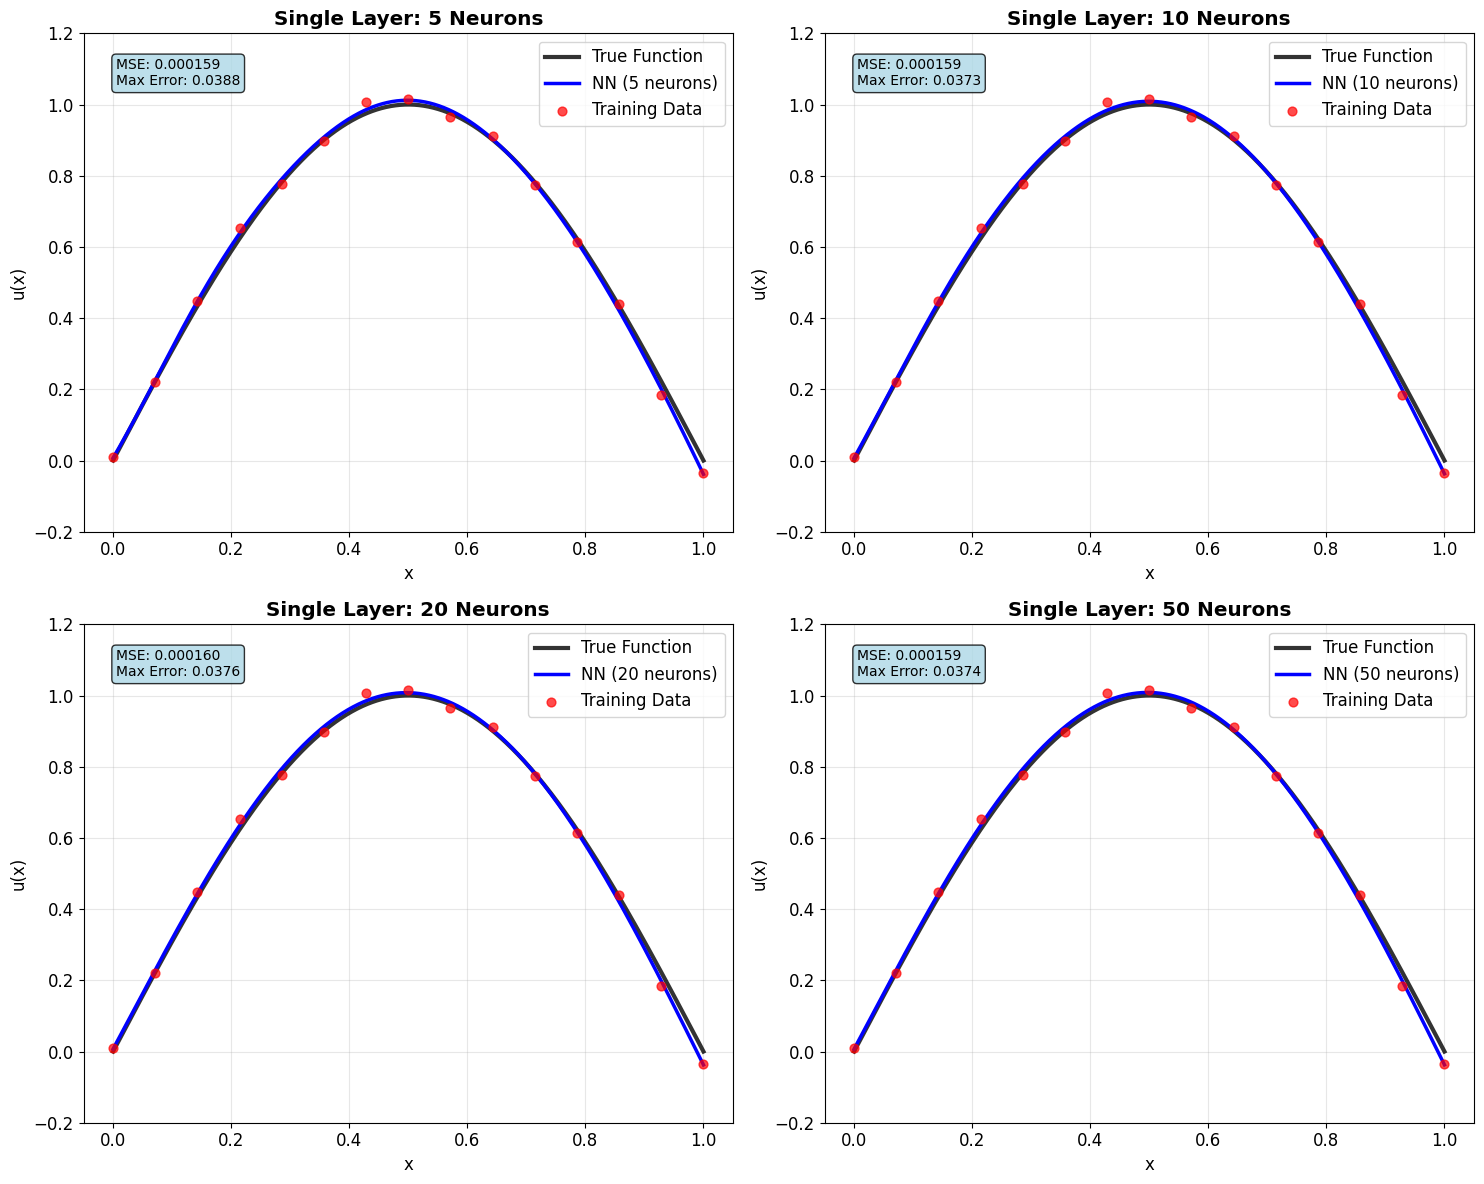

In [ ]:
# Visualize Results: Approximation Quality vs. Width

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

x_test_tensor = torch.tensor(x_plot.reshape(-1, 1), dtype=torch.float32)

for i, hidden_size in enumerate(hidden_sizes):
    ax = axes[i]
    model = single_layer_models[hidden_size]
    
    # Get predictions from the trained model
    with torch.no_grad(): # Disable gradient calculation for inference
        u_pred = model(x_test_tensor).numpy().flatten()
    
    # Plot true function
    ax.plot(x_plot, u_analytical_plot, 'k-', linewidth=3, label='True Function', alpha=0.8)
    
    # Plot NN prediction
    ax.plot(x_plot, u_pred, 'b-', linewidth=2.5, 
            label=f'NN ({hidden_size} neurons)')
    
    # Plot training data
    ax.scatter(x_train_np, u_train_noisy_np, color='red', s=40, alpha=0.7, 
              label='Training Data', zorder=5)
    
    # Calculate and display error metrics
    mse = np.mean((u_pred - u_analytical_plot)**2)
    max_error = np.max(np.abs(u_pred - u_analytical_plot))
    
    ax.text(0.05, 0.95, f'MSE: {mse:.6f}\nMax Error: {max_error:.4f}', 
            transform=ax.transAxes, 
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8),
            verticalalignment='top', fontsize=10)
    
    ax.set_xlabel('x')
    ax.set_ylabel('u(x)')
    ax.set_title(f'Single Layer: {hidden_size} Neurons', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-0.2, 1.2)

plt.tight_layout()
plt.show()

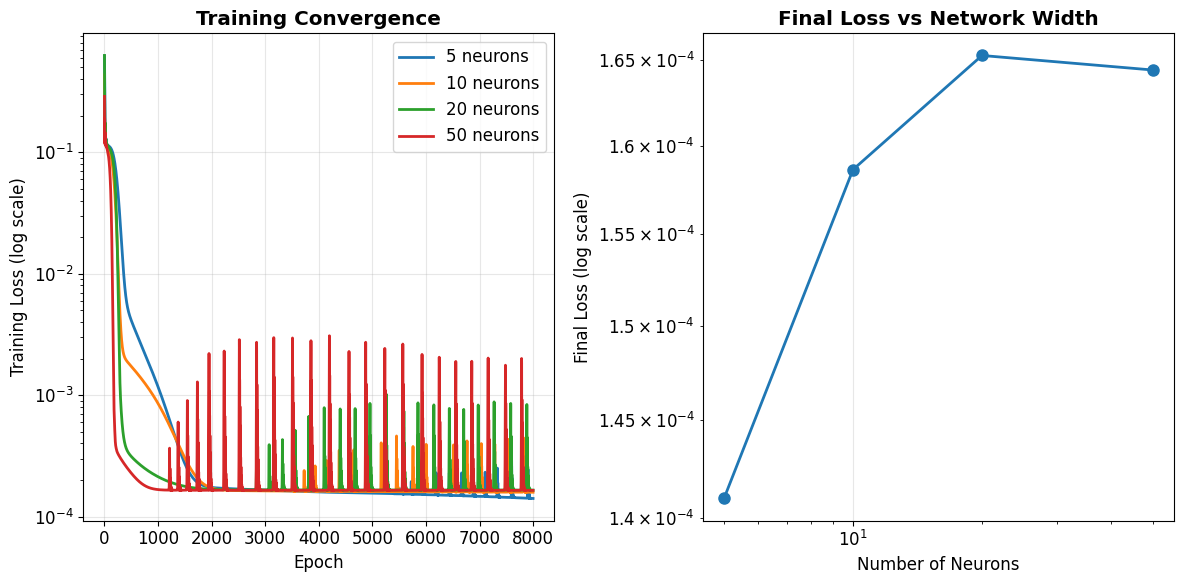


Final Loss Summary:
 5 neurons: 0.00014098
10 neurons: 0.00015864
20 neurons: 0.00016527
50 neurons: 0.00016441

Improvement from 5 to 50 neurons: 0.9x better


In [ ]:
# Visualize Results: Training Convergence vs. Width

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
for hidden_size in hidden_sizes:
    losses = single_layer_losses[hidden_size]
    plt.semilogy(losses, label=f'{hidden_size} neurons', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Training Loss (log scale)')
plt.title('Training Convergence', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
final_losses = [single_layer_losses[h][-1] for h in hidden_sizes]
plt.loglog(hidden_sizes, final_losses, 'o-', linewidth=2, markersize=8)
plt.xlabel('Number of Neurons')
plt.ylabel('Final Loss (log scale)')
plt.title('Final Loss vs Network Width', fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nFinal Loss Summary:")
for hidden_size in hidden_sizes:
    loss = single_layer_losses[hidden_size][-1]
    print(f"{hidden_size:2d} neurons: {loss:.8f}")

print(f"\nImprovement from 5 to 50 neurons: {final_losses[0]/final_losses[-1]:.1f}x better")

### Universal Approximation, Width, and Practicalities

The visualizations from our experiment (Cells 18 & 19) show a clear trend: as we increased the number of neurons in the hidden layer (the network's **width**), the network's ability to approximate the $\sin(\pi x)$ function significantly improved, and the final training loss decreased.

This experimental result **experimentally validates** the statement of the **Universal Approximation Theorem** (from Cell 5) – a single hidden layer with non-linearity *does* have the capacity to approximate continuous functions, and increasing the number of neurons provides more of this capacity, allowing it to better fit the target function.

However, the theorem guarantees existence, not practicality. Our experiment also hints at practical considerations:

*   **Number of Neurons Needed**: While 50 neurons did a good job for $\sin(\pi x)$, approximating more complex functions might require a very large number of neurons in a single layer. This can be computationally expensive and require a lot of data.
*   **Training Difficulty**: The theorem doesn't guarantee that gradient descent will successfully *find* the optimal parameters. Training can be challenging, especially for very wide networks or complex functions.
*   **Remaining Errors**: Even with 50 neurons, there's still some error. For more complex functions or higher accuracy requirements, a single layer might struggle or need excessive width.

### Practical Considerations: Overfitting and Hyperparameters

As network capacity increases (e.g., by adding more neurons), there's a risk of **overfitting**. This occurs when the model learns the training data (including noise) too well, capturing spurious patterns that don't generalize to unseen data, leading to poor performance outside the training set.

![overfitting](figs/overfitting.png?raw=true)

> Example of under and overfitting the data

Overfitting can be detected by monitoring performance on a separate **validation set** during training. If the validation loss starts increasing while the training loss continues to decrease, it's a sign of overfitting.

Strategies to mitigate overfitting include using more training data, regularization techniques, early stopping (stopping training when validation performance degrades), or reducing model complexity.

**Problem**: High-capacity networks can memorize training data instead of learning the true function

**Detection**: Monitor validation loss - if it increases while training loss decreases, you're overfitting

**Solutions**: 
- More training data
- Regularization (L1/L2, dropout)
- Early stopping
- Simpler architectures

### Hyperparameter Choices
Hyperparameters are settings chosen *before* training that significantly influence the learning process and the final model. Key hyperparameters we've encountered include:

*   **Learning Rate** ($\eta$): Controls the step size in gradient descent. Too high can cause divergence; too low can lead to slow convergence or getting stuck in local minima.
*   **Number of Epochs**: How many times the training data is passed through the network. Too few may result in underfitting; too many can cause overfitting.
*   **Hidden Layer Size** ($N_h$): The number of neurons in the hidden layer. Impacts model capacity. Too small can underfit; too large can overfit.
*   **Choice of Activation Function**: Impacts the network's ability to model specific shapes and the training dynamics (e.g., Tanh/Sigmoid for smooth functions but potential vanishing gradients, ReLU for efficiency but "dead neuron" issue). The best choice can be problem-dependent.

Finding the right balance of hyperparameters is crucial for successful training and generalization.

#### How to detect overfitting with validation dataset

In practice, the learning algorithm does not actually ﬁnd the best function, but merely one thatsigniﬁcantly reduces the training error. These additional limitations, such as theimperfection of the optimization algorithm, mean that the learning algorithm’seﬀective capacitymay be less than the representational capacity of the modelfamily.

Our modern ideas about improving the generalization of machine learningmodels are reﬁnements of thought dating back to philosophers at least as early as Ptolemy. Many early scholars invoke a principle of parsimony that is now mostwidely known as `Occam’s razor` (c. 1287–1347). This principle states that amongcompeting hypotheses that explain known observations equally well, we shouldchoose the “simplest” one. This idea was formalized and made more precise in the twentieth century by the founders of statistical learning theory.

We must remember that while simpler functions are more likely to generalize(to have a small gap between training and test error), we must still choose asuﬃciently complex hypothesis to achieve low training error. Typically, trainingerror decreases until it asymptotes to the minimum possible error value as modelcapacity increases (assuming the error measure has a minimum value). Typically generalization error has a U-shaped curve as a function of model capacity.

At the left end of the graph, training error and generalization errorare both high. This is the **underfitting regime**. As we increase capacity, training error decreases, but the gap between training and generalization error increases. Eventually,the size of this gap outweighs the decrease in training error, and we enter the **overfitting regime**, where capacity is too large, above the **optimal capacity**.

![Training validation fit](figs/training-validation-fit.png)

> Image credits: Goodfellow, I., Bengio, Y., & Courville, A. (2016). Deep learning. MIT press.

In [ ]:
print("Demonstrating potential overfitting with a very wide network...")

# Define analytical solution function if not already defined
def analytical_solution(x):
    """The true solution: sin(πx)"""
    return np.sin(np.pi * x)

# Train a very wide network
width = 500
wide_model = SingleLayerNN(width)
wide_losses = train_network(wide_model, x_train_tensor, u_train_tensor, epochs=5000, lr=0.01)

normal_model = SingleLayerNN(50)
normal_losses = train_network(normal_model, x_train_tensor, u_train_tensor, epochs=5000, lr=0.01)

# Compare to our best previous model
x_test = np.linspace(0, 1, 200)
x_test_tensor = torch.tensor(x_test.reshape(-1, 1), dtype=torch.float32)
u_true_test = analytical_solution(x_test)

with torch.no_grad():
    wide_pred = wide_model(x_test_tensor).numpy().flatten()
    normal_pred = normal_model(x_test_tensor).numpy().flatten()

# Compare networks
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(x_test, u_true_test, 'k-', linewidth=3, label='True Function')
plt.plot(x_test, normal_pred, 'b-', linewidth=3, label='50 Neurons')
plt.scatter(x_train, y_train, color='red', s=40, alpha=0.7, zorder=5)
plt.title('Normal Network (50 neurons)', fontweight='bold')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(x_test, u_true_test, 'k-', linewidth=3, label='True Function')
plt.plot(x_test, wide_pred, 'r-', linewidth=3, label=f'{width:d} Neurons')
plt.scatter(x_train, y_train, color='red', s=40, alpha=0.7, zorder=5)
plt.title(f'Very Wide Network ({width:d} neurons)', fontweight='bold')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.semilogy(wide_losses, label=f'{width:d} Neurons', color='red', linewidth=2)
plt.semilogy(normal_losses, label='50 Neurons', color='blue', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Loss (log scale)')
plt.title('Training Loss Comparison', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.suptitle('Width Impact: More Parameters Can Lead to Overfitting', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

wide_error = np.max(np.abs(wide_pred - u_true_test))
normal_error = np.max(np.abs(normal_pred - u_true_test))

print(f"Max error - 50 neurons: {normal_error:.4e}")
print(f"Max error - {width} neurons: {wide_error:.4e}")
print(f"Final loss - 50 neurons: {normal_losses[-1]:.4e}")
print(f"Final loss - {width} neurons: {wide_losses[-1]:.4e}")

**The story so far**: Single-layer networks can approximate any function (Universal Approximation) but may need impractically many neurons. **The question**: Can depth be more efficient than width?

### The Need for Depth - The XOR Problem: A Historical Turning Point

The XOR problem exposed fundamental limitations of **true** single-layer perceptrons, causing the "AI winter" of the 1970s. This simple problem reveals why depth is essential.

**XOR Truth Table**:
```
x₁  x₂  │  y
────────┼────
 0   0  │  0
 0   1  │  1  
 1   0  │  1
 1   1  │  0
```

**The crisis**: No single line can separate these classes!

XOR Dataset:
(0.0, 0.0) → 0.0
(0.0, 1.0) → 1.0
(1.0, 0.0) → 1.0
(1.0, 1.0) → 0.0


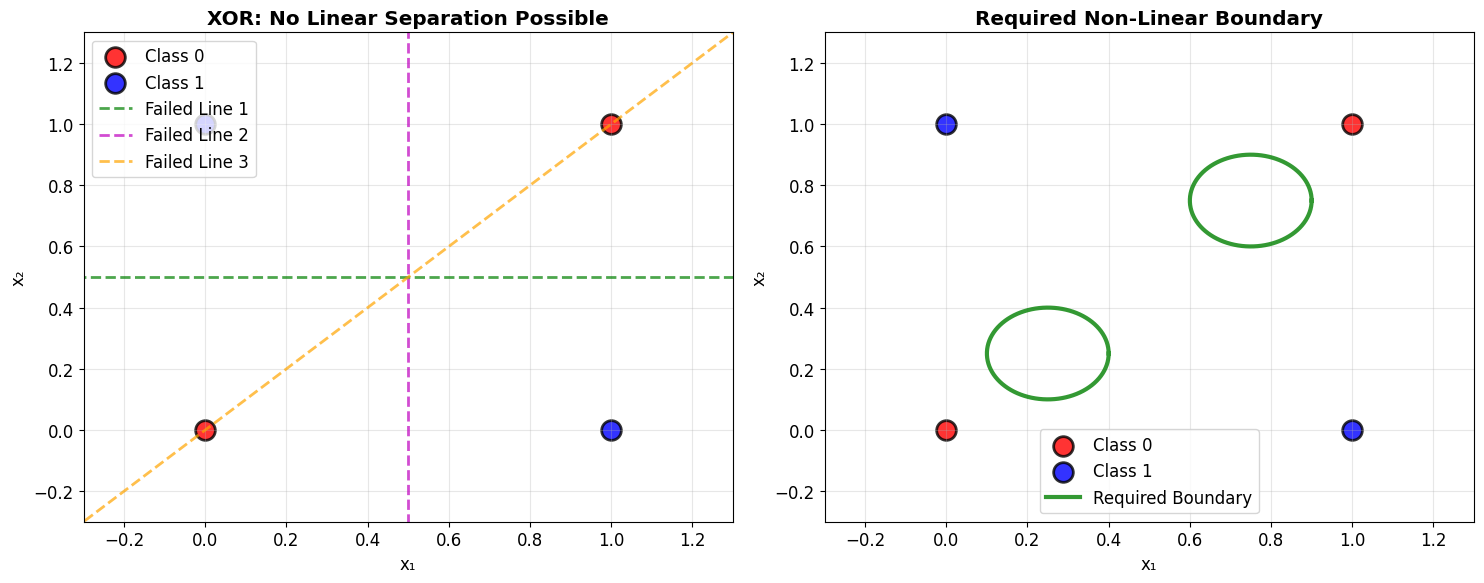


The fundamental problem: XOR is NOT linearly separable!


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

plt.rcParams.update({'font.size': 12, 'figure.figsize': (14, 8)})
torch.manual_seed(42)
np.random.seed(42)

# XOR dataset
X_xor = np.array([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=np.float32)
y_xor = np.array([[0], [1], [1], [0]], dtype=np.float32)

X_xor_tensor = torch.tensor(X_xor)
y_xor_tensor = torch.tensor(y_xor)

print("XOR Dataset:")
for i in range(4):
    print(f"({X_xor[i,0]}, {X_xor[i,1]}) → {y_xor[i,0]}")

# Visualize the impossibility
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: XOR problem with failed linear attempts
colors = ['red', 'blue']
for i in range(2):
    mask = y_xor.flatten() == i
    ax1.scatter(X_xor[mask, 0], X_xor[mask, 1], 
               c=colors[i], s=200, alpha=0.8, 
               label=f'Class {i}', edgecolors='black', linewidth=2)

# Failed linear separation attempts
x_line = np.linspace(-0.5, 1.5, 100)
ax1.plot(x_line, 0.5 * np.ones_like(x_line), 'g--', linewidth=2, alpha=0.7, label='Failed Line 1')
ax1.plot(0.5 * np.ones_like(x_line), x_line, 'm--', linewidth=2, alpha=0.7, label='Failed Line 2')
ax1.plot(x_line, x_line, 'orange', linestyle='--', linewidth=2, alpha=0.7, label='Failed Line 3')

ax1.set_xlim(-0.3, 1.3)
ax1.set_ylim(-0.3, 1.3)
ax1.set_xlabel('x₁')
ax1.set_ylabel('x₂')
ax1.set_title('XOR: No Linear Separation Possible', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Required non-linear boundary
for i in range(2):
    mask = y_xor.flatten() == i
    ax2.scatter(X_xor[mask, 0], X_xor[mask, 1], 
               c=colors[i], s=200, alpha=0.8, 
               label=f'Class {i}', edgecolors='black', linewidth=2)

# Conceptual non-linear boundary
theta = np.linspace(0, 2*np.pi, 100)
x_circle1 = 0.25 + 0.15*np.cos(theta)
y_circle1 = 0.25 + 0.15*np.sin(theta)
x_circle2 = 0.75 + 0.15*np.cos(theta)
y_circle2 = 0.75 + 0.15*np.sin(theta)

ax2.plot(x_circle1, y_circle1, 'g-', linewidth=3, alpha=0.8, label='Required Boundary')
ax2.plot(x_circle2, y_circle2, 'g-', linewidth=3, alpha=0.8)

ax2.set_xlim(-0.3, 1.3)
ax2.set_ylim(-0.3, 1.3)
ax2.set_xlabel('x₁')
ax2.set_ylabel('x₂')
ax2.set_title('Required Non-Linear Boundary', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nThe fundamental problem: XOR is NOT linearly separable!")

### The Critical Distinction: True Single-Layer vs Multi-Layer

**Historical confusion**: What Minsky & Papert analyzed was a **TRUE** single-layer perceptron (Input → Output directly). This is different from our "single-layer" networks that have hidden layers!

**Architecture comparison**:
- **True Single-Layer**: Input → Output (NO hidden layers)
- **Multi-Layer**: Input → Hidden → Output (1+ hidden layers)

In [ ]:
# Define the architectures correctly
class TrueSingleLayerPerceptron(nn.Module):
    """TRUE single-layer perceptron: Input → Output (NO hidden layers)
    This is what Minsky & Papert showed cannot solve XOR!
    """
    def __init__(self):
        super().__init__()
        self.layer = nn.Linear(2, 1)  # Direct: 2 inputs → 1 output
    
    def forward(self, x):
        return torch.sigmoid(self.layer(x))

class MultiLayerPerceptron(nn.Module):
    """Multi-layer perceptron: Input → Hidden → Output
    This CAN solve XOR!
    """
    def __init__(self, hidden_size=4):
        super().__init__()
        self.hidden = nn.Linear(2, hidden_size)
        self.output = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        h = torch.sigmoid(self.hidden(x))
        return torch.sigmoid(self.output(h))

def train_xor_model(model, X, y, epochs=3000, lr=10.0):
    """Train model on XOR problem"""
    optimizer = optim.SGD(model.parameters(), lr=lr)
    criterion = nn.BCELoss()
    
    for epoch in range(epochs):
        pred = model(X)
        loss = criterion(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 1000 == 0:
            accuracy = ((pred > 0.5).float() == y).float().mean()
            print(f'Epoch {epoch+1}: Loss = {loss.item():.4f}, Accuracy = {accuracy:.4f}')
    
    return loss.item()

print("Network architectures defined:")
print("1. TrueSingleLayerPerceptron: Input → Output (what fails)")
print("2. MultiLayerPerceptron: Input → Hidden → Output (what works)")

Network architectures defined:
1. TrueSingleLayerPerceptron: Input → Output (what fails)
2. MultiLayerPerceptron: Input → Hidden → Output (what works)


### The Historical Failure: True Single-Layer on XOR

**Prediction**: The true single-layer perceptron will fail spectacularly at XOR.

In [ ]:
# Demonstrate the historical failure
print("=" * 60)
print("TRAINING TRUE SINGLE-LAYER PERCEPTRON")
print("(This is what Minsky & Papert showed fails!)")
print("=" * 60)

true_single = TrueSingleLayerPerceptron()
true_single_loss = train_xor_model(true_single, X_xor_tensor, y_xor_tensor)

# Analyze the failure
with torch.no_grad():
    pred = true_single(X_xor_tensor)
    accuracy = ((pred > 0.5).float() == y_xor_tensor).float().mean()
    
    print(f"\nFINAL RESULTS:")
    print(f"Accuracy: {accuracy:.4f} (should be ~0.5 = random guessing)")
    print(f"Final loss: {true_single_loss:.4f}")
    print("\nPredictions vs Targets:")
    for i in range(4):
        print(f"  ({X_xor[i,0]}, {X_xor[i,1]}) → {pred[i,0]:.4f} (target: {y_xor[i,0]})")
    
    print("\n❌ FAILURE CONFIRMED: True single-layer cannot solve XOR!")

TRAINING TRUE SINGLE-LAYER PERCEPTRON
(This is what Minsky & Papert showed fails!)
Epoch 1000: Loss = 1.7931, Accuracy = 0.5000
Epoch 2000: Loss = 1.7931, Accuracy = 0.5000
Epoch 3000: Loss = 1.7931, Accuracy = 0.5000

FINAL RESULTS:
Accuracy: 0.5000 (should be ~0.5 = random guessing)
Final loss: 1.7931

Predictions vs Targets:
  (0.0, 0.0) → 0.9091 (target: 0.0)
  (0.0, 1.0) → 0.9708 (target: 1.0)
  (1.0, 0.0) → 0.9708 (target: 1.0)
  (1.0, 1.0) → 0.9910 (target: 0.0)

❌ FAILURE CONFIRMED: True single-layer cannot solve XOR!


### The Solution: Adding Hidden Layers

**Hypothesis**: Adding just ONE hidden layer should solve XOR completely.

In [ ]:
# Demonstrate the solution
print("=" * 60)
print("TRAINING MULTI-LAYER PERCEPTRON")
print("(Adding ONE hidden layer should solve XOR!)")
print("=" * 60)

multi_layer = MultiLayerPerceptron(4)
multi_layer_loss = train_xor_model(multi_layer, X_xor_tensor, y_xor_tensor)

with torch.no_grad():
    pred = multi_layer(X_xor_tensor)
    accuracy = ((pred > 0.5).float() == y_xor_tensor).float().mean()
    
    print(f"\nFINAL RESULTS:")
    print(f"Accuracy: {accuracy:.4f} (should be 1.0000!)")
    print(f"Final loss: {multi_layer_loss:.4f}")
    print("\nPredictions vs Targets:")
    for i in range(4):
        print(f"  ({X_xor[i,0]}, {X_xor[i,1]}) → {pred[i,0]:.4f} (target: {y_xor[i,0]})")
    
    print("\n✅ SUCCESS: Multi-layer network solves XOR perfectly!")
    print("\nImprovement factor: Infinite (from failure to perfect solution)")

TRAINING MULTI-LAYER PERCEPTRON
(Adding ONE hidden layer should solve XOR!)
Epoch 1000: Loss = 0.0012, Accuracy = 1.0000
Epoch 2000: Loss = 0.0005, Accuracy = 1.0000
Epoch 3000: Loss = 0.0003, Accuracy = 1.0000

FINAL RESULTS:
Accuracy: 1.0000 (should be 1.0000!)
Final loss: 0.0003

Predictions vs Targets:
  (0.0, 0.0) → 0.0002 (target: 0.0)
  (0.0, 1.0) → 0.9997 (target: 1.0)
  (1.0, 0.0) → 0.9997 (target: 1.0)
  (1.0, 1.0) → 0.0005 (target: 0.0)

✅ SUCCESS: Multi-layer network solves XOR perfectly!

Improvement factor: Infinite (from failure to perfect solution)


#### Visualizing the Decision Boundaries

**The geometric insight**: Linear vs non-linear decision boundaries.

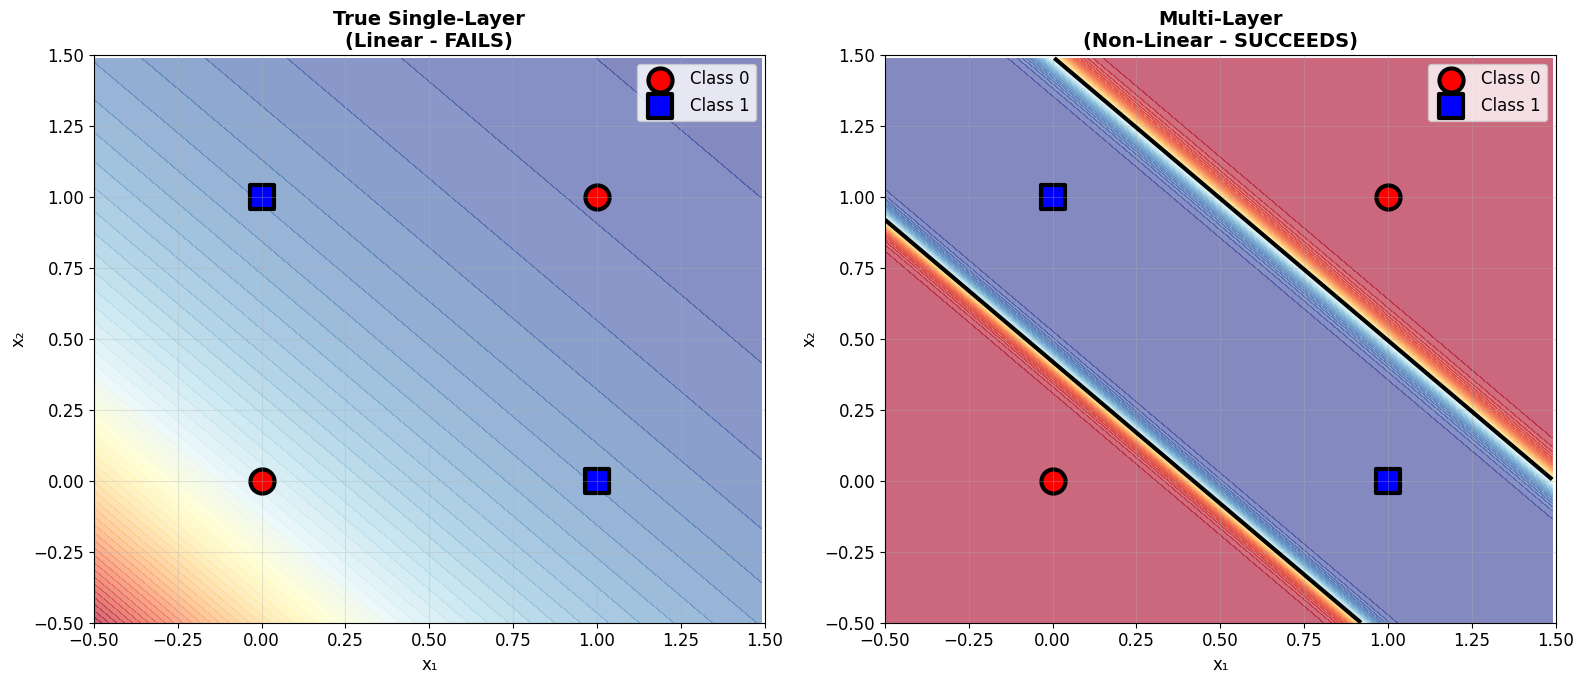

KEY INSIGHT:
• True single-layer: Can only create straight lines → FAILS
• Multi-layer: Creates curved boundaries → SUCCEEDS
• Hidden layers enable non-linear transformations!


In [ ]:
# Create decision boundary visualization
def plot_decision_boundary(model, title, ax):
    h = 0.01
    x_min, x_max = -0.5, 1.5
    y_min, y_max = -0.5, 1.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))
    
    grid_points = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
    with torch.no_grad():
        Z = model(grid_points).numpy()
    Z = Z.reshape(xx.shape)
    
    # Create contour plot
    contour = ax.contourf(xx, yy, Z, levels=50, alpha=0.6, cmap='RdYlBu')
    ax.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=3)
    
    # Plot XOR points
    colors = ['red', 'blue']
    markers = ['o', 's']
    for i in range(2):
        mask = y_xor.flatten() == i
        ax.scatter(X_xor[mask, 0], X_xor[mask, 1], 
                  c=colors[i], s=300, alpha=1.0, 
                  edgecolors='black', linewidth=3,
                  marker=markers[i], label=f'Class {i}')
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_title(title, fontweight='bold', fontsize=14)
    ax.set_xlabel('x₁')
    ax.set_ylabel('x₂')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Create comparison plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

plot_decision_boundary(true_single, 'True Single-Layer\n(Linear - FAILS)', ax1)
plot_decision_boundary(multi_layer, 'Multi-Layer\n(Non-Linear - SUCCEEDS)', ax2)

plt.tight_layout()
plt.show()

print("KEY INSIGHT:")
print("• True single-layer: Can only create straight lines → FAILS")
print("• Multi-layer: Creates curved boundaries → SUCCEEDS")
print("• Hidden layers enable non-linear transformations!")

### Mathematical Explanation: Why Depth Solves XOR

**True single-layer limitation**: 
$$y = \sigma(w_1 x_1 + w_2 x_2 + b)$$
Decision boundary: $w_1 x_1 + w_2 x_2 + b = 0$ (always a straight line)

**Multi-layer solution**: Decompose XOR into simpler operations
$$h_1 = \sigma(w_{11} x_1 + w_{12} x_2 + b_1) \quad \text{(≈ OR gate)}$$
$$h_2 = \sigma(w_{21} x_1 + w_{22} x_2 + b_2) \quad \text{(≈ AND gate)}$$
$$y = \sigma(v_1 h_1 + v_2 h_2 + b_3) \quad \text{(≈ OR AND NOT)}$$

**Result**: XOR = (OR) AND (NOT AND) = compositional solution!

### Practical Implications for SciML

#### 1. Width vs Depth Trade-offs

- **UAT (single layer)**: Requires exponentially many neurons for some functions
- **Deep networks**: Can be exponentially more efficient
- **Approximation rates**: 
  - Single layer: $O(n^{-1/d})$ for $d$-dimensional inputs
  - Deep networks: Can achieve $O(e^{-cn})$ for smooth functions
  
#### Beyond XOR: High-Frequency Functions

**The deeper question**: Does the depth advantage extend beyond simple classification?

**Test case**: High-frequency function $f(x) = \sin(\pi x) + 0.3\sin(10\pi x)$



In [ ]:
# High-frequency function challenge
def high_freq_function(x):
    return np.sin(np.pi * x) + 0.3 * np.sin(10 * np.pi * x)

# Generate data
x_hf = np.linspace(0, 1, 200)
y_hf_true = high_freq_function(x_hf)

# Sparse training data
x_hf_train = np.linspace(0, 1, 25)
y_hf_train = high_freq_function(x_hf_train) + 0.01 * np.random.randn(25)

# Convert to tensors
x_hf_train_t = torch.tensor(x_hf_train.reshape(-1, 1), dtype=torch.float32)
y_hf_train_t = torch.tensor(y_hf_train.reshape(-1, 1), dtype=torch.float32)
x_hf_test_t = torch.tensor(x_hf.reshape(-1, 1), dtype=torch.float32)

# Define architectures
class ShallowNetwork(nn.Module):
    """Single hidden layer with many neurons"""
    def __init__(self, width=100):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(1, width),
            nn.Tanh(),
            nn.Linear(width, 1)
        )
    
    def forward(self, x):
        return self.network(x)

class DeepNetwork(nn.Module):
    """Multiple hidden layers with fewer neurons each"""
    def __init__(self, width=25, depth=4):
        super().__init__()
        layers = [nn.Linear(1, width), nn.Tanh()]
        for _ in range(depth-1):
            layers.extend([nn.Linear(width, width), nn.Tanh()])
        layers.append(nn.Linear(width, 1))
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

def train_regressor(model, x_train, y_train, epochs=5000, lr=0.01):
    """Train regression model"""
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    for epoch in range(epochs):
        pred = model(x_train)
        loss = criterion(pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 1000 == 0:
            print(f'Epoch {epoch+1}: Loss = {loss.item():.6f}')
    
    return loss.item()

# Train models
print("Training shallow network (1 layer, 100 neurons)...")
shallow_net = ShallowNetwork(100)
shallow_loss = train_regressor(shallow_net, x_hf_train_t, y_hf_train_t)

print("\nTraining deep network (4 layers, 25 neurons each)...")
deep_net = DeepNetwork(25, 4)
deep_loss = train_regressor(deep_net, x_hf_train_t, y_hf_train_t)

print(f"\nComparison:")
print(f"Shallow final loss: {shallow_loss:.6f}")
print(f"Deep final loss: {deep_loss:.6f}")
print(f"Improvement: {shallow_loss/deep_loss:.1f}x better")

Training shallow network (1 layer, 100 neurons)...
Epoch 1000: Loss = 0.042941
Epoch 2000: Loss = 0.042920
Epoch 3000: Loss = 0.042881
Epoch 4000: Loss = 0.042869
Epoch 5000: Loss = 0.042858

Training deep network (4 layers, 25 neurons each)...
Epoch 1000: Loss = 0.000016
Epoch 2000: Loss = 0.002732
Epoch 3000: Loss = 0.000000
Epoch 4000: Loss = 0.000001
Epoch 5000: Loss = 0.000251

Comparison:
Shallow final loss: 0.042858
Deep final loss: 0.000251
Improvement: 170.9x better


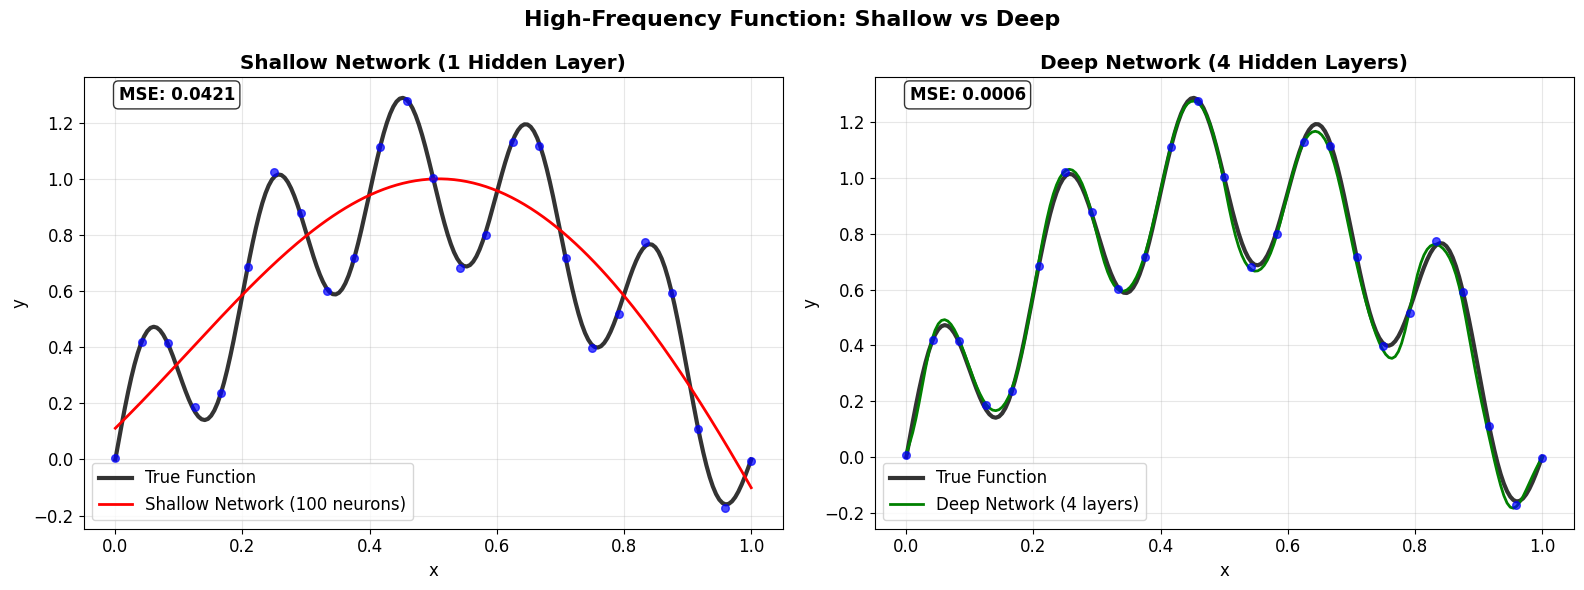


Parameter Efficiency:
Shallow network: 301 parameters, MSE: 0.042098
Deep network: 2026 parameters, MSE: 0.000635

Deep network: 66.3x better performance
              0.1x more parameters

Conclusion: Deep networks are more parameter-efficient!


In [ ]:
# Visualize high-frequency results
with torch.no_grad():
    shallow_pred = shallow_net(x_hf_test_t).numpy().flatten()
    deep_pred = deep_net(x_hf_test_t).numpy().flatten()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Shallow network
ax1.plot(x_hf, y_hf_true, 'k-', linewidth=3, label='True Function', alpha=0.8)
ax1.plot(x_hf, shallow_pred, 'r-', linewidth=2, label='Shallow Network (100 neurons)')
ax1.scatter(x_hf_train, y_hf_train, color='blue', s=30, alpha=0.7, zorder=5)

shallow_mse = np.mean((shallow_pred - y_hf_true)**2)
ax1.text(0.05, 0.95, f'MSE: {shallow_mse:.4f}', transform=ax1.transAxes,
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
         fontsize=12, fontweight='bold')

ax1.set_title('Shallow Network (1 Hidden Layer)', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlabel('x')
ax1.set_ylabel('y')

# Deep network
ax2.plot(x_hf, y_hf_true, 'k-', linewidth=3, label='True Function', alpha=0.8)
ax2.plot(x_hf, deep_pred, 'g-', linewidth=2, label='Deep Network (4 layers)')
ax2.scatter(x_hf_train, y_hf_train, color='blue', s=30, alpha=0.7, zorder=5)

deep_mse = np.mean((deep_pred - y_hf_true)**2)
ax2.text(0.05, 0.95, f'MSE: {deep_mse:.4f}', transform=ax2.transAxes,
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
         fontsize=12, fontweight='bold')

ax2.set_title('Deep Network (4 Hidden Layers)', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlabel('x')
ax2.set_ylabel('y')

plt.suptitle('High-Frequency Function: Shallow vs Deep', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Parameter comparison
shallow_params = sum(p.numel() for p in shallow_net.parameters())
deep_params = sum(p.numel() for p in deep_net.parameters())

print(f"\nParameter Efficiency:")
print(f"Shallow network: {shallow_params} parameters, MSE: {shallow_mse:.6f}")
print(f"Deep network: {deep_params} parameters, MSE: {deep_mse:.6f}")
print(f"\nDeep network: {shallow_mse/deep_mse:.1f}x better performance")
print(f"              {shallow_params/deep_params:.1f}x more parameters")
print(f"\nConclusion: Deep networks are more parameter-efficient!")

### Historical Timeline: From Crisis to Revolution

**The XOR crisis and its resolution transformed AI:**

| Year | Event | Impact |
|------|-------|--------|
| 1943 | McCulloch-Pitts neuron | Foundation laid |
| 1957 | Rosenblatt's Perceptron | First learning success |
| **1969** | **Minsky & Papert: XOR problem** | **Showed true single-layer limits** |
| 1970s-80s | "AI Winter" | Funding dried up |
| 1986 | Backpropagation algorithm | Enabled multi-layer training |
| 1989 | Universal Approximation Theorem | Theoretical foundation |
| 2006+ | Deep Learning Revolution | Depth proves essential |

**The lesson**: XOR taught us that **depth is not luxury—it's necessity**.

### Why Depth Matters: The Four Key Insights

1. **Representation Efficiency**
- **Shallow networks**: May need exponentially many neurons
- **Deep networks**: Hierarchical composition is exponentially more efficient
- **Example**: XOR impossible with 1 layer, trivial with 2 layers

2. **Feature Hierarchy**
- **Layer 1**: Simple features (edges, basic patterns)
- **Layer 2**: Feature combinations (corners, textures)
- **Layer 3+**: Complex abstractions (objects, concepts)
- **Key insight**: Real-world problems have hierarchical structure

3. **Geometric Transformation**
- Each layer performs **coordinate transformation**
- Deep networks "unfold" complex data manifolds
- **XOR example**: Transform non-separable → separable
- **General principle**: Depth enables progressive simplification

4. **Compositional Learning**
- Complex functions = composition of simple functions
- **Mathematical**: $f(x) = f_L(f_{L-1}(...f_1(x)))$
- **Practical**: Build complexity incrementally
- **Universal**: Applies across domains (vision, language, science)

> 📖 Reading Activity: [Do ML models memorize or generalize?](https://pair.withgoogle.com/explorables/grokking/)